## Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import scipy.stats as sp
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
import mne
import os
import sys
sys.path.append(os.path.abspath("../src"))
from functions import *


correct_counts = True

## Load pre/post-stim reference matrices + irrev values, load into the behavior dataframe

In [2]:
project_directory = os.path.dirname(os.path.dirname(os.path.abspath("clean_analysis_dataset1")))

df = pd.read_csv(os.path.join(project_directory, r"data", r"eNeuro_data", r"behavior_eNeuro.csv"))

prestim_ref_mat = scipy.io.loadmat(os.path.join(project_directory, r"data", r"fr_results new dataset", r"FowRev_prestimulus_tau5.mat"))['FowRev'].flatten()
poststim_ref_mat = scipy.io.loadmat(os.path.join(project_directory, r"data", r"fr_results new dataset", r"FowRev_poststimulus_tau5.mat"))['FowRev'].flatten()

df['prestim_irrev'] = prestim_ref_mat
df['poststim_irrev'] = poststim_ref_mat

#df['stim_diff'] = (df['poststim_irrev'] - df['prestim_irrev'])

df['log_prestim'] = np.log(df['prestim_irrev'])
df['log_poststim'] = np.log(df['poststim_irrev'])


df.head()
df.shape

(45539, 17)

### ignore

In [11]:
# prestim_channel_alpha = np.load(os.path.join(project_directory, r"data", r"prestim_channel_alphapower.npy"))
# prestim_mean_alpha = np.mean(prestim_channel_alpha, axis=1)
# df['prestim_mean_alpha'] = prestim_mean_alpha
# poststim_channel_alpha = np.load(os.path.join(project_directory, r"data", r"poststim_channel_alphapower.npy"))
# poststim_mean_alpha = np.mean(poststim_channel_alpha, axis=1)
# df['poststim_mean_alpha'] = poststim_mean_alpha

# df['trial'] = df.index

# pre_sampEn_bychannel_array = np.load(os.path.join(project_directory, r"data", r"prestim_sampEn_bychannel.npy"))
# list1 = [pre_sampEn_bychannel_array[i] for i in range(pre_sampEn_bychannel_array.shape[0])]
# df['prestim_sampen_bychannel'] = list1
# df['prestim_sampen_mean'] = df['prestim_sampen_bychannel'].apply(lambda x: np.mean(x))

# post_sampEn_bychannel_array = np.load(os.path.join(project_directory, r"data", r"poststim_sampEn_bychannel.npy"))
# list1 = [post_sampEn_bychannel_array[i] for i in range(post_sampEn_bychannel_array.shape[0])]
# df['poststim_sampen_bychannel'] = list1
# df['poststim_sampen_mean'] = df['poststim_sampen_bychannel'].apply(lambda x: np.mean(x))



# df['prestim_heirarchy'] = [np.std(matrix) for matrix in df['prestim_ref_mat']]
# # post -- 
# df['poststim_heirarchy'] = [np.std(matrix) for matrix in df['poststim_ref_mat']]

## Analysis used for thesis

### Prestim

#### All drugs combined

bl_pupil_bin
0   -11.533202
1    -6.046180
2    -1.953464
3     2.425618
4     9.979058
Name: bl_pupil, dtype: float64


C:\Users\Jake\AppData\Local\Temp\ipykernel_17296\1444823354.py:24: DeprecationWarning: Please import `ttest_1samp` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  _, betas_first['d'] = sp.stats.ttest_1samp(df_subject.groupby(['subject']).apply(run_model_pupilbin,(1),('d')), 0)
C:\Users\Jake\AppData\Local\Temp\ipykernel_17296\1444823354.py:26: DeprecationWarning: Please import `ttest_1samp` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  _, betas_second['d'] = sp.stats.ttest_1samp(df_subject.groupby(['subject']).apply(run_model_pupilbin,(2),('d')), 0)


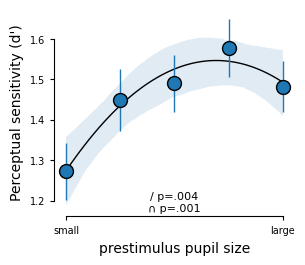

In [3]:
# ALL DRUGS COMBINED

# Loading behavioral data
behavior = df

cfg = {'n_bins': 5}  # Number of pupil bins
behavior['bl_pupil_bin'] = behavior.groupby(['subject', 'drug', 'block'])['bl_pupil'].apply(lambda x: pd.qcut(x, cfg['n_bins'], labels=range(cfg['n_bins']))).to_numpy()

df_group = behavior.sort_values(by=['subject','session','block'])

        # make bins
df_group['bl_pupil_bin'] = np.concatenate(np.ravel(df_group.groupby(['subject','session','block'])['bl_pupil'].agg(
        lambda x: list(pd.qcut(x, cfg['n_bins'],labels = range(cfg['n_bins']))))))

correct_counts = True
df_sdt = df_group.groupby(['subject','drug','bl_pupil_bin']).apply(lambda x: sdt(x, correct_counts))

df_subject = df_sdt.groupby(['subject', 'bl_pupil_bin']).mean()
df_subject.reset_index(inplace=True)

print(behavior.groupby('bl_pupil_bin').mean()['bl_pupil'])

betas_first = dict()
_, betas_first['d'] = sp.stats.ttest_1samp(df_subject.groupby(['subject']).apply(run_model_pupilbin,(1),('d')), 0)
betas_second = dict()
_, betas_second['d'] = sp.stats.ttest_1samp(df_subject.groupby(['subject']).apply(run_model_pupilbin,(2),('d')), 0)


# Plotting results for d'
cm = 1 / 2.54  # Conversion factor to cm
fig, ax = plt.subplots(figsize=(8*cm, 7*cm))

ym = df_sdt.groupby('bl_pupil_bin').mean()['d']
yerr = df_sdt.groupby('bl_pupil_bin').sem()['d']
ax.errorbar(range(cfg['n_bins']), ym, yerr=yerr, capsize=0, ls='None', marker='o', alpha=1, zorder=1000, ms=10, mew=1, elinewidth=1, markeredgecolor='k')

p_val_linear = betas_first['d']
p_val_quadratic = betas_second['d']

# Initialize variables to decide which model to plot
plot_linear = False
plot_quadratic = False

# Determine which model to plot based on the significance and smaller p-value
if p_val_linear < 0.05 or p_val_quadratic < 0.05:
    if p_val_linear < p_val_quadratic:
        plot_linear = True
    elif p_val_quadratic < p_val_linear:
        plot_quadratic = True

# Optionally add model fits if linear/quadratic fit was significant
if plot_linear:
    sns.regplot(ax=ax, data=df_subject, x="bl_pupil_bin", y="d", scatter=False, color=sns.color_palette('Set1', 2)[-1],
                line_kws={'linestyle': '-', 'lw': 1}, order=1, ci=68)
    # Adjusting line color to black for visibility
    ax.get_lines()[-1].set_color('k')

if plot_quadratic:
    sns.regplot(ax=ax, data=df_subject, x="bl_pupil_bin", y="d", scatter=False, color=sns.color_palette('Set1', 2)[-1],
                line_kws={'linestyle': '-', 'lw': 1}, order=2, ci=68)
    # Adjusting line color to black for visibility
    ax.get_lines()[-1].set_color('k')

# Plot p-values for the polynomial regression significance
ax.text(0.5, 0.01, '/ {}\n∩ {}'.format(p_val_string(betas_first['d']),
                                        p_val_string(betas_second['d'])), ha='center', va='bottom', transform=ax.transAxes, size=8)

sns.despine(ax=ax, offset=1, trim=True)

# Setting labels and titles
ax.set_ylabel('Perceptual sensitivity (d\')')
ax.set_xlabel('prestimulus pupil size')
ax.set_xticks([0,cfg['n_bins']-1])
ax.set_xticklabels(['small', 'large']) 
ax.tick_params(axis='both', which='major', labelsize=7, length=3)

fig.tight_layout()
plt.show()

#### By Drug

C:\Users\Jake\AppData\Local\Temp\ipykernel_17296\726207482.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior['irrev'] = df['log_poststim']
C:\Users\Jake\AppData\Local\Temp\ipykernel_17296\726207482.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior['irreversibility_bin'] = behavior.groupby(['subject', 'session', 'block'])['irrev'].apply(lambda x: pd.qcut(x, cfg['n_bins'], labels=range(cfg['n_bins']))).to_numpy()


Drug: PLC
Bin means: irreversibility_bin
0   -6.519721
1   -6.124410
2   -5.875642
3   -5.620246
4   -5.191455
Name: irrev, dtype: float64


C:\Users\Jake\AppData\Local\Temp\ipykernel_17296\726207482.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior['irreversibility_bin'] = behavior.groupby(['subject', 'session', 'block'])['irrev'].apply(lambda x: pd.qcut(x, cfg['n_bins'], labels=range(cfg['n_bins']))).to_numpy()


Drug: DNP
Bin means: irreversibility_bin
0   -6.405311
1   -6.033222
2   -5.803090
3   -5.565888
4   -5.137096
Name: irrev, dtype: float64


C:\Users\Jake\AppData\Local\Temp\ipykernel_17296\726207482.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior['irreversibility_bin'] = behavior.groupby(['subject', 'session', 'block'])['irrev'].apply(lambda x: pd.qcut(x, cfg['n_bins'], labels=range(cfg['n_bins']))).to_numpy()


Drug: ATX
Bin means: irreversibility_bin
0   -6.457053
1   -6.072068
2   -5.827819
3   -5.583171
4   -5.153136
Name: irrev, dtype: float64


C:\Users\Jake\AppData\Local\Temp\ipykernel_17296\726207482.py:55: DeprecationWarning: Please import `ttest_1samp` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  _, betas_first_irreversibility_plc['d'] = sp.stats.ttest_1samp(df_subject_irreversibility_plc.groupby(['subject']).apply(run_model_irrevbin, 1, 'd'), 0)
C:\Users\Jake\AppData\Local\Temp\ipykernel_17296\726207482.py:58: DeprecationWarning: Please import `ttest_1samp` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  _, betas_second_irreversibility_plc['d'] = sp.stats.ttest_1samp(df_subject_irreversibility_plc.groupby(['subject']).apply(run_model_irrevbin, 2, 'd'), 0)
C:\Users\Jake\AppData\Local\Temp\ipykernel_17296\726207482.py:62: DeprecationWarning: Please import `ttest_1samp` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 

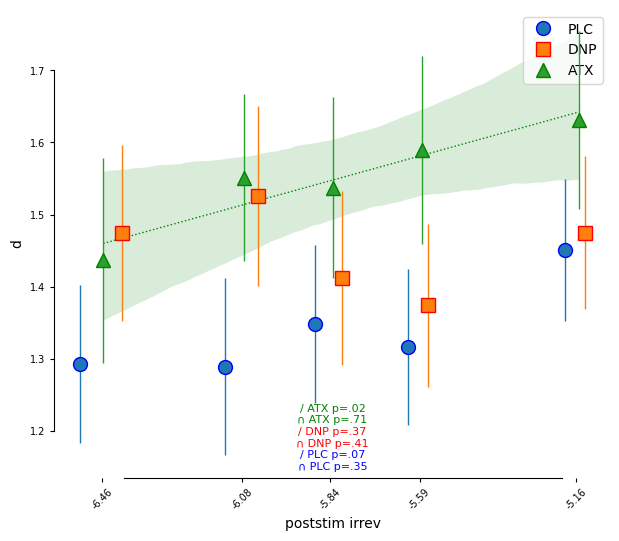

In [4]:
behavior = df
#behavior = remove_top_percentile(behavior, 'prestim_mean_alpha', 0.999)
#behavior = remove_top_percentile(behavior, 'poststim_mean_alpha', 0.999)
behavior = behavior[(behavior['poststim_irrev'] < 0.075) & (behavior['prestim_irrev'] < 0.075)]

behavior['irrev'] = df['log_poststim']
cfg = {'n_bins': 5}  # Number of pupil bins

def process_behavior(behavior, drug):
    behavior = behavior[(behavior['drug'] == drug)]
    
    behavior['irreversibility_bin'] = behavior.groupby(['subject', 'session', 'block'])['irrev'].apply(lambda x: pd.qcut(x, cfg['n_bins'], labels=range(cfg['n_bins']))).to_numpy()

    correct_counts = True
    df_sdt_irreversibility = behavior.groupby(['subject', 'drug', 'irreversibility_bin']).apply(lambda x: sdt(x, correct_counts))
    
    df_subject_irreversibility = df_sdt_irreversibility.groupby(['subject', 'irreversibility_bin']).mean()
    df_subject_irreversibility.reset_index(inplace=True)
    
    # Calculate the mean of each bin for x-axis labels
    bin_means = behavior.groupby('irreversibility_bin').mean()['irrev']
    print("Drug: " + drug)
    print("Bin means: " + str(bin_means))
    
    return df_subject_irreversibility, bin_means

# Process data for PLC
df_subject_irreversibility_plc, bin_means_plc = process_behavior(behavior, 'PLC')

# Process data for DNP
df_subject_irreversibility_dnp, bin_means_dnp = process_behavior(behavior, 'DNP')

# Process data for ATX
df_subject_irreversibility_atx, bin_means_atx = process_behavior(behavior, 'ATX')

total_bin_means = (bin_means_plc + bin_means_dnp + bin_means_atx) / 3

# Combine all data
df_combined = pd.concat([
    df_subject_irreversibility_plc.assign(drug='PLC', bin_mean=bin_means_plc[df_subject_irreversibility_plc['irreversibility_bin']].values),
    df_subject_irreversibility_dnp.assign(drug='DNP', bin_mean=bin_means_dnp[df_subject_irreversibility_dnp['irreversibility_bin']].values),
    df_subject_irreversibility_atx.assign(drug='ATX', bin_mean=bin_means_atx[df_subject_irreversibility_atx['irreversibility_bin']].values)
])

# Initialize variables to decide which model to plot
plot_linear_plc = False
plot_quadratic_plc = False
plot_linear_dnp = False
plot_quadratic_dnp = False
plot_linear_atx = False
plot_quadratic_atx = False

# Calculate betas for PLC
betas_first_irreversibility_plc = dict()
_, betas_first_irreversibility_plc['d'] = sp.stats.ttest_1samp(df_subject_irreversibility_plc.groupby(['subject']).apply(run_model_irrevbin, 1, 'd'), 0)

betas_second_irreversibility_plc = dict()
_, betas_second_irreversibility_plc['d'] = sp.stats.ttest_1samp(df_subject_irreversibility_plc.groupby(['subject']).apply(run_model_irrevbin, 2, 'd'), 0)

# Calculate betas for DNP
betas_first_irreversibility_dnp = dict()
_, betas_first_irreversibility_dnp['d'] = sp.stats.ttest_1samp(df_subject_irreversibility_dnp.groupby(['subject']).apply(run_model_irrevbin, 1, 'd'), 0)

betas_second_irreversibility_dnp = dict()
_, betas_second_irreversibility_dnp['d'] = sp.stats.ttest_1samp(df_subject_irreversibility_dnp.groupby(['subject']).apply(run_model_irrevbin, 2, 'd'), 0)

# Calculate betas for ATX
betas_first_irreversibility_atx = dict()
_, betas_first_irreversibility_atx['d'] = sp.stats.ttest_1samp(df_subject_irreversibility_atx.groupby(['subject']).apply(run_model_irrevbin, 1, 'd'), 0)

betas_second_irreversibility_atx = dict()
_, betas_second_irreversibility_atx['d'] = sp.stats.ttest_1samp(df_subject_irreversibility_atx.groupby(['subject']).apply(run_model_irrevbin, 2, 'd'), 0)

# Determine which model to plot for PLC based on the significance and smaller p-value
if betas_first_irreversibility_plc['d'] < 0.05 or betas_second_irreversibility_plc['d'] < 0.05:
    if betas_first_irreversibility_plc['d'] < betas_second_irreversibility_plc['d']:
        plot_linear_plc = True
    elif betas_second_irreversibility_plc['d'] < betas_first_irreversibility_plc['d']:
        plot_quadratic_plc = True

# Determine which model to plot for DNP based on the significance and smaller p-value
if betas_first_irreversibility_dnp['d'] < 0.05 or betas_second_irreversibility_dnp['d'] < 0.05:
    if betas_first_irreversibility_dnp['d'] < betas_second_irreversibility_dnp['d']:
        plot_linear_dnp = True
    elif betas_second_irreversibility_dnp['d'] < betas_first_irreversibility_dnp['d']:
        plot_quadratic_dnp = True

# Determine which model to plot for ATX based on the significance and smaller p-value
if betas_first_irreversibility_atx['d'] < 0.05 or betas_second_irreversibility_atx['d'] < 0.05:
    if betas_first_irreversibility_atx['d'] < betas_second_irreversibility_atx['d']:
        plot_linear_atx = True
    elif betas_second_irreversibility_atx['d'] < betas_first_irreversibility_atx['d']:
        plot_quadratic_atx = True

# Plotting results for log_poststim'
cm = 1 / 2.54  # Conversion factor to cm
fig, ax = plt.subplots(figsize=(16*cm, 14*cm))

# PLC data
ym_plc = df_subject_irreversibility_plc.groupby('irreversibility_bin').mean()['d']
yerr_plc = df_subject_irreversibility_plc.groupby('irreversibility_bin').sem()['d']
ax.errorbar(bin_means_plc, ym_plc, yerr=yerr_plc, capsize=0, ls='None', marker='o', alpha=1, zorder=1000, ms=10, mew=1, elinewidth=1, markeredgecolor='b', label='PLC')

# DNP data
ym_dnp = df_subject_irreversibility_dnp.groupby('irreversibility_bin').mean()['d']
yerr_dnp = df_subject_irreversibility_dnp.groupby('irreversibility_bin').sem()['d']
ax.errorbar(bin_means_dnp, ym_dnp, yerr=yerr_dnp, capsize=0, ls='None', marker='s', alpha=1, zorder=1000, ms=10, mew=1, elinewidth=1, markeredgecolor='r', label='DNP')

# ATX data
ym_atx = df_subject_irreversibility_atx.groupby('irreversibility_bin').mean()['d']
yerr_atx = df_subject_irreversibility_atx.groupby('irreversibility_bin').sem()['d']
ax.errorbar(bin_means_atx, ym_atx, yerr=yerr_atx, capsize=0, ls='None', marker='^', alpha=1, zorder=1000, ms=10, mew=1, elinewidth=1, markeredgecolor='g', label='ATX')

# Plot linear/quadratic fit for each drug
def plot_fit(ax, df, color, linestyle, order):
    sns.regplot(ax=ax, data=df, x="bin_mean", y="d", scatter=False, color=color,
                line_kws={'linestyle': linestyle, 'lw': 1}, order=order, ci=68)

# Optionally add model fits if linear/quadratic fit was significant for PLC
if plot_linear_plc:
    plot_fit(ax, df_combined[df_combined['drug'] == 'PLC'], 'b', '-', 1)
if plot_quadratic_plc:
    plot_fit(ax, df_combined[df_combined['drug'] == 'PLC'], 'b', '-', 2)

# Optionally add model fits if linear/quadratic fit was significant for DNP
if plot_linear_dnp:
    plot_fit(ax, df_combined[df_combined['drug'] == 'DNP'], 'r', '--', 1)
if plot_quadratic_dnp:
    plot_fit(ax, df_combined[df_combined['drug'] == 'DNP'], 'r', '--', 2)

# Optionally add model fits if linear/quadratic fit was significant for ATX
if plot_linear_atx:
    plot_fit(ax, df_combined[df_combined['drug'] == 'ATX'], 'g', ':', 1)
if plot_quadratic_atx:
    plot_fit(ax, df_combined[df_combined['drug'] == 'ATX'], 'g', ':', 2)

# Plot p-values for the polynomial regression significance
ax.text(0.5, 0.01, '/ PLC {}\n∩ PLC {}'.format(p_val_string(betas_first_irreversibility_plc['d']),
                                               p_val_string(betas_second_irreversibility_plc['d'])), ha='center', va='bottom', transform=ax.transAxes, size=8, color='b')

ax.text(0.5, 0.06, '/ DNP {}\n∩ DNP {}'.format(p_val_string(betas_first_irreversibility_dnp['d']),
                                               p_val_string(betas_second_irreversibility_dnp['d'])), ha='center', va='bottom', transform=ax.transAxes, size=8, color='r')

ax.text(0.5, 0.11, '/ ATX {}\n∩ ATX {}'.format(p_val_string(betas_first_irreversibility_atx['d']),
                                               p_val_string(betas_second_irreversibility_atx['d'])), ha='center', va='bottom', transform=ax.transAxes, size=8, color='g')

sns.despine(ax=ax, offset=1, trim=True)

# Setting labels and titles
ax.set_ylabel('d')
ax.set_xlabel('poststim irrev')

labels = []
for i in range(cfg['n_bins']):
    labels.append(f"{total_bin_means[i]:.2f}")

ax.set_xticks(total_bin_means)
ax.set_xticklabels(labels, rotation=45)
ax.tick_params(axis='both', which='major', labelsize=7, length=3)

ax.legend()
fig.tight_layout()
plt.show()


prestimulus Pupil bin x prestimulus irreversibility

C:\Users\Jake\AppData\Local\Temp\ipykernel_18236\4026295606.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior['irrev'] = behavior['bl_pupil']
C:\Users\Jake\AppData\Local\Temp\ipykernel_18236\4026295606.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior['irreversibility_bin'] = behavior.groupby(['subject', 'session', 'block'])['irrev'].apply(lambda x: pd.qcut(x, cfg['n_bins'], labels=range(cfg['n_bins']))).to_numpy()


Drug: PLC
Bin means: irreversibility_bin
0   -13.107077
1    -9.376209
2    -7.057391
3    -5.105030
4    -3.188367
5    -1.309335
6     0.728913
7     3.057020
8     5.970362
9    12.445096
Name: irrev, dtype: float64


C:\Users\Jake\AppData\Local\Temp\ipykernel_18236\4026295606.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior['irreversibility_bin'] = behavior.groupby(['subject', 'session', 'block'])['irrev'].apply(lambda x: pd.qcut(x, cfg['n_bins'], labels=range(cfg['n_bins']))).to_numpy()


Drug: DNP
Bin means: irreversibility_bin
0   -14.062124
1    -9.820263
2    -7.213594
3    -4.991130
4    -2.882893
5    -0.729510
6     1.565333
7     4.028302
8     7.275333
9    13.508944
Name: irrev, dtype: float64


C:\Users\Jake\AppData\Local\Temp\ipykernel_18236\4026295606.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior['irreversibility_bin'] = behavior.groupby(['subject', 'session', 'block'])['irrev'].apply(lambda x: pd.qcut(x, cfg['n_bins'], labels=range(cfg['n_bins']))).to_numpy()


Drug: ATX
Bin means: irreversibility_bin
0   -13.289647
1    -9.479326
2    -7.044603
3    -4.883603
4    -2.802030
5    -0.764266
6     1.364816
7     3.814641
8     6.949278
9    13.556662
Name: irrev, dtype: float64


C:\Users\Jake\AppData\Local\Temp\ipykernel_18236\4026295606.py:55: DeprecationWarning: Please import `ttest_1samp` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  _, betas_first_irreversibility_plc['prestim_irrev'] = sp.stats.ttest_1samp(df_subject_irreversibility_plc.groupby(['subject']).apply(run_model_irrevbin, 1, 'prestim_irrev'), 0)
C:\Users\Jake\AppData\Local\Temp\ipykernel_18236\4026295606.py:58: DeprecationWarning: Please import `ttest_1samp` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  _, betas_second_irreversibility_plc['prestim_irrev'] = sp.stats.ttest_1samp(df_subject_irreversibility_plc.groupby(['subject']).apply(run_model_irrevbin, 2, 'prestim_irrev'), 0)
C:\Users\Jake\AppData\Local\Temp\ipykernel_18236\4026295606.py:62: DeprecationWarning: Please import `ttest_1samp` from the `scipy.stats` namespace; the `scipy.stats.stats` na

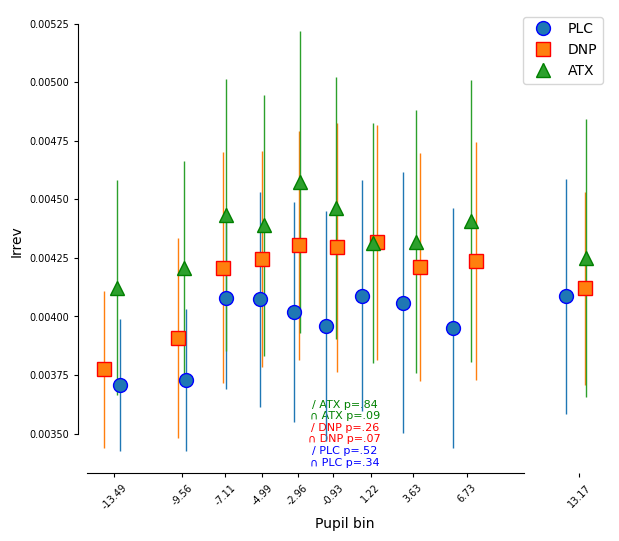

In [7]:
behavior = df
#behavior = remove_top_percentile(behavior, 'prestim_mean_alpha', 0.999)
#behavior = remove_top_percentile(behavior, 'poststim_mean_alpha', 0.999)
behavior = behavior[(behavior['poststim_irrev'] < 0.075) & (behavior['prestim_irrev'] < 0.075)]

behavior['irrev'] = behavior['bl_pupil']
cfg = {'n_bins': 10}  # Number of pupil bins

def process_behavior(behavior, drug):
    behavior = behavior[(behavior['drug'] == drug)]
    
    behavior['irreversibility_bin'] = behavior.groupby(['subject', 'session', 'block'])['irrev'].apply(lambda x: pd.qcut(x, cfg['n_bins'], labels=range(cfg['n_bins']))).to_numpy()

    correct_counts = True
    df_sdt_irreversibility = behavior.groupby(['subject', 'drug', 'irreversibility_bin']).apply(lambda x: sdt(x, correct_counts))
    df_sdt_irreversibility['prestim_irrev'] = behavior.groupby(['subject','drug','irreversibility_bin']).mean()['prestim_irrev']
    df_subject_irreversibility = df_sdt_irreversibility.groupby(['subject', 'irreversibility_bin']).mean()
    df_subject_irreversibility.reset_index(inplace=True)
    
    # Calculate the mean of each bin for x-axis labels
    bin_means = behavior.groupby('irreversibility_bin').mean()['irrev']
    print("Drug: " + drug)
    print("Bin means: " + str(bin_means))
    
    return df_subject_irreversibility, bin_means

# Process data for PLC
df_subject_irreversibility_plc, bin_means_plc = process_behavior(behavior, 'PLC')

# Process data for DNP
df_subject_irreversibility_dnp, bin_means_dnp = process_behavior(behavior, 'DNP')

# Process data for ATX
df_subject_irreversibility_atx, bin_means_atx = process_behavior(behavior, 'ATX')

total_bin_means = (bin_means_plc + bin_means_dnp + bin_means_atx) / 3

# Combine all data
df_combined = pd.concat([
    df_subject_irreversibility_plc.assign(drug='PLC', bin_mean=bin_means_plc[df_subject_irreversibility_plc['irreversibility_bin']].values),
    df_subject_irreversibility_dnp.assign(drug='DNP', bin_mean=bin_means_dnp[df_subject_irreversibility_dnp['irreversibility_bin']].values),
    df_subject_irreversibility_atx.assign(drug='ATX', bin_mean=bin_means_atx[df_subject_irreversibility_atx['irreversibility_bin']].values)
])

# Initialize variables to decide which model to plot
plot_linear_plc = False
plot_quadratic_plc = False
plot_linear_dnp = False
plot_quadratic_dnp = False
plot_linear_atx = False
plot_quadratic_atx = False

# Calculate betas for PLC
betas_first_irreversibility_plc = dict()
_, betas_first_irreversibility_plc['prestim_irrev'] = sp.stats.ttest_1samp(df_subject_irreversibility_plc.groupby(['subject']).apply(run_model_irrevbin, 1, 'prestim_irrev'), 0)

betas_second_irreversibility_plc = dict()
_, betas_second_irreversibility_plc['prestim_irrev'] = sp.stats.ttest_1samp(df_subject_irreversibility_plc.groupby(['subject']).apply(run_model_irrevbin, 2, 'prestim_irrev'), 0)

# Calculate betas for DNP
betas_first_irreversibility_dnp = dict()
_, betas_first_irreversibility_dnp['prestim_irrev'] = sp.stats.ttest_1samp(df_subject_irreversibility_dnp.groupby(['subject']).apply(run_model_irrevbin, 1, 'prestim_irrev'), 0)

betas_second_irreversibility_dnp = dict()
_, betas_second_irreversibility_dnp['prestim_irrev'] = sp.stats.ttest_1samp(df_subject_irreversibility_dnp.groupby(['subject']).apply(run_model_irrevbin, 2, 'prestim_irrev'), 0)

# Calculate betas for ATX
betas_first_irreversibility_atx = dict()
_, betas_first_irreversibility_atx['prestim_irrev'] = sp.stats.ttest_1samp(df_subject_irreversibility_atx.groupby(['subject']).apply(run_model_irrevbin, 1, 'prestim_irrev'), 0)

betas_second_irreversibility_atx = dict()
_, betas_second_irreversibility_atx['prestim_irrev'] = sp.stats.ttest_1samp(df_subject_irreversibility_atx.groupby(['subject']).apply(run_model_irrevbin, 2, 'prestim_irrev'), 0)

# Determine which model to plot for PLC based on the significance and smaller p-value
if betas_first_irreversibility_plc['prestim_irrev'] < 0.05 or betas_second_irreversibility_plc['prestim_irrev'] < 0.05:
    if betas_first_irreversibility_plc['prestim_irrev'] < betas_second_irreversibility_plc['prestim_irrev']:
        plot_linear_plc = True
    elif betas_second_irreversibility_plc['prestim_irrev'] < betas_first_irreversibility_plc['prestim_irrev']:
        plot_quadratic_plc = True

# Determine which model to plot for DNP based on the significance and smaller p-value
if betas_first_irreversibility_dnp['prestim_irrev'] < 0.05 or betas_second_irreversibility_dnp['prestim_irrev'] < 0.05:
    if betas_first_irreversibility_dnp['prestim_irrev'] < betas_second_irreversibility_dnp['prestim_irrev']:
        plot_linear_dnp = True
    elif betas_second_irreversibility_dnp['prestim_irrev'] < betas_first_irreversibility_dnp['prestim_irrev']:
        plot_quadratic_dnp = True

# Determine which model to plot for ATX based on the significance and smaller p-value
if betas_first_irreversibility_atx['prestim_irrev'] < 0.05 or betas_second_irreversibility_atx['prestim_irrev'] < 0.05:
    if betas_first_irreversibility_atx['prestim_irrev'] < betas_second_irreversibility_atx['prestim_irrev']:
        plot_linear_atx = True
    elif betas_second_irreversibility_atx['prestim_irrev'] < betas_first_irreversibility_atx['prestim_irrev']:
        plot_quadratic_atx = True

# Plotting results for prestim_irrev'
cm = 1 / 2.54  # Conversion factor to cm
fig, ax = plt.subplots(figsize=(16*cm, 14*cm))

# PLC data
ym_plc = df_subject_irreversibility_plc.groupby('irreversibility_bin').mean()['prestim_irrev']
yerr_plc = df_subject_irreversibility_plc.groupby('irreversibility_bin').sem()['prestim_irrev']
ax.errorbar(bin_means_plc, ym_plc, yerr=yerr_plc, capsize=0, ls='None', marker='o', alpha=1, zorder=1000, ms=10, mew=1, elinewidth=1, markeredgecolor='b', label='PLC')

# DNP data
ym_dnp = df_subject_irreversibility_dnp.groupby('irreversibility_bin').mean()['prestim_irrev']
yerr_dnp = df_subject_irreversibility_dnp.groupby('irreversibility_bin').sem()['prestim_irrev']
ax.errorbar(bin_means_dnp, ym_dnp, yerr=yerr_dnp, capsize=0, ls='None', marker='s', alpha=1, zorder=1000, ms=10, mew=1, elinewidth=1, markeredgecolor='r', label='DNP')

# ATX data
ym_atx = df_subject_irreversibility_atx.groupby('irreversibility_bin').mean()['prestim_irrev']
yerr_atx = df_subject_irreversibility_atx.groupby('irreversibility_bin').sem()['prestim_irrev']
ax.errorbar(bin_means_atx, ym_atx, yerr=yerr_atx, capsize=0, ls='None', marker='^', alpha=1, zorder=1000, ms=10, mew=1, elinewidth=1, markeredgecolor='g', label='ATX')

# Plot linear/quadratic fit for each drug
def plot_fit(ax, df, color, linestyle, order):
    sns.regplot(ax=ax, data=df, x="bin_mean", y="prestim_irrev", scatter=False, color=color,
                line_kws={'linestyle': linestyle, 'lw': 1}, order=order, ci=68)

# Optionally add model fits if linear/quadratic fit was significant for PLC
if plot_linear_plc:
    plot_fit(ax, df_combined[df_combined['drug'] == 'PLC'], 'b', '-', 1)
if plot_quadratic_plc:
    plot_fit(ax, df_combined[df_combined['drug'] == 'PLC'], 'b', '-', 2)

# Optionally add model fits if linear/quadratic fit was significant for DNP
if plot_linear_dnp:
    plot_fit(ax, df_combined[df_combined['drug'] == 'DNP'], 'r', '--', 1)
if plot_quadratic_dnp:
    plot_fit(ax, df_combined[df_combined['drug'] == 'DNP'], 'r', '--', 2)

# Optionally add model fits if linear/quadratic fit was significant for ATX
if plot_linear_atx:
    plot_fit(ax, df_combined[df_combined['drug'] == 'ATX'], 'g', ':', 1)
if plot_quadratic_atx:
    plot_fit(ax, df_combined[df_combined['drug'] == 'ATX'], 'g', ':', 2)

# Plot p-values for the polynomial regression significance
ax.text(0.5, 0.01, '/ PLC {}\n∩ PLC {}'.format(p_val_string(betas_first_irreversibility_plc['prestim_irrev']),
                                               p_val_string(betas_second_irreversibility_plc['prestim_irrev'])), ha='center', va='bottom', transform=ax.transAxes, size=8, color='b')

ax.text(0.5, 0.06, '/ DNP {}\n∩ DNP {}'.format(p_val_string(betas_first_irreversibility_dnp['prestim_irrev']),
                                               p_val_string(betas_second_irreversibility_dnp['prestim_irrev'])), ha='center', va='bottom', transform=ax.transAxes, size=8, color='r')

ax.text(0.5, 0.11, '/ ATX {}\n∩ ATX {}'.format(p_val_string(betas_first_irreversibility_atx['prestim_irrev']),
                                               p_val_string(betas_second_irreversibility_atx['prestim_irrev'])), ha='center', va='bottom', transform=ax.transAxes, size=8, color='g')

sns.despine(ax=ax, offset=1, trim=True)

# Setting labels and titles
ax.set_ylabel('Irrev')
ax.set_xlabel('Pupil bin')

labels = []
for i in range(cfg['n_bins']):
    labels.append(f"{total_bin_means[i]:.2f}")

ax.set_xticks(total_bin_means)
ax.set_xticklabels(labels, rotation=45)
ax.tick_params(axis='both', which='major', labelsize=7, length=3)

ax.legend()
fig.tight_layout()
plt.show()


### Poststim

C:\Users\Jake\AppData\Local\Temp\ipykernel_18236\726207482.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior['irrev'] = df['log_poststim']
C:\Users\Jake\AppData\Local\Temp\ipykernel_18236\726207482.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior['irreversibility_bin'] = behavior.groupby(['subject', 'session', 'block'])['irrev'].apply(lambda x: pd.qcut(x, cfg['n_bins'], labels=range(cfg['n_bins']))).to_numpy()


Drug: PLC
Bin means: irreversibility_bin
0   -6.519721
1   -6.124410
2   -5.875642
3   -5.620246
4   -5.191455
Name: irrev, dtype: float64


C:\Users\Jake\AppData\Local\Temp\ipykernel_18236\726207482.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior['irreversibility_bin'] = behavior.groupby(['subject', 'session', 'block'])['irrev'].apply(lambda x: pd.qcut(x, cfg['n_bins'], labels=range(cfg['n_bins']))).to_numpy()


Drug: DNP
Bin means: irreversibility_bin
0   -6.405311
1   -6.033222
2   -5.803090
3   -5.565888
4   -5.137096
Name: irrev, dtype: float64


C:\Users\Jake\AppData\Local\Temp\ipykernel_18236\726207482.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior['irreversibility_bin'] = behavior.groupby(['subject', 'session', 'block'])['irrev'].apply(lambda x: pd.qcut(x, cfg['n_bins'], labels=range(cfg['n_bins']))).to_numpy()


Drug: ATX
Bin means: irreversibility_bin
0   -6.457053
1   -6.072068
2   -5.827819
3   -5.583171
4   -5.153136
Name: irrev, dtype: float64


C:\Users\Jake\AppData\Local\Temp\ipykernel_18236\726207482.py:55: DeprecationWarning: Please import `ttest_1samp` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  _, betas_first_irreversibility_plc['d'] = sp.stats.ttest_1samp(df_subject_irreversibility_plc.groupby(['subject']).apply(run_model_irrevbin, 1, 'd'), 0)
C:\Users\Jake\AppData\Local\Temp\ipykernel_18236\726207482.py:58: DeprecationWarning: Please import `ttest_1samp` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  _, betas_second_irreversibility_plc['d'] = sp.stats.ttest_1samp(df_subject_irreversibility_plc.groupby(['subject']).apply(run_model_irrevbin, 2, 'd'), 0)
C:\Users\Jake\AppData\Local\Temp\ipykernel_18236\726207482.py:62: DeprecationWarning: Please import `ttest_1samp` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 

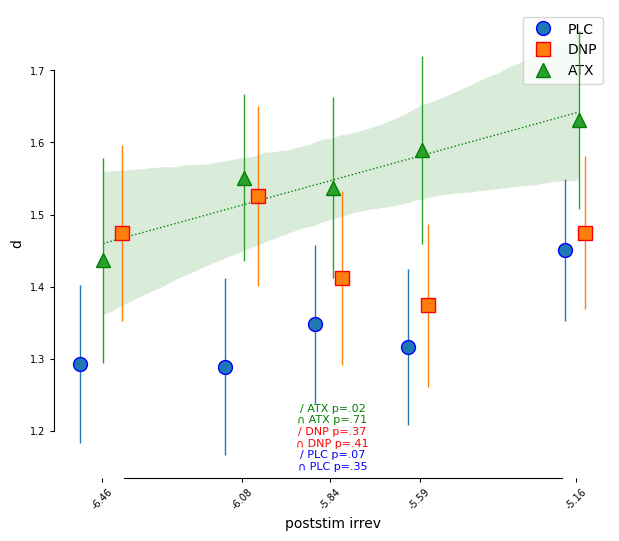

In [8]:
behavior = df
#behavior = remove_top_percentile(behavior, 'prestim_mean_alpha', 0.999)
#behavior = remove_top_percentile(behavior, 'poststim_mean_alpha', 0.999)
behavior = behavior[(behavior['poststim_irrev'] < 0.075) & (behavior['prestim_irrev'] < 0.075)]

behavior['irrev'] = df['log_poststim']
cfg = {'n_bins': 5}  # Number of pupil bins

def process_behavior(behavior, drug):
    behavior = behavior[(behavior['drug'] == drug)]
    
    behavior['irreversibility_bin'] = behavior.groupby(['subject', 'session', 'block'])['irrev'].apply(lambda x: pd.qcut(x, cfg['n_bins'], labels=range(cfg['n_bins']))).to_numpy()

    correct_counts = True
    df_sdt_irreversibility = behavior.groupby(['subject', 'drug', 'irreversibility_bin']).apply(lambda x: sdt(x, correct_counts))
    
    df_subject_irreversibility = df_sdt_irreversibility.groupby(['subject', 'irreversibility_bin']).mean()
    df_subject_irreversibility.reset_index(inplace=True)
    
    # Calculate the mean of each bin for x-axis labels
    bin_means = behavior.groupby('irreversibility_bin').mean()['irrev']
    print("Drug: " + drug)
    print("Bin means: " + str(bin_means))
    
    return df_subject_irreversibility, bin_means

# Process data for PLC
df_subject_irreversibility_plc, bin_means_plc = process_behavior(behavior, 'PLC')

# Process data for DNP
df_subject_irreversibility_dnp, bin_means_dnp = process_behavior(behavior, 'DNP')

# Process data for ATX
df_subject_irreversibility_atx, bin_means_atx = process_behavior(behavior, 'ATX')

total_bin_means = (bin_means_plc + bin_means_dnp + bin_means_atx) / 3

# Combine all data
df_combined = pd.concat([
    df_subject_irreversibility_plc.assign(drug='PLC', bin_mean=bin_means_plc[df_subject_irreversibility_plc['irreversibility_bin']].values),
    df_subject_irreversibility_dnp.assign(drug='DNP', bin_mean=bin_means_dnp[df_subject_irreversibility_dnp['irreversibility_bin']].values),
    df_subject_irreversibility_atx.assign(drug='ATX', bin_mean=bin_means_atx[df_subject_irreversibility_atx['irreversibility_bin']].values)
])

# Initialize variables to decide which model to plot
plot_linear_plc = False
plot_quadratic_plc = False
plot_linear_dnp = False
plot_quadratic_dnp = False
plot_linear_atx = False
plot_quadratic_atx = False

# Calculate betas for PLC
betas_first_irreversibility_plc = dict()
_, betas_first_irreversibility_plc['d'] = sp.stats.ttest_1samp(df_subject_irreversibility_plc.groupby(['subject']).apply(run_model_irrevbin, 1, 'd'), 0)

betas_second_irreversibility_plc = dict()
_, betas_second_irreversibility_plc['d'] = sp.stats.ttest_1samp(df_subject_irreversibility_plc.groupby(['subject']).apply(run_model_irrevbin, 2, 'd'), 0)

# Calculate betas for DNP
betas_first_irreversibility_dnp = dict()
_, betas_first_irreversibility_dnp['d'] = sp.stats.ttest_1samp(df_subject_irreversibility_dnp.groupby(['subject']).apply(run_model_irrevbin, 1, 'd'), 0)

betas_second_irreversibility_dnp = dict()
_, betas_second_irreversibility_dnp['d'] = sp.stats.ttest_1samp(df_subject_irreversibility_dnp.groupby(['subject']).apply(run_model_irrevbin, 2, 'd'), 0)

# Calculate betas for ATX
betas_first_irreversibility_atx = dict()
_, betas_first_irreversibility_atx['d'] = sp.stats.ttest_1samp(df_subject_irreversibility_atx.groupby(['subject']).apply(run_model_irrevbin, 1, 'd'), 0)

betas_second_irreversibility_atx = dict()
_, betas_second_irreversibility_atx['d'] = sp.stats.ttest_1samp(df_subject_irreversibility_atx.groupby(['subject']).apply(run_model_irrevbin, 2, 'd'), 0)

# Determine which model to plot for PLC based on the significance and smaller p-value
if betas_first_irreversibility_plc['d'] < 0.05 or betas_second_irreversibility_plc['d'] < 0.05:
    if betas_first_irreversibility_plc['d'] < betas_second_irreversibility_plc['d']:
        plot_linear_plc = True
    elif betas_second_irreversibility_plc['d'] < betas_first_irreversibility_plc['d']:
        plot_quadratic_plc = True

# Determine which model to plot for DNP based on the significance and smaller p-value
if betas_first_irreversibility_dnp['d'] < 0.05 or betas_second_irreversibility_dnp['d'] < 0.05:
    if betas_first_irreversibility_dnp['d'] < betas_second_irreversibility_dnp['d']:
        plot_linear_dnp = True
    elif betas_second_irreversibility_dnp['d'] < betas_first_irreversibility_dnp['d']:
        plot_quadratic_dnp = True

# Determine which model to plot for ATX based on the significance and smaller p-value
if betas_first_irreversibility_atx['d'] < 0.05 or betas_second_irreversibility_atx['d'] < 0.05:
    if betas_first_irreversibility_atx['d'] < betas_second_irreversibility_atx['d']:
        plot_linear_atx = True
    elif betas_second_irreversibility_atx['d'] < betas_first_irreversibility_atx['d']:
        plot_quadratic_atx = True

# Plotting results for log_poststim'
cm = 1 / 2.54  # Conversion factor to cm
fig, ax = plt.subplots(figsize=(16*cm, 14*cm))

# PLC data
ym_plc = df_subject_irreversibility_plc.groupby('irreversibility_bin').mean()['d']
yerr_plc = df_subject_irreversibility_plc.groupby('irreversibility_bin').sem()['d']
ax.errorbar(bin_means_plc, ym_plc, yerr=yerr_plc, capsize=0, ls='None', marker='o', alpha=1, zorder=1000, ms=10, mew=1, elinewidth=1, markeredgecolor='b', label='PLC')

# DNP data
ym_dnp = df_subject_irreversibility_dnp.groupby('irreversibility_bin').mean()['d']
yerr_dnp = df_subject_irreversibility_dnp.groupby('irreversibility_bin').sem()['d']
ax.errorbar(bin_means_dnp, ym_dnp, yerr=yerr_dnp, capsize=0, ls='None', marker='s', alpha=1, zorder=1000, ms=10, mew=1, elinewidth=1, markeredgecolor='r', label='DNP')

# ATX data
ym_atx = df_subject_irreversibility_atx.groupby('irreversibility_bin').mean()['d']
yerr_atx = df_subject_irreversibility_atx.groupby('irreversibility_bin').sem()['d']
ax.errorbar(bin_means_atx, ym_atx, yerr=yerr_atx, capsize=0, ls='None', marker='^', alpha=1, zorder=1000, ms=10, mew=1, elinewidth=1, markeredgecolor='g', label='ATX')

# Plot linear/quadratic fit for each drug
def plot_fit(ax, df, color, linestyle, order):
    sns.regplot(ax=ax, data=df, x="bin_mean", y="d", scatter=False, color=color,
                line_kws={'linestyle': linestyle, 'lw': 1}, order=order, ci=68)

# Optionally add model fits if linear/quadratic fit was significant for PLC
if plot_linear_plc:
    plot_fit(ax, df_combined[df_combined['drug'] == 'PLC'], 'b', '-', 1)
if plot_quadratic_plc:
    plot_fit(ax, df_combined[df_combined['drug'] == 'PLC'], 'b', '-', 2)

# Optionally add model fits if linear/quadratic fit was significant for DNP
if plot_linear_dnp:
    plot_fit(ax, df_combined[df_combined['drug'] == 'DNP'], 'r', '--', 1)
if plot_quadratic_dnp:
    plot_fit(ax, df_combined[df_combined['drug'] == 'DNP'], 'r', '--', 2)

# Optionally add model fits if linear/quadratic fit was significant for ATX
if plot_linear_atx:
    plot_fit(ax, df_combined[df_combined['drug'] == 'ATX'], 'g', ':', 1)
if plot_quadratic_atx:
    plot_fit(ax, df_combined[df_combined['drug'] == 'ATX'], 'g', ':', 2)

# Plot p-values for the polynomial regression significance
ax.text(0.5, 0.01, '/ PLC {}\n∩ PLC {}'.format(p_val_string(betas_first_irreversibility_plc['d']),
                                               p_val_string(betas_second_irreversibility_plc['d'])), ha='center', va='bottom', transform=ax.transAxes, size=8, color='b')

ax.text(0.5, 0.06, '/ DNP {}\n∩ DNP {}'.format(p_val_string(betas_first_irreversibility_dnp['d']),
                                               p_val_string(betas_second_irreversibility_dnp['d'])), ha='center', va='bottom', transform=ax.transAxes, size=8, color='r')

ax.text(0.5, 0.11, '/ ATX {}\n∩ ATX {}'.format(p_val_string(betas_first_irreversibility_atx['d']),
                                               p_val_string(betas_second_irreversibility_atx['d'])), ha='center', va='bottom', transform=ax.transAxes, size=8, color='g')

sns.despine(ax=ax, offset=1, trim=True)

# Setting labels and titles
ax.set_ylabel('d')
ax.set_xlabel('poststim irrev')

labels = []
for i in range(cfg['n_bins']):
    labels.append(f"{total_bin_means[i]:.2f}")

ax.set_xticks(total_bin_means)
ax.set_xticklabels(labels, rotation=45)
ax.tick_params(axis='both', which='major', labelsize=7, length=3)

ax.legend()
fig.tight_layout()
plt.show()


C:\Users\Jake\AppData\Local\Temp\ipykernel_18236\2055426459.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior['irrev'] = behavior['bl_pupil']
C:\Users\Jake\AppData\Local\Temp\ipykernel_18236\2055426459.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior['irreversibility_bin'] = behavior.groupby(['subject', 'session', 'block'])['irrev'].apply(lambda x: pd.qcut(x, cfg['n_bins'], labels=range(cfg['n_bins']))).to_numpy()


Drug: PLC
Bin means: irreversibility_bin
0   -13.107077
1    -9.376209
2    -7.057391
3    -5.105030
4    -3.188367
5    -1.309335
6     0.728913
7     3.057020
8     5.970362
9    12.445096
Name: irrev, dtype: float64


C:\Users\Jake\AppData\Local\Temp\ipykernel_18236\2055426459.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior['irreversibility_bin'] = behavior.groupby(['subject', 'session', 'block'])['irrev'].apply(lambda x: pd.qcut(x, cfg['n_bins'], labels=range(cfg['n_bins']))).to_numpy()


Drug: DNP
Bin means: irreversibility_bin
0   -14.062124
1    -9.820263
2    -7.213594
3    -4.991130
4    -2.882893
5    -0.729510
6     1.565333
7     4.028302
8     7.275333
9    13.508944
Name: irrev, dtype: float64


C:\Users\Jake\AppData\Local\Temp\ipykernel_18236\2055426459.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior['irreversibility_bin'] = behavior.groupby(['subject', 'session', 'block'])['irrev'].apply(lambda x: pd.qcut(x, cfg['n_bins'], labels=range(cfg['n_bins']))).to_numpy()


Drug: ATX
Bin means: irreversibility_bin
0   -13.289647
1    -9.479326
2    -7.044603
3    -4.883603
4    -2.802030
5    -0.764266
6     1.364816
7     3.814641
8     6.949278
9    13.556662
Name: irrev, dtype: float64


C:\Users\Jake\AppData\Local\Temp\ipykernel_18236\2055426459.py:50: DeprecationWarning: Please import `ttest_1samp` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  _, betas_first_irreversibility_plc['prestim_irrev'] = sp.stats.ttest_1samp(df_subject_irreversibility_plc.groupby(['subject']).apply(run_model_irrevbin, 1, 'prestim_irrev'), 0)
C:\Users\Jake\AppData\Local\Temp\ipykernel_18236\2055426459.py:53: DeprecationWarning: Please import `ttest_1samp` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  _, betas_second_irreversibility_plc['prestim_irrev'] = sp.stats.ttest_1samp(df_subject_irreversibility_plc.groupby(['subject']).apply(run_model_irrevbin, 2, 'prestim_irrev'), 0)
C:\Users\Jake\AppData\Local\Temp\ipykernel_18236\2055426459.py:57: DeprecationWarning: Please import `ttest_1samp` from the `scipy.stats` namespace; the `scipy.stats.stats` na

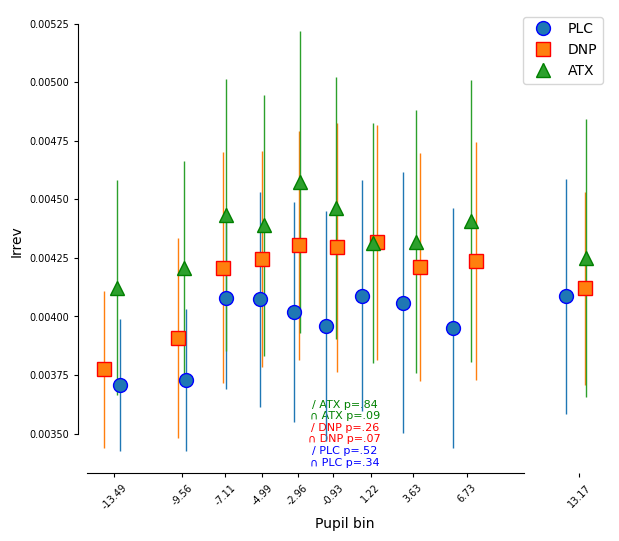

In [9]:
behavior['irrev'] = behavior['bl_pupil']
cfg = {'n_bins': 10}  # Number of pupil bins

def process_behavior(behavior, drug):
    behavior = behavior[(behavior['drug'] == drug)]
    
    behavior['irreversibility_bin'] = behavior.groupby(['subject', 'session', 'block'])['irrev'].apply(lambda x: pd.qcut(x, cfg['n_bins'], labels=range(cfg['n_bins']))).to_numpy()

    correct_counts = True
    df_sdt_irreversibility = behavior.groupby(['subject', 'drug', 'irreversibility_bin']).apply(lambda x: sdt(x, correct_counts))
    df_sdt_irreversibility['prestim_irrev'] = behavior.groupby(['subject','drug','irreversibility_bin']).mean()['prestim_irrev']
    df_subject_irreversibility = df_sdt_irreversibility.groupby(['subject', 'irreversibility_bin']).mean()
    df_subject_irreversibility.reset_index(inplace=True)
    
    # Calculate the mean of each bin for x-axis labels
    bin_means = behavior.groupby('irreversibility_bin').mean()['irrev']
    print("Drug: " + drug)
    print("Bin means: " + str(bin_means))
    
    return df_subject_irreversibility, bin_means

# Process data for PLC
df_subject_irreversibility_plc, bin_means_plc = process_behavior(behavior, 'PLC')

# Process data for DNP
df_subject_irreversibility_dnp, bin_means_dnp = process_behavior(behavior, 'DNP')

# Process data for ATX
df_subject_irreversibility_atx, bin_means_atx = process_behavior(behavior, 'ATX')

total_bin_means = (bin_means_plc + bin_means_dnp + bin_means_atx) / 3

# Combine all data
df_combined = pd.concat([
    df_subject_irreversibility_plc.assign(drug='PLC', bin_mean=bin_means_plc[df_subject_irreversibility_plc['irreversibility_bin']].values),
    df_subject_irreversibility_dnp.assign(drug='DNP', bin_mean=bin_means_dnp[df_subject_irreversibility_dnp['irreversibility_bin']].values),
    df_subject_irreversibility_atx.assign(drug='ATX', bin_mean=bin_means_atx[df_subject_irreversibility_atx['irreversibility_bin']].values)
])

# Initialize variables to decide which model to plot
plot_linear_plc = False
plot_quadratic_plc = False
plot_linear_dnp = False
plot_quadratic_dnp = False
plot_linear_atx = False
plot_quadratic_atx = False

# Calculate betas for PLC
betas_first_irreversibility_plc = dict()
_, betas_first_irreversibility_plc['prestim_irrev'] = sp.stats.ttest_1samp(df_subject_irreversibility_plc.groupby(['subject']).apply(run_model_irrevbin, 1, 'prestim_irrev'), 0)

betas_second_irreversibility_plc = dict()
_, betas_second_irreversibility_plc['prestim_irrev'] = sp.stats.ttest_1samp(df_subject_irreversibility_plc.groupby(['subject']).apply(run_model_irrevbin, 2, 'prestim_irrev'), 0)

# Calculate betas for DNP
betas_first_irreversibility_dnp = dict()
_, betas_first_irreversibility_dnp['prestim_irrev'] = sp.stats.ttest_1samp(df_subject_irreversibility_dnp.groupby(['subject']).apply(run_model_irrevbin, 1, 'prestim_irrev'), 0)

betas_second_irreversibility_dnp = dict()
_, betas_second_irreversibility_dnp['prestim_irrev'] = sp.stats.ttest_1samp(df_subject_irreversibility_dnp.groupby(['subject']).apply(run_model_irrevbin, 2, 'prestim_irrev'), 0)

# Calculate betas for ATX
betas_first_irreversibility_atx = dict()
_, betas_first_irreversibility_atx['prestim_irrev'] = sp.stats.ttest_1samp(df_subject_irreversibility_atx.groupby(['subject']).apply(run_model_irrevbin, 1, 'prestim_irrev'), 0)

betas_second_irreversibility_atx = dict()
_, betas_second_irreversibility_atx['prestim_irrev'] = sp.stats.ttest_1samp(df_subject_irreversibility_atx.groupby(['subject']).apply(run_model_irrevbin, 2, 'prestim_irrev'), 0)

# Determine which model to plot for PLC based on the significance and smaller p-value
if betas_first_irreversibility_plc['prestim_irrev'] < 0.05 or betas_second_irreversibility_plc['prestim_irrev'] < 0.05:
    if betas_first_irreversibility_plc['prestim_irrev'] < betas_second_irreversibility_plc['prestim_irrev']:
        plot_linear_plc = True
    elif betas_second_irreversibility_plc['prestim_irrev'] < betas_first_irreversibility_plc['prestim_irrev']:
        plot_quadratic_plc = True

# Determine which model to plot for DNP based on the significance and smaller p-value
if betas_first_irreversibility_dnp['prestim_irrev'] < 0.05 or betas_second_irreversibility_dnp['prestim_irrev'] < 0.05:
    if betas_first_irreversibility_dnp['prestim_irrev'] < betas_second_irreversibility_dnp['prestim_irrev']:
        plot_linear_dnp = True
    elif betas_second_irreversibility_dnp['prestim_irrev'] < betas_first_irreversibility_dnp['prestim_irrev']:
        plot_quadratic_dnp = True

# Determine which model to plot for ATX based on the significance and smaller p-value
if betas_first_irreversibility_atx['prestim_irrev'] < 0.05 or betas_second_irreversibility_atx['prestim_irrev'] < 0.05:
    if betas_first_irreversibility_atx['prestim_irrev'] < betas_second_irreversibility_atx['prestim_irrev']:
        plot_linear_atx = True
    elif betas_second_irreversibility_atx['prestim_irrev'] < betas_first_irreversibility_atx['prestim_irrev']:
        plot_quadratic_atx = True

# Plotting results for prestim_irrev'
cm = 1 / 2.54  # Conversion factor to cm
fig, ax = plt.subplots(figsize=(16*cm, 14*cm))

# PLC data
ym_plc = df_subject_irreversibility_plc.groupby('irreversibility_bin').mean()['prestim_irrev']
yerr_plc = df_subject_irreversibility_plc.groupby('irreversibility_bin').sem()['prestim_irrev']
ax.errorbar(bin_means_plc, ym_plc, yerr=yerr_plc, capsize=0, ls='None', marker='o', alpha=1, zorder=1000, ms=10, mew=1, elinewidth=1, markeredgecolor='b', label='PLC')

# DNP data
ym_dnp = df_subject_irreversibility_dnp.groupby('irreversibility_bin').mean()['prestim_irrev']
yerr_dnp = df_subject_irreversibility_dnp.groupby('irreversibility_bin').sem()['prestim_irrev']
ax.errorbar(bin_means_dnp, ym_dnp, yerr=yerr_dnp, capsize=0, ls='None', marker='s', alpha=1, zorder=1000, ms=10, mew=1, elinewidth=1, markeredgecolor='r', label='DNP')

# ATX data
ym_atx = df_subject_irreversibility_atx.groupby('irreversibility_bin').mean()['prestim_irrev']
yerr_atx = df_subject_irreversibility_atx.groupby('irreversibility_bin').sem()['prestim_irrev']
ax.errorbar(bin_means_atx, ym_atx, yerr=yerr_atx, capsize=0, ls='None', marker='^', alpha=1, zorder=1000, ms=10, mew=1, elinewidth=1, markeredgecolor='g', label='ATX')

# Plot linear/quadratic fit for each drug
def plot_fit(ax, df, color, linestyle, order):
    sns.regplot(ax=ax, data=df, x="bin_mean", y="prestim_irrev", scatter=False, color=color,
                line_kws={'linestyle': linestyle, 'lw': 1}, order=order, ci=68)

# Optionally add model fits if linear/quadratic fit was significant for PLC
if plot_linear_plc:
    plot_fit(ax, df_combined[df_combined['drug'] == 'PLC'], 'b', '-', 1)
if plot_quadratic_plc:
    plot_fit(ax, df_combined[df_combined['drug'] == 'PLC'], 'b', '-', 2)

# Optionally add model fits if linear/quadratic fit was significant for DNP
if plot_linear_dnp:
    plot_fit(ax, df_combined[df_combined['drug'] == 'DNP'], 'r', '--', 1)
if plot_quadratic_dnp:
    plot_fit(ax, df_combined[df_combined['drug'] == 'DNP'], 'r', '--', 2)

# Optionally add model fits if linear/quadratic fit was significant for ATX
if plot_linear_atx:
    plot_fit(ax, df_combined[df_combined['drug'] == 'ATX'], 'g', ':', 1)
if plot_quadratic_atx:
    plot_fit(ax, df_combined[df_combined['drug'] == 'ATX'], 'g', ':', 2)

# Plot p-values for the polynomial regression significance
ax.text(0.5, 0.01, '/ PLC {}\n∩ PLC {}'.format(p_val_string(betas_first_irreversibility_plc['prestim_irrev']),
                                               p_val_string(betas_second_irreversibility_plc['prestim_irrev'])), ha='center', va='bottom', transform=ax.transAxes, size=8, color='b')

ax.text(0.5, 0.06, '/ DNP {}\n∩ DNP {}'.format(p_val_string(betas_first_irreversibility_dnp['prestim_irrev']),
                                               p_val_string(betas_second_irreversibility_dnp['prestim_irrev'])), ha='center', va='bottom', transform=ax.transAxes, size=8, color='r')

ax.text(0.5, 0.11, '/ ATX {}\n∩ ATX {}'.format(p_val_string(betas_first_irreversibility_atx['prestim_irrev']),
                                               p_val_string(betas_second_irreversibility_atx['prestim_irrev'])), ha='center', va='bottom', transform=ax.transAxes, size=8, color='g')

sns.despine(ax=ax, offset=1, trim=True)

# Setting labels and titles
ax.set_ylabel('Irrev')
ax.set_xlabel('Pupil bin')

labels = []
for i in range(cfg['n_bins']):
    labels.append(f"{total_bin_means[i]:.2f}")

ax.set_xticks(total_bin_means)
ax.set_xticklabels(labels, rotation=45)
ax.tick_params(axis='both', which='major', labelsize=7, length=3)

ax.legend()
fig.tight_layout()
plt.show()


# Poststim all taus..

In [5]:
project_directory = os.path.dirname(os.path.dirname(os.path.abspath("clean_analysis_dataset2")))
base_directory = os.path.join(project_directory, r"data", r"fr_results new dataset")

df = pd.read_csv(os.path.join(project_directory, r"data", r"eNeuro_data", r"behavior_eNeuro.csv"))

# Loop through tau1 to tau15
for i in range(1, 16):
    # Construct the filename dynamically
    file_name_pre = f"FowRev_prestimulus_tau{i}.mat"
    file_name_post = f"FowRev_poststimulus_tau{i}.mat"
    file_path_pre = os.path.join(base_directory, file_name_pre)
    file_path_post = os.path.join(base_directory, file_name_post)   
    # Extract and flatten the 'FowRev' array, assigning it to a new column in the DataFrame
    df[f'prestim_irrev_tau{i}'] = np.log(scipy.io.loadmat(file_path_pre)['FowRev'].flatten())
    df[f'poststim_irrev_tau{i}'] = np.log(scipy.io.loadmat(file_path_post)['FowRev'].flatten())

df['prestim_irrev_tau20'] = np.log(scipy.io.loadmat(os.path.join(os.path.join(base_directory, r"FowRev_prestimulus_tau20.mat")))['FowRev'].flatten())
df['prestim_irrev_tau25'] = np.log(scipy.io.loadmat(os.path.join(os.path.join(base_directory, r"FowRev_prestimulus_tau20.mat")))['FowRev'].flatten())    
df['poststim_irrev_tau20'] = np.log(scipy.io.loadmat(os.path.join(os.path.join(base_directory, r"FowRev_poststimulus_tau20.mat")))['FowRev'].flatten())
df['poststim_irrev_tau25'] = np.log(scipy.io.loadmat(os.path.join(os.path.join(base_directory, r"FowRev_poststimulus_tau20.mat")))['FowRev'].flatten())
df.head()

,Unnamed: 0,subject,drug,session,block,miniblock,trial_nr,total_trial,stimulus,response,...,prestim_irrev_tau13,poststim_irrev_tau13,prestim_irrev_tau14,poststim_irrev_tau14,prestim_irrev_tau15,poststim_irrev_tau15,prestim_irrev_tau20,prestim_irrev_tau25,poststim_irrev_tau20,poststim_irrev_tau25
0,0,1,DNP,0,0,0.0,0.0,0,0.0,0.0,...,-5.245760,-5.265717,-5.307385,-5.276359,-5.396735,-5.219894,-5.077711,-5.077711,-5.222607,-5.222607
1,1,1,DNP,0,0,0.0,1.0,1,0.0,0.0,...,-4.907095,-5.909631,-4.143300,-5.913362,-4.488004,-5.713496,-4.050860,-4.050860,-5.444406,-5.444406
2,2,1,DNP,0,0,0.0,2.0,2,0.0,0.0,...,-5.064131,-5.563867,-4.242677,-5.544044,-4.195585,-5.386302,-4.200719,-4.200719,-4.909908,-4.909908
3,3,1,DNP,0,0,0.0,3.0,3,0.0,0.0,...,-5.282118,-6.050617,-4.632629,-5.700151,-4.881028,-5.439364,-4.543148,-4.543148,-5.231880,-5.231880
4,4,1,DNP,0,0,0.0,5.0,4,1.0,1.0,...,-5.357597,-5.478338,-5.496886,-5.367630,-4.993894,-5.437367,-5.304850,-5.304850,-5.888212,-5.888212


## by drug

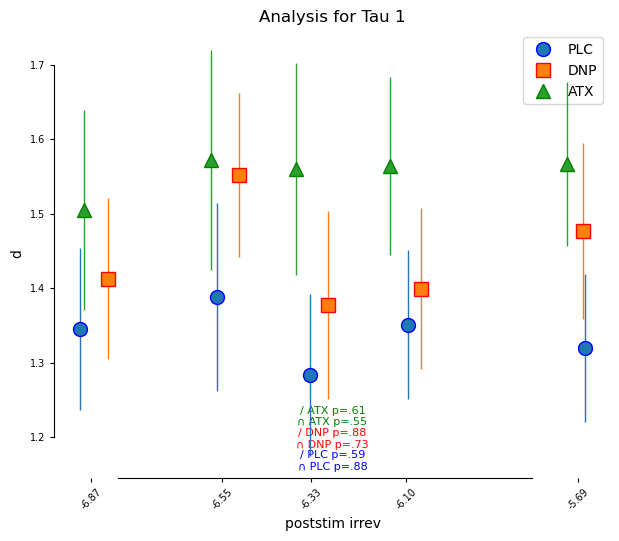

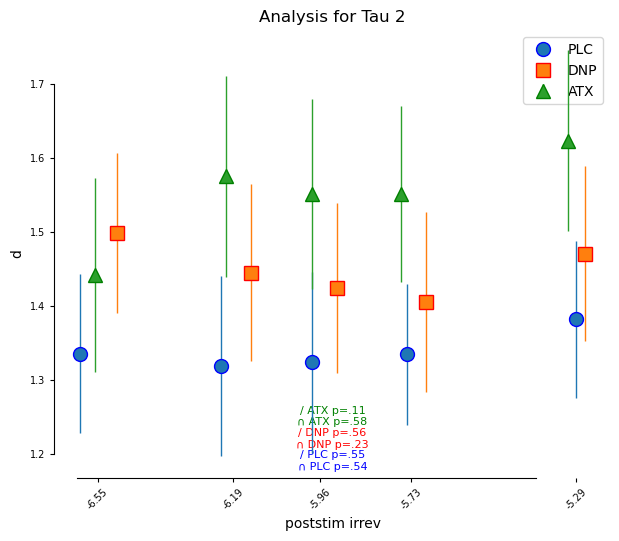

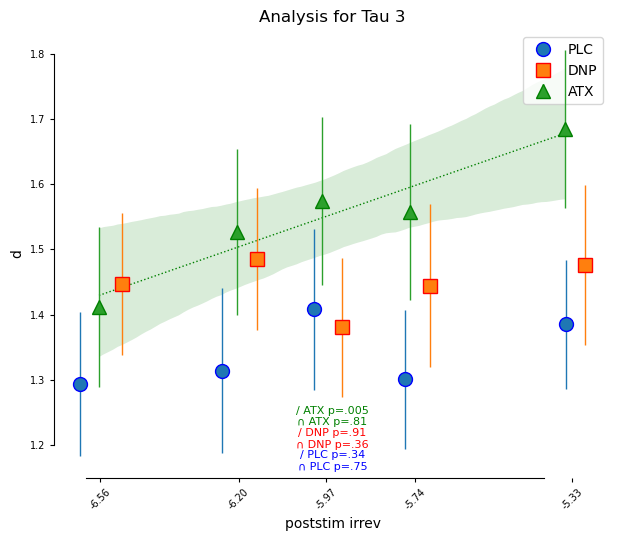

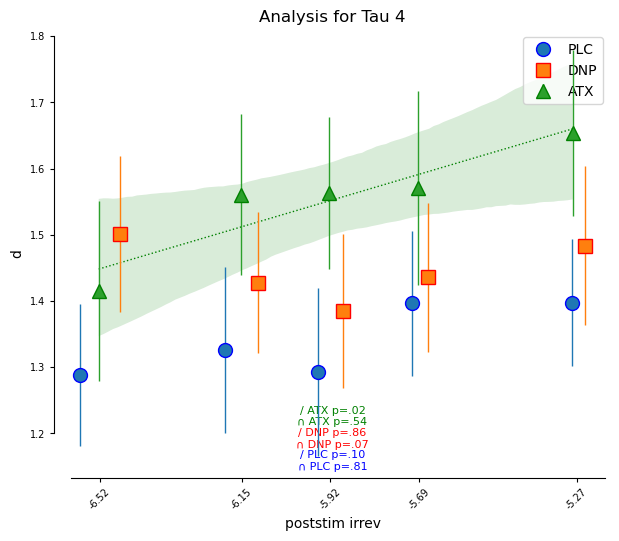

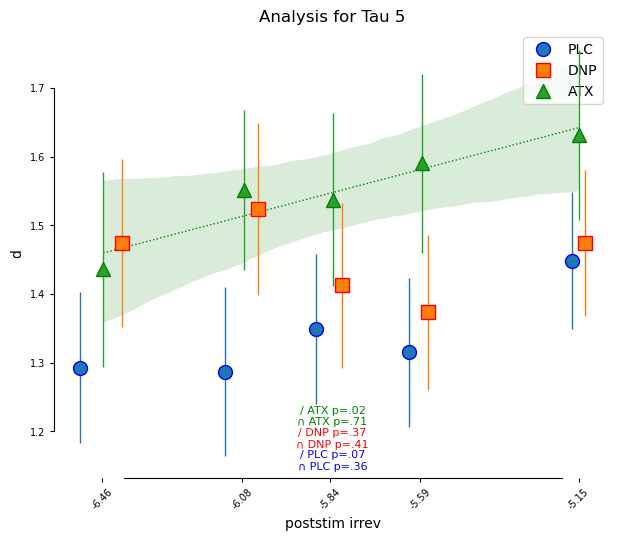

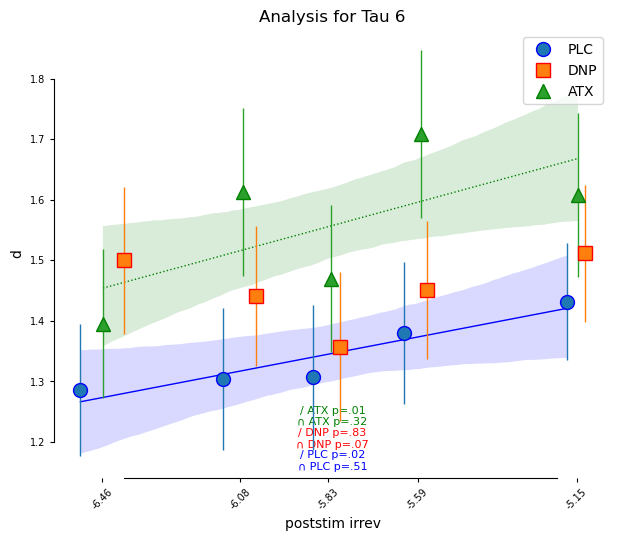

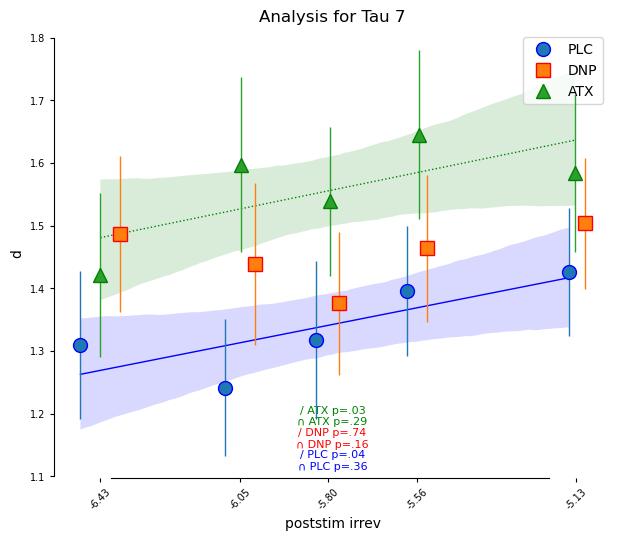

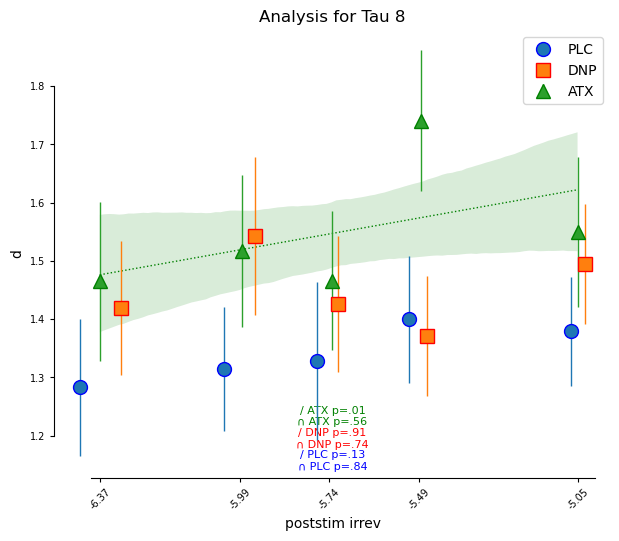

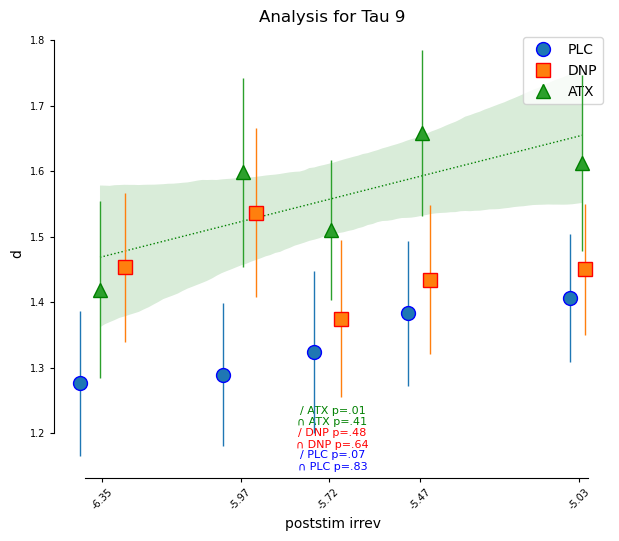

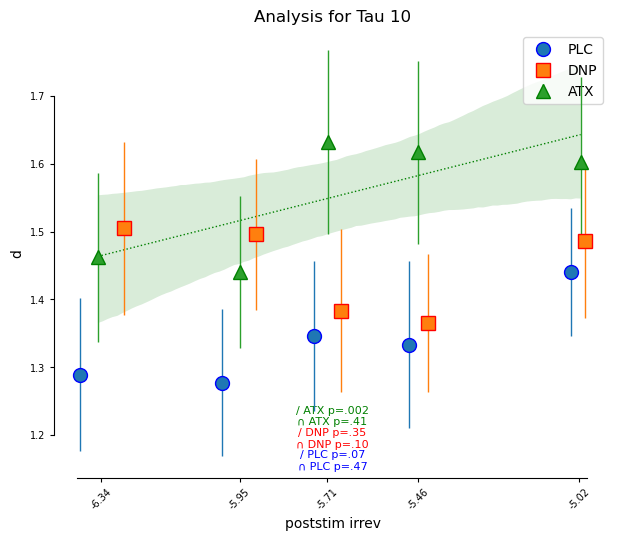

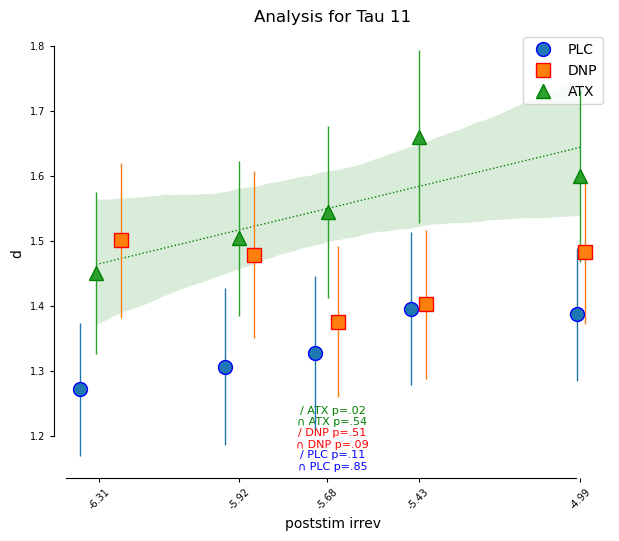

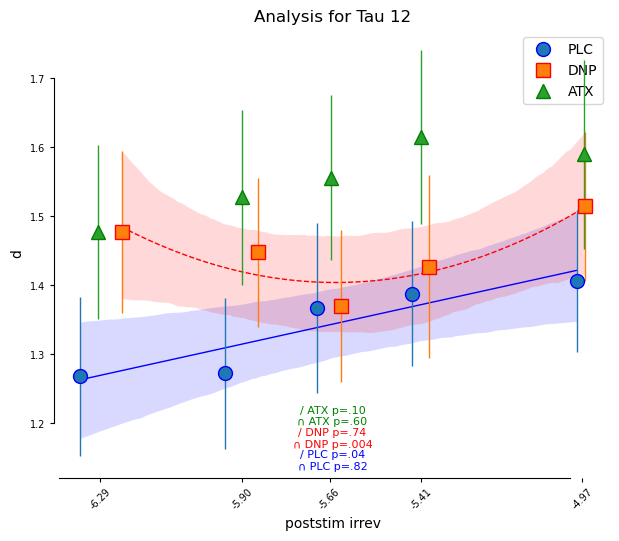

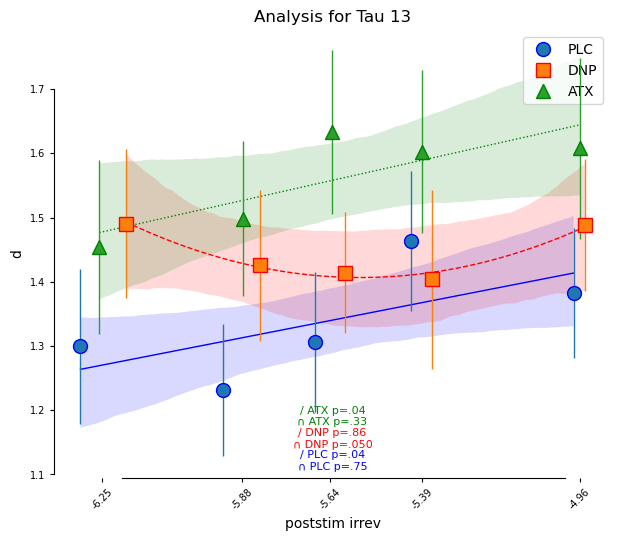

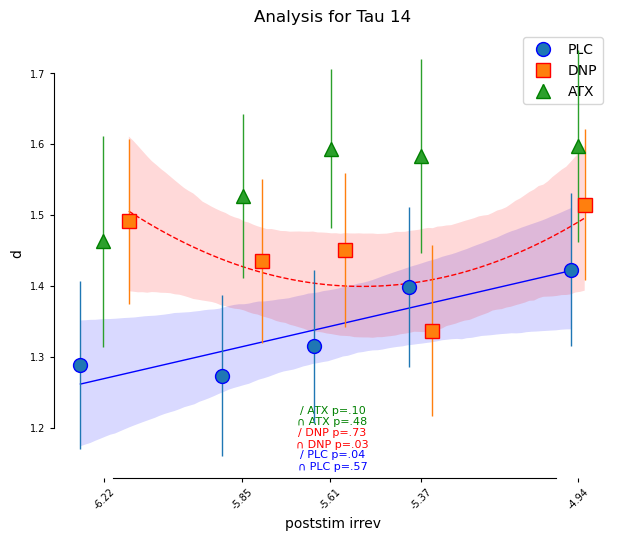

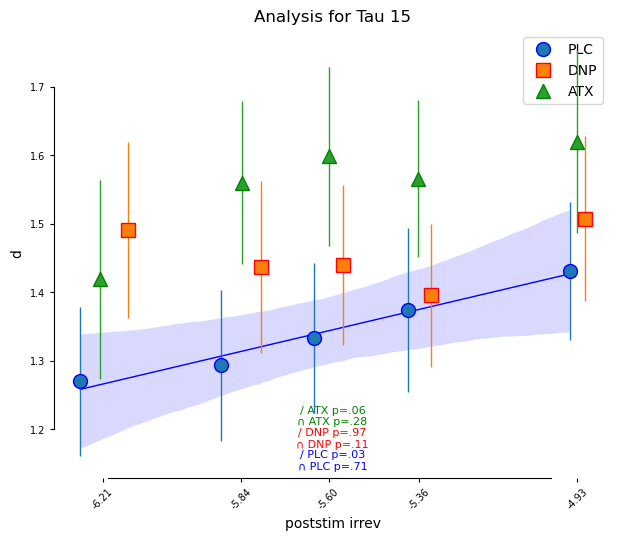

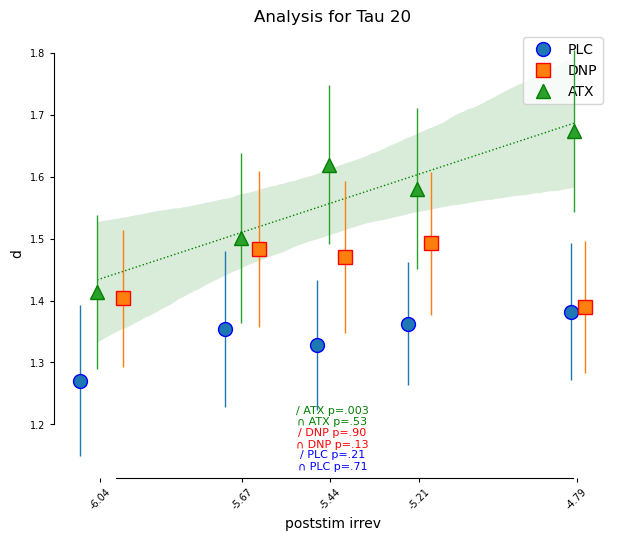

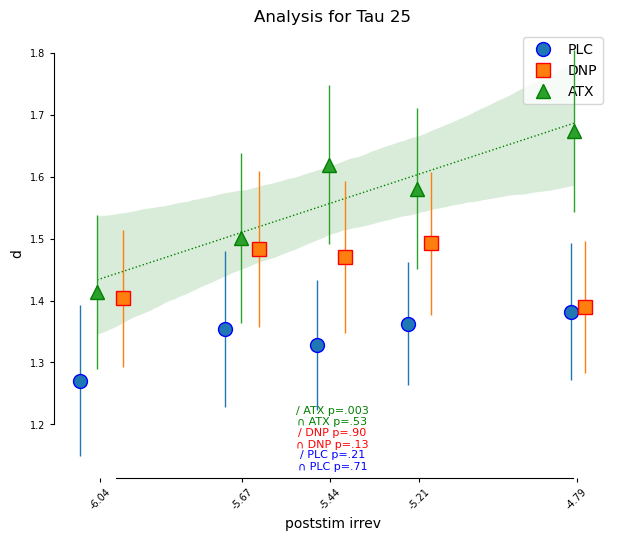

In [14]:
# Process each tau column dynamically
import warnings
warnings.filterwarnings("ignore")

def process_behavior(behavior, drug):
    behavior = behavior[(behavior['drug'] == drug)]
    
    behavior['irreversibility_bin'] = behavior.groupby(['subject', 'session', 'block'])['irrev'].apply(lambda x: pd.qcut(x, cfg['n_bins'], labels=range(cfg['n_bins']))).to_numpy()

    correct_counts = True
    df_sdt_irreversibility = behavior.groupby(['subject', 'drug', 'irreversibility_bin']).apply(lambda x: sdt(x, correct_counts))
    
    df_subject_irreversibility = df_sdt_irreversibility.groupby(['subject', 'irreversibility_bin']).mean()
    df_subject_irreversibility.reset_index(inplace=True)
    
    # Calculate the mean of each bin for x-axis labels
    bin_means = behavior.groupby('irreversibility_bin').mean()['irrev']
    #print("Drug: " + drug)
    #print("Bin means: " + str(bin_means))
    
    return df_subject_irreversibility, bin_means

cfg = {'n_bins': 5}
cm = 1 / 2.54 

for tau in list(range(1, 16)) + [20, 25]:
    tau_col = f'poststim_irrev_tau{tau}'  # Tau column name
    
    # Filter and process the DataFrame for the current tau
    behavior = df.copy()
    #behavior = behavior[(behavior[tau_col] < 0.075)]
    behavior['irrev'] = behavior[tau_col]

    # Process data for each drug
    df_subject_irreversibility_plc, bin_means_plc = process_behavior(behavior, 'PLC')
    df_subject_irreversibility_dnp, bin_means_dnp = process_behavior(behavior, 'DNP')
    df_subject_irreversibility_atx, bin_means_atx = process_behavior(behavior, 'ATX')

    # Combine bin means
    total_bin_means = (bin_means_plc + bin_means_dnp + bin_means_atx) / 3

    # Combine data for plotting
    df_combined = pd.concat([
        df_subject_irreversibility_plc.assign(drug='PLC', bin_mean=bin_means_plc[df_subject_irreversibility_plc['irreversibility_bin']].values),
        df_subject_irreversibility_dnp.assign(drug='DNP', bin_mean=bin_means_dnp[df_subject_irreversibility_dnp['irreversibility_bin']].values),
        df_subject_irreversibility_atx.assign(drug='ATX', bin_mean=bin_means_atx[df_subject_irreversibility_atx['irreversibility_bin']].values)
    ])

    # Plotting
    # Initialize variables to decide which model to plot
    plot_linear_plc = False
    plot_quadratic_plc = False
    plot_linear_dnp = False
    plot_quadratic_dnp = False
    plot_linear_atx = False
    plot_quadratic_atx = False

    # Calculate betas for PLC
    betas_first_irreversibility_plc = dict()
    _, betas_first_irreversibility_plc['d'] = sp.stats.ttest_1samp(df_subject_irreversibility_plc.groupby(['subject']).apply(run_model_irrevbin, 1, 'd'), 0)

    betas_second_irreversibility_plc = dict()
    _, betas_second_irreversibility_plc['d'] = sp.stats.ttest_1samp(df_subject_irreversibility_plc.groupby(['subject']).apply(run_model_irrevbin, 2, 'd'), 0)

    # Calculate betas for DNP
    betas_first_irreversibility_dnp = dict()
    _, betas_first_irreversibility_dnp['d'] = sp.stats.ttest_1samp(df_subject_irreversibility_dnp.groupby(['subject']).apply(run_model_irrevbin, 1, 'd'), 0)

    betas_second_irreversibility_dnp = dict()
    _, betas_second_irreversibility_dnp['d'] = sp.stats.ttest_1samp(df_subject_irreversibility_dnp.groupby(['subject']).apply(run_model_irrevbin, 2, 'd'), 0)

    # Calculate betas for ATX
    betas_first_irreversibility_atx = dict()
    _, betas_first_irreversibility_atx['d'] = sp.stats.ttest_1samp(df_subject_irreversibility_atx.groupby(['subject']).apply(run_model_irrevbin, 1, 'd'), 0)

    betas_second_irreversibility_atx = dict()
    _, betas_second_irreversibility_atx['d'] = sp.stats.ttest_1samp(df_subject_irreversibility_atx.groupby(['subject']).apply(run_model_irrevbin, 2, 'd'), 0)

    # Determine which model to plot for PLC based on the significance and smaller p-value
    if betas_first_irreversibility_plc['d'] < 0.05 or betas_second_irreversibility_plc['d'] < 0.05:
        if betas_first_irreversibility_plc['d'] < betas_second_irreversibility_plc['d']:
            plot_linear_plc = True
        elif betas_second_irreversibility_plc['d'] < betas_first_irreversibility_plc['d']:
            plot_quadratic_plc = True

    # Determine which model to plot for DNP based on the significance and smaller p-value
    if betas_first_irreversibility_dnp['d'] < 0.05 or betas_second_irreversibility_dnp['d'] < 0.05:
        if betas_first_irreversibility_dnp['d'] < betas_second_irreversibility_dnp['d']:
            plot_linear_dnp = True
        elif betas_second_irreversibility_dnp['d'] < betas_first_irreversibility_dnp['d']:
            plot_quadratic_dnp = True

    # Determine which model to plot for ATX based on the significance and smaller p-value
    if betas_first_irreversibility_atx['d'] < 0.05 or betas_second_irreversibility_atx['d'] < 0.05:
        if betas_first_irreversibility_atx['d'] < betas_second_irreversibility_atx['d']:
            plot_linear_atx = True
        elif betas_second_irreversibility_atx['d'] < betas_first_irreversibility_atx['d']:
            plot_quadratic_atx = True

    # Plotting results for log_poststim'
    cm = 1 / 2.54  # Conversion factor to cm
    fig, ax = plt.subplots(figsize=(16*cm, 14*cm))

    # PLC data
    ym_plc = df_subject_irreversibility_plc.groupby('irreversibility_bin').mean()['d']
    yerr_plc = df_subject_irreversibility_plc.groupby('irreversibility_bin').sem()['d']
    ax.errorbar(bin_means_plc, ym_plc, yerr=yerr_plc, capsize=0, ls='None', marker='o', alpha=1, zorder=1000, ms=10, mew=1, elinewidth=1, markeredgecolor='b', label='PLC')

    # DNP data
    ym_dnp = df_subject_irreversibility_dnp.groupby('irreversibility_bin').mean()['d']
    yerr_dnp = df_subject_irreversibility_dnp.groupby('irreversibility_bin').sem()['d']
    ax.errorbar(bin_means_dnp, ym_dnp, yerr=yerr_dnp, capsize=0, ls='None', marker='s', alpha=1, zorder=1000, ms=10, mew=1, elinewidth=1, markeredgecolor='r', label='DNP')

    # ATX data
    ym_atx = df_subject_irreversibility_atx.groupby('irreversibility_bin').mean()['d']
    yerr_atx = df_subject_irreversibility_atx.groupby('irreversibility_bin').sem()['d']
    ax.errorbar(bin_means_atx, ym_atx, yerr=yerr_atx, capsize=0, ls='None', marker='^', alpha=1, zorder=1000, ms=10, mew=1, elinewidth=1, markeredgecolor='g', label='ATX')

    # Plot linear/quadratic fit for each drug
    def plot_fit(ax, df, color, linestyle, order):
        sns.regplot(ax=ax, data=df, x="bin_mean", y="d", scatter=False, color=color,
                    line_kws={'linestyle': linestyle, 'lw': 1}, order=order, ci=68)

    # Optionally add model fits if linear/quadratic fit was significant for PLC
    if plot_linear_plc:
        plot_fit(ax, df_combined[df_combined['drug'] == 'PLC'], 'b', '-', 1)
    if plot_quadratic_plc:
        plot_fit(ax, df_combined[df_combined['drug'] == 'PLC'], 'b', '-', 2)

    # Optionally add model fits if linear/quadratic fit was significant for DNP
    if plot_linear_dnp:
        plot_fit(ax, df_combined[df_combined['drug'] == 'DNP'], 'r', '--', 1)
    if plot_quadratic_dnp:
        plot_fit(ax, df_combined[df_combined['drug'] == 'DNP'], 'r', '--', 2)

    # Optionally add model fits if linear/quadratic fit was significant for ATX
    if plot_linear_atx:
        plot_fit(ax, df_combined[df_combined['drug'] == 'ATX'], 'g', ':', 1)
    if plot_quadratic_atx:
        plot_fit(ax, df_combined[df_combined['drug'] == 'ATX'], 'g', ':', 2)

    # Plot p-values for the polynomial regression significance
    ax.text(0.5, 0.01, '/ PLC {}\n∩ PLC {}'.format(p_val_string(betas_first_irreversibility_plc['d']),
                                                p_val_string(betas_second_irreversibility_plc['d'])), ha='center', va='bottom', transform=ax.transAxes, size=8, color='b')

    ax.text(0.5, 0.06, '/ DNP {}\n∩ DNP {}'.format(p_val_string(betas_first_irreversibility_dnp['d']),
                                                p_val_string(betas_second_irreversibility_dnp['d'])), ha='center', va='bottom', transform=ax.transAxes, size=8, color='r')

    ax.text(0.5, 0.11, '/ ATX {}\n∩ ATX {}'.format(p_val_string(betas_first_irreversibility_atx['d']),
                                                p_val_string(betas_second_irreversibility_atx['d'])), ha='center', va='bottom', transform=ax.transAxes, size=8, color='g')

    sns.despine(ax=ax, offset=1, trim=True)

    # Setting labels and titles
    ax.set_ylabel('d')
    ax.set_xlabel('poststim irrev')
    ax.set_title(f'Poststim Analysis for Tau {tau}')

    labels = []
    for i in range(cfg['n_bins']):
        labels.append(f"{total_bin_means[i]:.2f}")

    ax.set_xticks(total_bin_means)
    ax.set_xticklabels(labels, rotation=45)
    ax.tick_params(axis='both', which='major', labelsize=7, length=3)

    ax.legend()
    fig.tight_layout()
    plt.show()



## drugs collapsed


Tau: 1
irreversibility_bin
0   -6.866929
1   -6.549443
2   -6.333983
3   -6.104118
4   -5.688418
Name: poststim_irrev_tau1, dtype: float64


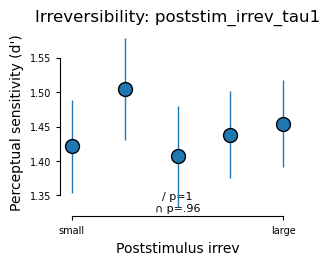


Tau: 2
irreversibility_bin
0   -6.545542
1   -6.192190
2   -5.963685
3   -5.725837
4   -5.295143
Name: poststim_irrev_tau2, dtype: float64


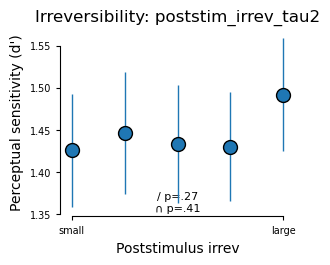


Tau: 3
irreversibility_bin
0   -6.562636
1   -6.200315
2   -5.970639
3   -5.737608
4   -5.326880
Name: poststim_irrev_tau3, dtype: float64


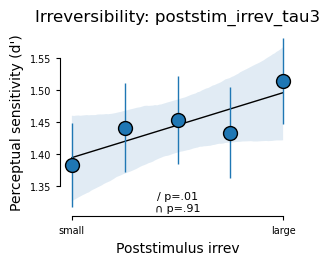


Tau: 4
irreversibility_bin
0   -6.524967
1   -6.152800
2   -5.921048
3   -5.686551
4   -5.274674
Name: poststim_irrev_tau4, dtype: float64


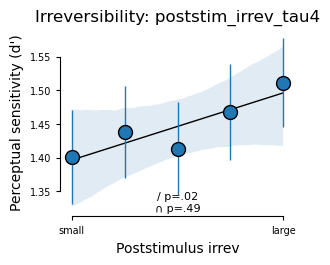


Tau: 5
irreversibility_bin
0   -6.461076
1   -6.076801
2   -5.835328
3   -5.589288
4   -5.153961
Name: poststim_irrev_tau5, dtype: float64


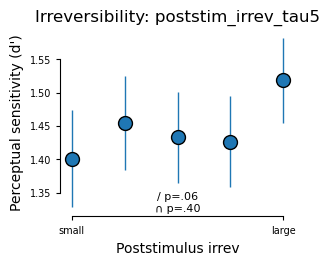


Tau: 6
irreversibility_bin
0   -6.460370
1   -6.077861
2   -5.834586
3   -5.587399
4   -5.147228
Name: poststim_irrev_tau6, dtype: float64


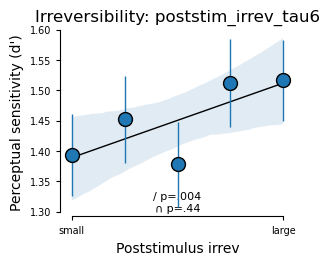


Tau: 7
irreversibility_bin
0   -6.428502
1   -6.045358
2   -5.804603
3   -5.560343
4   -5.125644
Name: poststim_irrev_tau7, dtype: float64


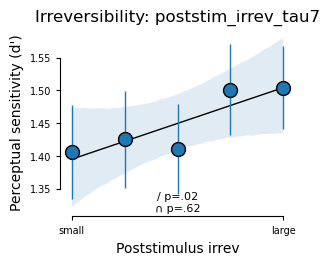


Tau: 8
irreversibility_bin
0   -6.373830
1   -5.985413
2   -5.738793
3   -5.489192
4   -5.048422
Name: poststim_irrev_tau8, dtype: float64


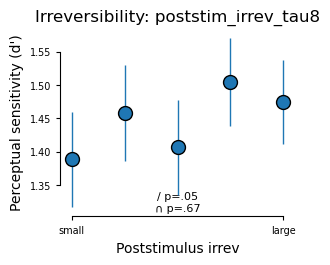


Tau: 9
irreversibility_bin
0   -6.354812
1   -5.968437
2   -5.723319
3   -5.469401
4   -5.026127
Name: poststim_irrev_tau9, dtype: float64


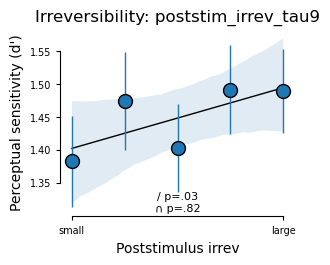


Tau: 10
irreversibility_bin
0   -6.336399
1   -5.955040
2   -5.713510
3   -5.463469
4   -5.022389
Name: poststim_irrev_tau10, dtype: float64


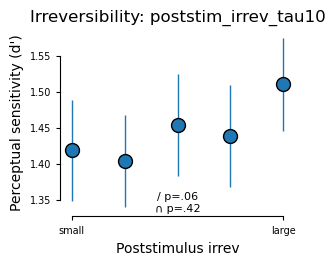


Tau: 11
irreversibility_bin
0   -6.310120
1   -5.925195
2   -5.684066
3   -5.433228
4   -4.988470
Name: poststim_irrev_tau11, dtype: float64


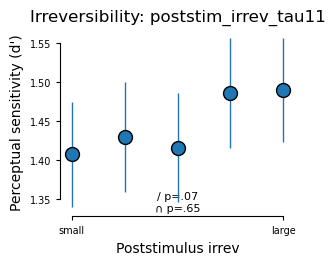


Tau: 12
irreversibility_bin
0   -6.289267
1   -5.900477
2   -5.659817
3   -5.409907
4   -4.969222
Name: poststim_irrev_tau12, dtype: float64


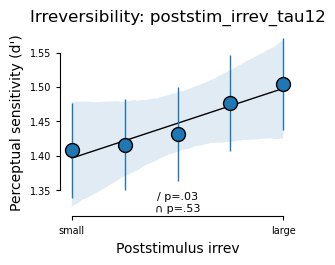


Tau: 13
irreversibility_bin
0   -6.255141
1   -5.875903
2   -5.635917
3   -5.388270
4   -4.961184
Name: poststim_irrev_tau13, dtype: float64


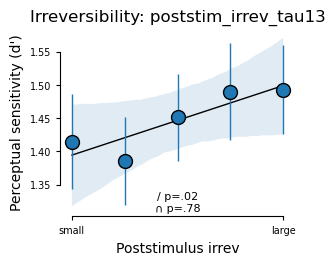


Tau: 14
irreversibility_bin
0   -6.224924
1   -5.849834
2   -5.611967
3   -5.365909
4   -4.939383
Name: poststim_irrev_tau14, dtype: float64


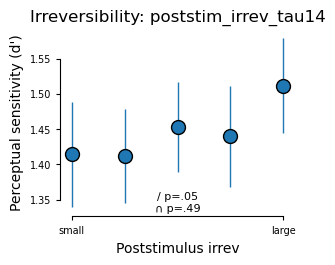


Tau: 15
irreversibility_bin
0   -6.214533
1   -5.839227
2   -5.602927
3   -5.358942
4   -4.930889
Name: poststim_irrev_tau15, dtype: float64


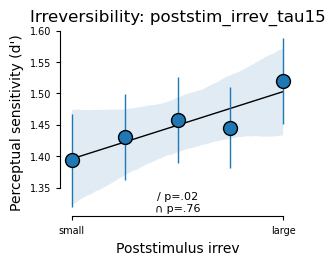


Tau: 20
irreversibility_bin
0   -6.041305
1   -5.669054
2   -5.438309
3   -5.205342
4   -4.791536
Name: poststim_irrev_tau20, dtype: float64


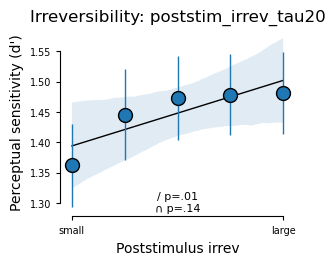


Tau: 25
irreversibility_bin
0   -6.041305
1   -5.669054
2   -5.438309
3   -5.205342
4   -4.791536
Name: poststim_irrev_tau25, dtype: float64


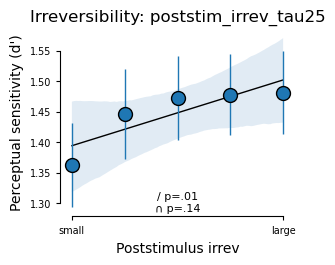

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

# List of tau values for the poststimulus irreversibility columns
taus = list(range(1, 16)) + [20, 25]
cfg = {'n_bins': 5}  # Number of pupil bins

for tau in taus:
    # Create a working copy of the data and define the tau-specific column name
    behavior = df.copy()
    tau_col = f'poststim_irrev_tau{tau}'
    
    # Replace the generic "poststim_irrev" column with the tau-specific column
    behavior['poststim_irrev'] = behavior[tau_col]
    
    # Sort the DataFrame by subject, session, and block (for binning)
    df_group = behavior.sort_values(by=['subject', 'session', 'block'])
    
    # Create quantile-based bins for the current tau column.
    # The bins are created separately within each (subject, session, block) group.
    df_group['irreversibility_bin'] = np.concatenate(
        np.ravel(
            df_group.groupby(['subject', 'session', 'block'])['poststim_irrev']
            .agg(lambda x: list(pd.qcut(x, cfg['n_bins'], labels=range(cfg['n_bins']))))
        )
    )
    
    # Compute SDT parameters (using your sdt function) per subject, drug, and bin.
    correct_counts = True
    df_sdt_irreversibility = df_group.groupby(['subject', 'drug', 'irreversibility_bin']) \
                                      .apply(lambda x: sdt(x, correct_counts))
    
    # Collapse across drugs to compute subject-level means for each bin.
    df_subject_irreversibility = df_sdt_irreversibility.groupby(['subject', 'irreversibility_bin']).mean()
    df_subject_irreversibility.reset_index(inplace=True)
    
    # (Optional) Print the group-level mean of the current tau column for each bin.
    print(f"\nTau: {tau}")
    print(df_group.groupby('irreversibility_bin').mean()[tau_col])
    
    # Run model fits on the binned data for each subject.
    # These functions are assumed to output a regression coefficient (or similar) for 'd'.
    betas_first_irreversibility = dict()
    _, betas_first_irreversibility['d'] = sp.stats.ttest_1samp(
        df_subject_irreversibility.groupby('subject').apply(run_model_irrevbin, 1, 'd'),
        0
    )
    
    betas_second_irreversibility = dict()
    _, betas_second_irreversibility['d'] = sp.stats.ttest_1samp(
        df_subject_irreversibility.groupby('subject').apply(run_model_irrevbin, 2, 'd'),
        0
    )
    
    # Begin plotting the results for perceptual sensitivity (d')
    cm = 1 / 2.54  # Conversion factor to cm for figure sizing
    fig, ax = plt.subplots(figsize=(8 * cm, 7 * cm))
    
    # Compute mean and standard error (SEM) for each bin (across subjects)
    ym = df_sdt_irreversibility.groupby('irreversibility_bin').mean()['d']
    yerr = df_sdt_irreversibility.groupby('irreversibility_bin').sem()['d']
    
    ax.errorbar(range(cfg['n_bins']), ym, yerr=yerr, capsize=0, ls='None', marker='o',
                alpha=1, zorder=1000, ms=10, mew=1, elinewidth=1, markeredgecolor='k')
    
    # Get p-values from the regression tests for linear and quadratic fits.
    p_val_linear = betas_first_irreversibility['d']
    p_val_quadratic = betas_second_irreversibility['d']
    
    # Decide which model to plot: choose the model with the lower p-value (if significant)
    plot_linear = False
    plot_quadratic = False
    if (p_val_linear < 0.05) or (p_val_quadratic < 0.05):
        if p_val_linear < p_val_quadratic:
            plot_linear = True
        elif p_val_quadratic < p_val_linear:
            plot_quadratic = True
    
    # Optionally overlay a linear fit if significant
    if plot_linear:
        sns.regplot(ax=ax,
                    data=df_subject_irreversibility,
                    x="irreversibility_bin",
                    y="d",
                    scatter=False,
                    color=sns.color_palette('Set1', 2)[-1],
                    line_kws={'linestyle': '-', 'lw': 1},
                    order=1,
                    ci=68)
        # Set the regression line color to black for clarity.
        ax.get_lines()[-1].set_color('k')
    
    # Optionally overlay a quadratic fit if significant
    if plot_quadratic:
        sns.regplot(ax=ax,
                    data=df_subject_irreversibility,
                    x="irreversibility_bin",
                    y="d",
                    scatter=False,
                    color=sns.color_palette('Set1', 2)[-1],
                    line_kws={'linestyle': '-', 'lw': 1},
                    order=2,
                    ci=68)
        ax.get_lines()[-1].set_color('k')
    
    # Annotate the plot with the formatted p-values from the regression tests.
    ax.text(0.5, 0.01,
            '/ {}\n∩ {}'.format(p_val_string(betas_first_irreversibility['d']),
                                p_val_string(betas_second_irreversibility['d'])),
            ha='center', va='bottom', transform=ax.transAxes, size=8)
    
    sns.despine(ax=ax, offset=1, trim=True)
    
    # Set plot labels and ticks
    ax.set_ylabel("Perceptual sensitivity (d')")
    ax.set_xlabel("Poststimulus irrev")
    ax.set_xticks([0, cfg['n_bins'] - 1])
    ax.set_xticklabels(['small', 'large'])
    ax.tick_params(axis='both', which='major', labelsize=7, length=3)
    
    # Title includes the tau-specific column name for clarity
    ax.set_title(f"Irreversibility: {tau_col}")
    fig.tight_layout()
    plt.show()


# Prestim all taus

In [3]:
project_directory = os.path.dirname(os.path.dirname(os.path.abspath("clean_analysis_dataset2")))
base_directory = os.path.join(project_directory, r"data", r"fr_results new dataset")

df = pd.read_csv(os.path.join(project_directory, r"data", r"eNeuro_data", r"behavior_eNeuro.csv"))

# Loop through tau1 to tau15
for i in range(1, 16):
    # Construct the filename dynamically
    file_name_pre = f"FowRev_prestimulus_tau{i}.mat"
    file_name_post = f"FowRev_poststimulus_tau{i}.mat"
    file_path_pre = os.path.join(base_directory, file_name_pre)
    file_path_post = os.path.join(base_directory, file_name_post)   
    # Extract and flatten the 'FowRev' array, assigning it to a new column in the DataFrame
    df[f'prestim_irrev_tau{i}'] = np.log(scipy.io.loadmat(file_path_pre)['FowRev'].flatten())
    df[f'poststim_irrev_tau{i}'] = np.log(scipy.io.loadmat(file_path_post)['FowRev'].flatten())

df['prestim_irrev_tau20'] = np.log(scipy.io.loadmat(os.path.join(os.path.join(base_directory, r"FowRev_prestimulus_tau20.mat")))['FowRev'].flatten())
df['prestim_irrev_tau25'] = np.log(scipy.io.loadmat(os.path.join(os.path.join(base_directory, r"FowRev_prestimulus_tau25.mat")))['FowRev'].flatten())    
df['poststim_irrev_tau20'] = np.log(scipy.io.loadmat(os.path.join(os.path.join(base_directory, r"FowRev_poststimulus_tau20.mat")))['FowRev'].flatten())
df['poststim_irrev_tau25'] = np.log(scipy.io.loadmat(os.path.join(os.path.join(base_directory, r"FowRev_poststimulus_tau25.mat")))['FowRev'].flatten())
df.head()

,Unnamed: 0,subject,drug,session,block,miniblock,trial_nr,total_trial,stimulus,response,...,prestim_irrev_tau13,poststim_irrev_tau13,prestim_irrev_tau14,poststim_irrev_tau14,prestim_irrev_tau15,poststim_irrev_tau15,prestim_irrev_tau20,prestim_irrev_tau25,poststim_irrev_tau20,poststim_irrev_tau25
0,0,1,DNP,0,0,0.0,0.0,0,0.0,0.0,...,-5.245760,-5.265717,-5.307385,-5.276359,-5.396735,-5.219894,-5.077711,-5.077472,-5.222607,-5.268541
1,1,1,DNP,0,0,0.0,1.0,1,0.0,0.0,...,-4.907095,-5.909631,-4.143300,-5.913362,-4.488004,-5.713496,-4.050860,-4.948384,-5.444406,-5.127373
2,2,1,DNP,0,0,0.0,2.0,2,0.0,0.0,...,-5.064131,-5.563867,-4.242677,-5.544044,-4.195585,-5.386302,-4.200719,-3.930968,-4.909908,-4.886894
3,3,1,DNP,0,0,0.0,3.0,3,0.0,0.0,...,-5.282118,-6.050617,-4.632629,-5.700151,-4.881028,-5.439364,-4.543148,-4.902389,-5.231880,-5.016499
4,4,1,DNP,0,0,0.0,5.0,4,1.0,1.0,...,-5.357597,-5.478338,-5.496886,-5.367630,-4.993894,-5.437367,-5.304850,-5.432926,-5.888212,-5.312217


## by drug

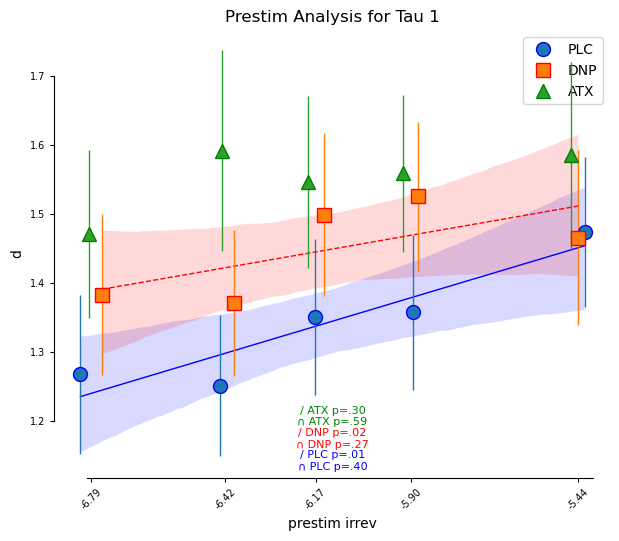

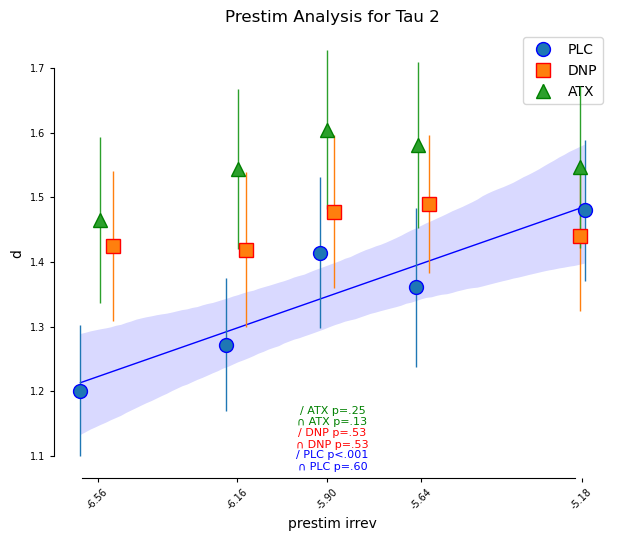

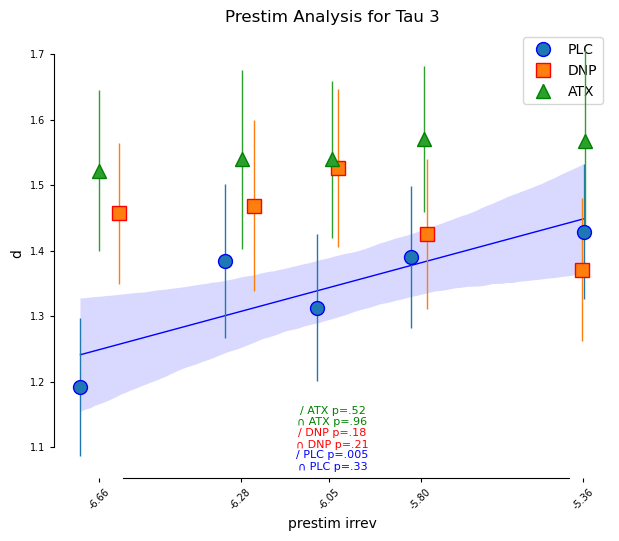

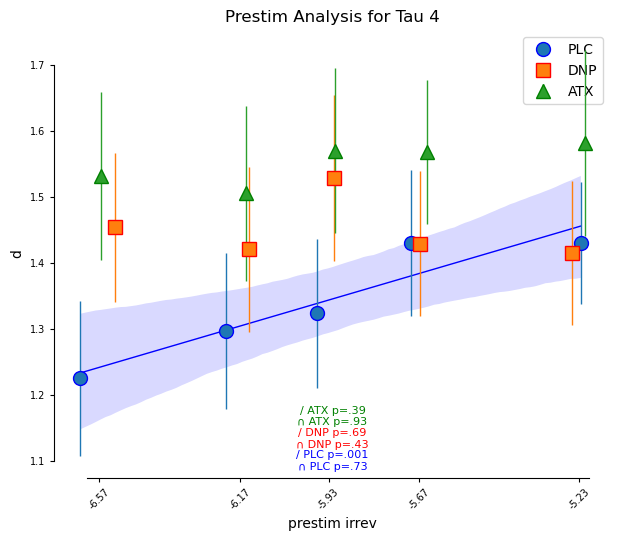

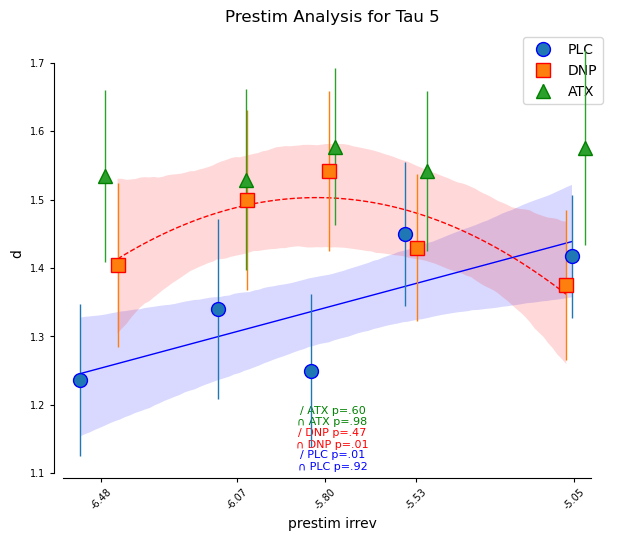

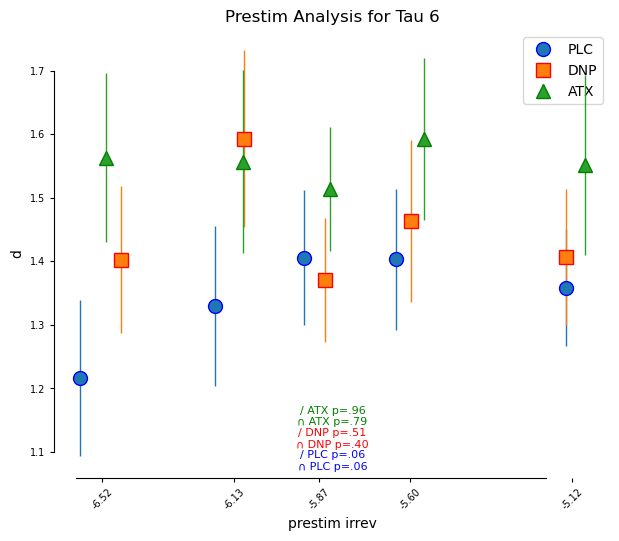

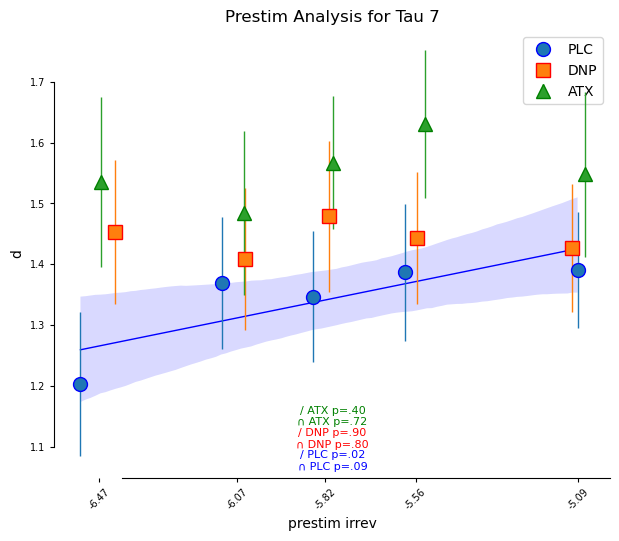

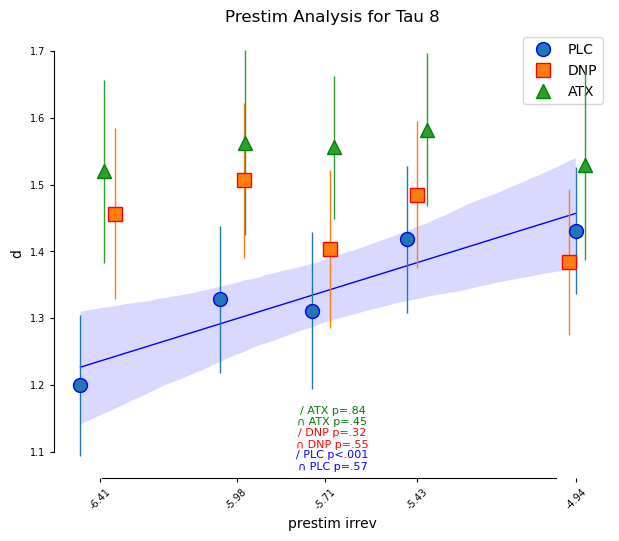

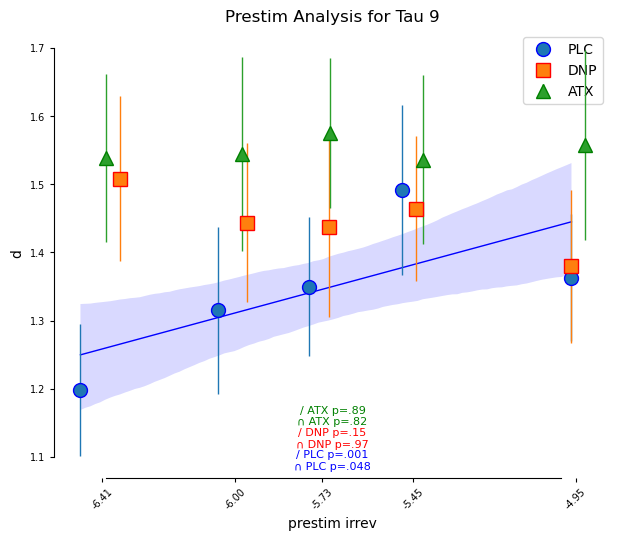

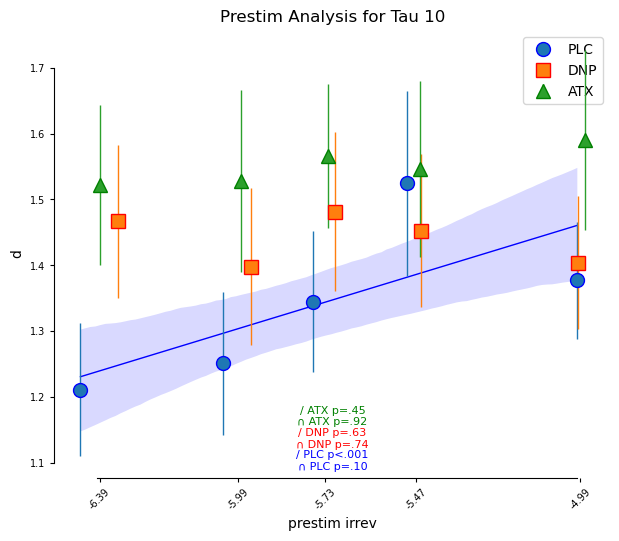

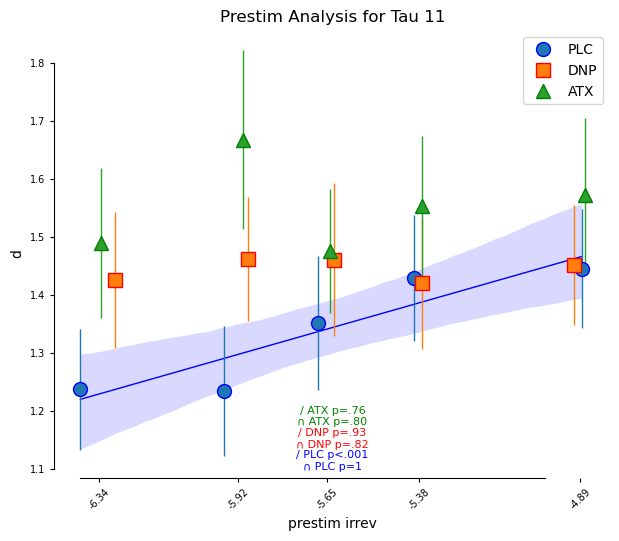

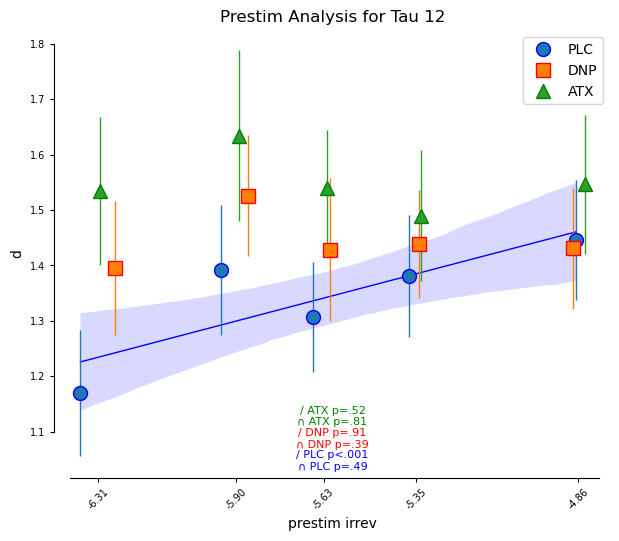

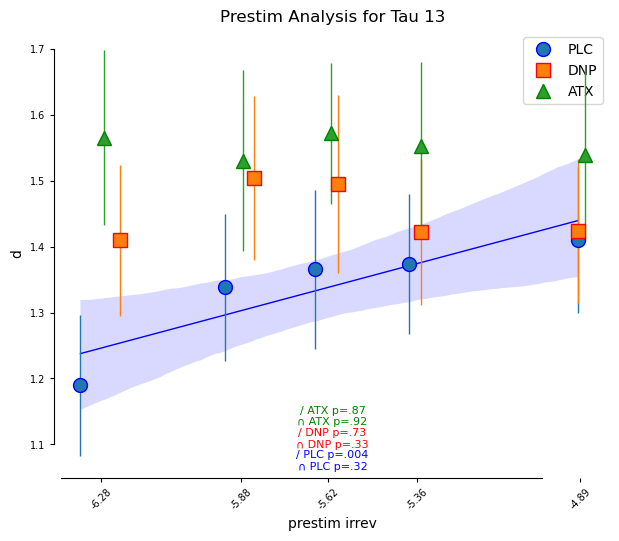

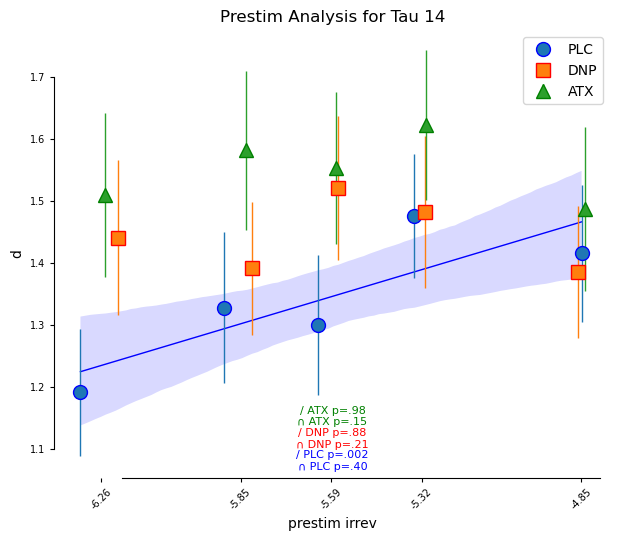

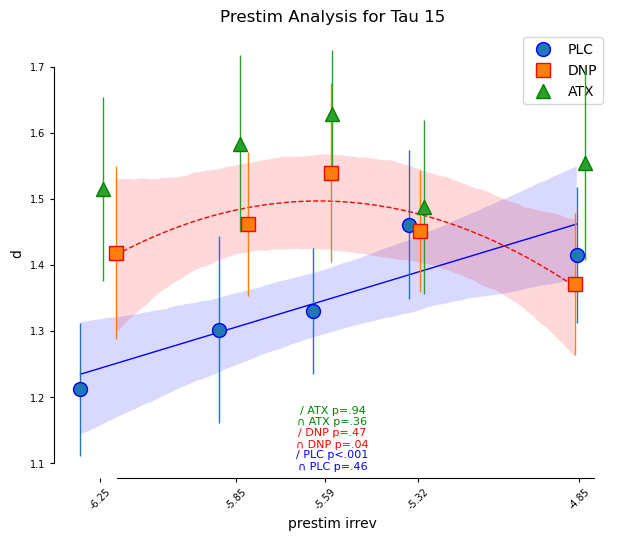

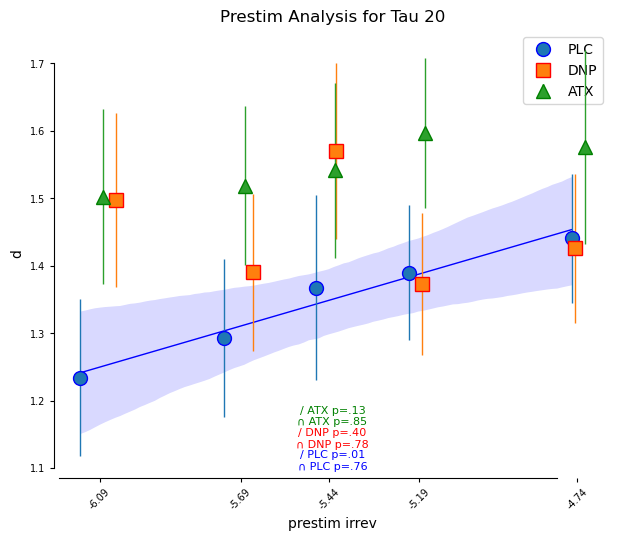

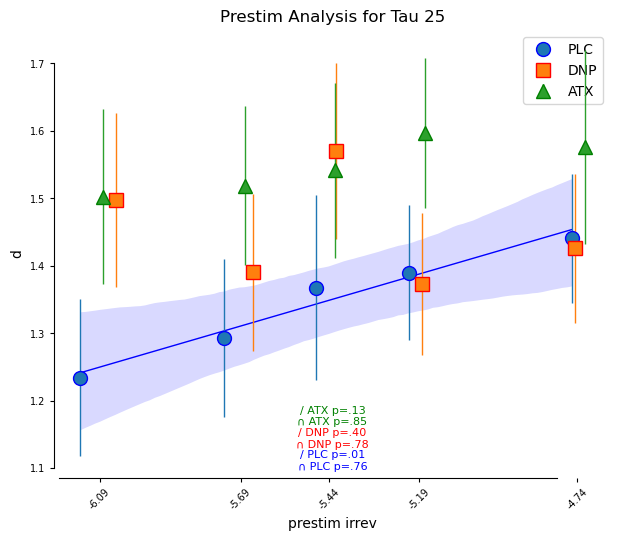

In [5]:
# Process each tau column dynamically
import warnings
warnings.filterwarnings("ignore")

def process_behavior(behavior, drug):
    behavior = behavior[(behavior['drug'] == drug)]
    
    behavior['irreversibility_bin'] = behavior.groupby(['subject', 'session', 'block'])['irrev'].apply(lambda x: pd.qcut(x, cfg['n_bins'], labels=range(cfg['n_bins']))).to_numpy()

    correct_counts = True
    df_sdt_irreversibility = behavior.groupby(['subject', 'drug', 'irreversibility_bin']).apply(lambda x: sdt(x, correct_counts))
    
    df_subject_irreversibility = df_sdt_irreversibility.groupby(['subject', 'irreversibility_bin']).mean()
    df_subject_irreversibility.reset_index(inplace=True)
    
    # Calculate the mean of each bin for x-axis labels
    bin_means = behavior.groupby('irreversibility_bin').mean()['irrev']
    #print("Drug: " + drug)
    #print("Bin means: " + str(bin_means))
    
    return df_subject_irreversibility, bin_means

cfg = {'n_bins': 5}
cm = 1 / 2.54 

for tau in list(range(1, 16)) + [20, 25]:
    tau_col = f'prestim_irrev_tau{tau}'  # Tau column name
    
    # Filter and process the DataFrame for the current tau
    behavior = df.copy()
    #behavior = behavior[(behavior[tau_col] < 0.075)]
    behavior['irrev'] = behavior[tau_col]

    # Process data for each drug
    df_subject_irreversibility_plc, bin_means_plc = process_behavior(behavior, 'PLC')
    df_subject_irreversibility_dnp, bin_means_dnp = process_behavior(behavior, 'DNP')
    df_subject_irreversibility_atx, bin_means_atx = process_behavior(behavior, 'ATX')

    # Combine bin means
    total_bin_means = (bin_means_plc + bin_means_dnp + bin_means_atx) / 3

    # Combine data for plotting
    df_combined = pd.concat([
        df_subject_irreversibility_plc.assign(drug='PLC', bin_mean=bin_means_plc[df_subject_irreversibility_plc['irreversibility_bin']].values),
        df_subject_irreversibility_dnp.assign(drug='DNP', bin_mean=bin_means_dnp[df_subject_irreversibility_dnp['irreversibility_bin']].values),
        df_subject_irreversibility_atx.assign(drug='ATX', bin_mean=bin_means_atx[df_subject_irreversibility_atx['irreversibility_bin']].values)
    ])

    # Plotting
    # Initialize variables to decide which model to plot
    plot_linear_plc = False
    plot_quadratic_plc = False
    plot_linear_dnp = False
    plot_quadratic_dnp = False
    plot_linear_atx = False
    plot_quadratic_atx = False

    # Calculate betas for PLC
    betas_first_irreversibility_plc = dict()
    _, betas_first_irreversibility_plc['d'] = sp.stats.ttest_1samp(df_subject_irreversibility_plc.groupby(['subject']).apply(run_model_irrevbin, 1, 'd'), 0)

    betas_second_irreversibility_plc = dict()
    _, betas_second_irreversibility_plc['d'] = sp.stats.ttest_1samp(df_subject_irreversibility_plc.groupby(['subject']).apply(run_model_irrevbin, 2, 'd'), 0)

    # Calculate betas for DNP
    betas_first_irreversibility_dnp = dict()
    _, betas_first_irreversibility_dnp['d'] = sp.stats.ttest_1samp(df_subject_irreversibility_dnp.groupby(['subject']).apply(run_model_irrevbin, 1, 'd'), 0)

    betas_second_irreversibility_dnp = dict()
    _, betas_second_irreversibility_dnp['d'] = sp.stats.ttest_1samp(df_subject_irreversibility_dnp.groupby(['subject']).apply(run_model_irrevbin, 2, 'd'), 0)

    # Calculate betas for ATX
    betas_first_irreversibility_atx = dict()
    _, betas_first_irreversibility_atx['d'] = sp.stats.ttest_1samp(df_subject_irreversibility_atx.groupby(['subject']).apply(run_model_irrevbin, 1, 'd'), 0)

    betas_second_irreversibility_atx = dict()
    _, betas_second_irreversibility_atx['d'] = sp.stats.ttest_1samp(df_subject_irreversibility_atx.groupby(['subject']).apply(run_model_irrevbin, 2, 'd'), 0)

    # Determine which model to plot for PLC based on the significance and smaller p-value
    if betas_first_irreversibility_plc['d'] < 0.05 or betas_second_irreversibility_plc['d'] < 0.05:
        if betas_first_irreversibility_plc['d'] < betas_second_irreversibility_plc['d']:
            plot_linear_plc = True
        elif betas_second_irreversibility_plc['d'] < betas_first_irreversibility_plc['d']:
            plot_quadratic_plc = True

    # Determine which model to plot for DNP based on the significance and smaller p-value
    if betas_first_irreversibility_dnp['d'] < 0.05 or betas_second_irreversibility_dnp['d'] < 0.05:
        if betas_first_irreversibility_dnp['d'] < betas_second_irreversibility_dnp['d']:
            plot_linear_dnp = True
        elif betas_second_irreversibility_dnp['d'] < betas_first_irreversibility_dnp['d']:
            plot_quadratic_dnp = True

    # Determine which model to plot for ATX based on the significance and smaller p-value
    if betas_first_irreversibility_atx['d'] < 0.05 or betas_second_irreversibility_atx['d'] < 0.05:
        if betas_first_irreversibility_atx['d'] < betas_second_irreversibility_atx['d']:
            plot_linear_atx = True
        elif betas_second_irreversibility_atx['d'] < betas_first_irreversibility_atx['d']:
            plot_quadratic_atx = True

    # Plotting results for log_poststim'
    cm = 1 / 2.54  # Conversion factor to cm
    fig, ax = plt.subplots(figsize=(16*cm, 14*cm))

    # PLC data
    ym_plc = df_subject_irreversibility_plc.groupby('irreversibility_bin').mean()['d']
    yerr_plc = df_subject_irreversibility_plc.groupby('irreversibility_bin').sem()['d']
    ax.errorbar(bin_means_plc, ym_plc, yerr=yerr_plc, capsize=0, ls='None', marker='o', alpha=1, zorder=1000, ms=10, mew=1, elinewidth=1, markeredgecolor='b', label='PLC')

    # DNP data
    ym_dnp = df_subject_irreversibility_dnp.groupby('irreversibility_bin').mean()['d']
    yerr_dnp = df_subject_irreversibility_dnp.groupby('irreversibility_bin').sem()['d']
    ax.errorbar(bin_means_dnp, ym_dnp, yerr=yerr_dnp, capsize=0, ls='None', marker='s', alpha=1, zorder=1000, ms=10, mew=1, elinewidth=1, markeredgecolor='r', label='DNP')

    # ATX data
    ym_atx = df_subject_irreversibility_atx.groupby('irreversibility_bin').mean()['d']
    yerr_atx = df_subject_irreversibility_atx.groupby('irreversibility_bin').sem()['d']
    ax.errorbar(bin_means_atx, ym_atx, yerr=yerr_atx, capsize=0, ls='None', marker='^', alpha=1, zorder=1000, ms=10, mew=1, elinewidth=1, markeredgecolor='g', label='ATX')

    # Plot linear/quadratic fit for each drug
    def plot_fit(ax, df, color, linestyle, order):
        sns.regplot(ax=ax, data=df, x="bin_mean", y="d", scatter=False, color=color,
                    line_kws={'linestyle': linestyle, 'lw': 1}, order=order, ci=68)

    # Optionally add model fits if linear/quadratic fit was significant for PLC
    if plot_linear_plc:
        plot_fit(ax, df_combined[df_combined['drug'] == 'PLC'], 'b', '-', 1)
    if plot_quadratic_plc:
        plot_fit(ax, df_combined[df_combined['drug'] == 'PLC'], 'b', '-', 2)

    # Optionally add model fits if linear/quadratic fit was significant for DNP
    if plot_linear_dnp:
        plot_fit(ax, df_combined[df_combined['drug'] == 'DNP'], 'r', '--', 1)
    if plot_quadratic_dnp:
        plot_fit(ax, df_combined[df_combined['drug'] == 'DNP'], 'r', '--', 2)

    # Optionally add model fits if linear/quadratic fit was significant for ATX
    if plot_linear_atx:
        plot_fit(ax, df_combined[df_combined['drug'] == 'ATX'], 'g', ':', 1)
    if plot_quadratic_atx:
        plot_fit(ax, df_combined[df_combined['drug'] == 'ATX'], 'g', ':', 2)

    # Plot p-values for the polynomial regression significance
    ax.text(0.5, 0.01, '/ PLC {}\n∩ PLC {}'.format(p_val_string(betas_first_irreversibility_plc['d']),
                                                p_val_string(betas_second_irreversibility_plc['d'])), ha='center', va='bottom', transform=ax.transAxes, size=8, color='b')

    ax.text(0.5, 0.06, '/ DNP {}\n∩ DNP {}'.format(p_val_string(betas_first_irreversibility_dnp['d']),
                                                p_val_string(betas_second_irreversibility_dnp['d'])), ha='center', va='bottom', transform=ax.transAxes, size=8, color='r')

    ax.text(0.5, 0.11, '/ ATX {}\n∩ ATX {}'.format(p_val_string(betas_first_irreversibility_atx['d']),
                                                p_val_string(betas_second_irreversibility_atx['d'])), ha='center', va='bottom', transform=ax.transAxes, size=8, color='g')

    sns.despine(ax=ax, offset=1, trim=True)

    # Setting labels and titles
    ax.set_ylabel('d')
    ax.set_xlabel('prestim irrev')
    ax.set_title(f'Prestim Analysis for Tau {tau}')

    labels = []
    for i in range(cfg['n_bins']):
        labels.append(f"{total_bin_means[i]:.2f}")

    ax.set_xticks(total_bin_means)
    ax.set_xticklabels(labels, rotation=45)
    ax.tick_params(axis='both', which='major', labelsize=7, length=3)

    ax.legend()
    fig.tight_layout()
    plt.show()



## drugs collapsed


Tau: 1
irreversibility_bin
0   -6.789113
1   -6.417300
2   -6.167602
3   -5.904069
4   -5.442507
Name: prestim_irrev_tau1, dtype: float64


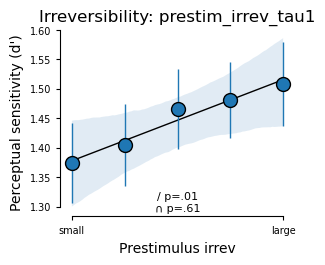


Tau: 2
irreversibility_bin
0   -6.555559
1   -6.160421
2   -5.904831
3   -5.637768
4   -5.181468
Name: prestim_irrev_tau2, dtype: float64


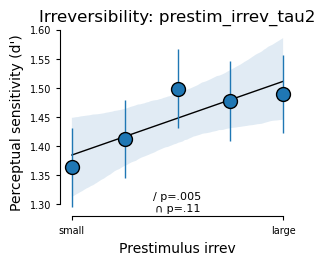


Tau: 3
irreversibility_bin
0   -6.663257
1   -6.283554
2   -6.045600
3   -5.799066
4   -5.361385
Name: prestim_irrev_tau3, dtype: float64


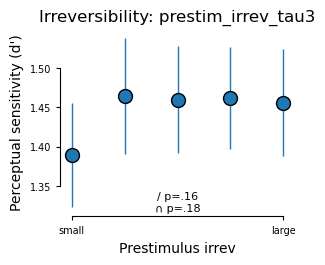


Tau: 4
irreversibility_bin
0   -6.566101
1   -6.171832
2   -5.926150
3   -5.673210
4   -5.228292
Name: prestim_irrev_tau4, dtype: float64


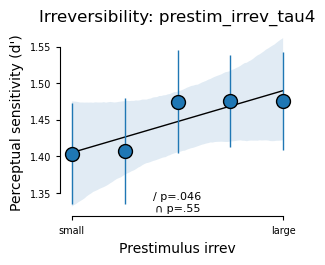


Tau: 5
irreversibility_bin
0   -6.484486
1   -6.072083
2   -5.803866
3   -5.527375
4   -5.048719
Name: prestim_irrev_tau5, dtype: float64


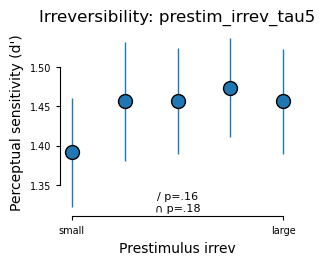


Tau: 6
irreversibility_bin
0   -6.521613
1   -6.128063
2   -5.873935
3   -5.603883
4   -5.120682
Name: prestim_irrev_tau6, dtype: float64


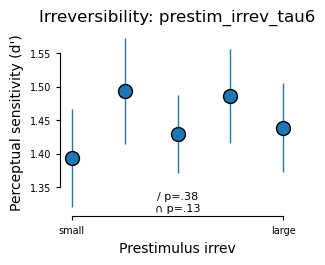


Tau: 7
irreversibility_bin
0   -6.467795
1   -6.069940
2   -5.817249
3   -5.557373
4   -5.090424
Name: prestim_irrev_tau7, dtype: float64


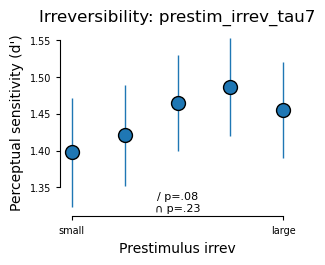


Tau: 8
irreversibility_bin
0   -6.405698
1   -5.984540
2   -5.710977
3   -5.428964
4   -4.937491
Name: prestim_irrev_tau8, dtype: float64


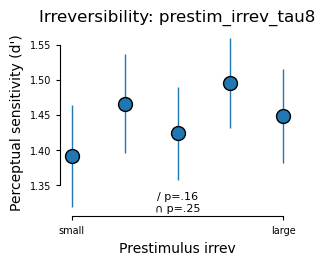


Tau: 9
irreversibility_bin
0   -6.411741
1   -6.001637
2   -5.733658
3   -5.453770
4   -4.954745
Name: prestim_irrev_tau9, dtype: float64


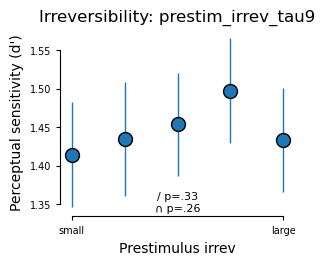


Tau: 10
irreversibility_bin
0   -6.391358
1   -5.987917
2   -5.734317
3   -5.469920
4   -4.991639
Name: prestim_irrev_tau10, dtype: float64


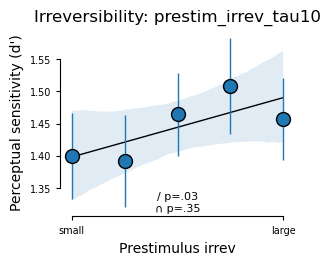


Tau: 11
irreversibility_bin
0   -6.343533
1   -5.923424
2   -5.654466
3   -5.377197
4   -4.892422
Name: prestim_irrev_tau11, dtype: float64


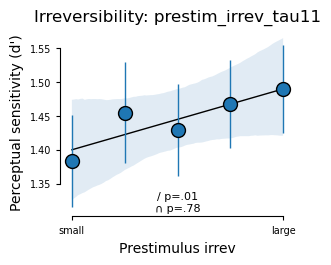


Tau: 12
irreversibility_bin
0   -6.314872
1   -5.899504
2   -5.633861
3   -5.354014
4   -4.864370
Name: prestim_irrev_tau12, dtype: float64


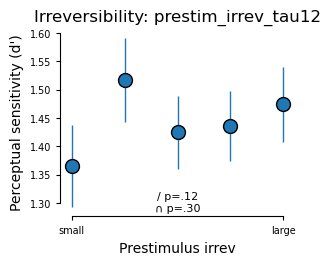


Tau: 13
irreversibility_bin
0   -6.284396
1   -5.878102
2   -5.624703
3   -5.364140
4   -4.889539
Name: prestim_irrev_tau13, dtype: float64


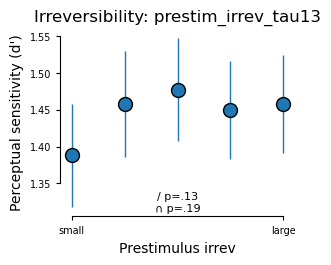


Tau: 14
irreversibility_bin
0   -6.261717
1   -5.852951
2   -5.588461
3   -5.321859
4   -4.853085
Name: prestim_irrev_tau14, dtype: float64


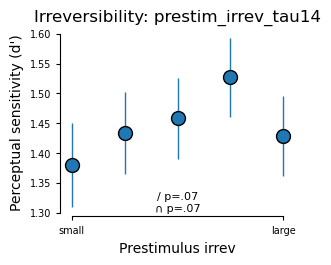


Tau: 15
irreversibility_bin
0   -6.250418
1   -5.851327
2   -5.588542
3   -5.317294
4   -4.844882
Name: prestim_irrev_tau15, dtype: float64


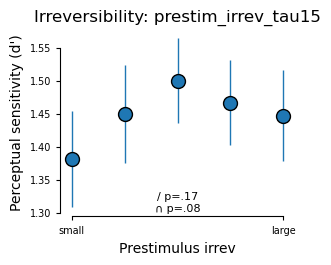


Tau: 20
irreversibility_bin
0   -6.086492
1   -5.690287
2   -5.440473
3   -5.188464
4   -4.742524
Name: prestim_irrev_tau20, dtype: float64


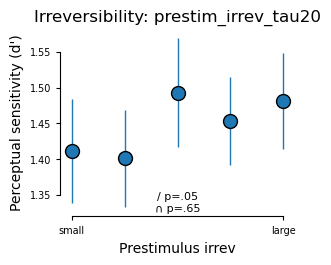


Tau: 25
irreversibility_bin
0   -6.086492
1   -5.690287
2   -5.440473
3   -5.188464
4   -4.742524
Name: prestim_irrev_tau25, dtype: float64


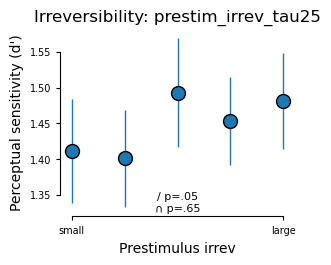

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

# List of tau values for the poststimulus irreversibility columns
taus = list(range(1, 16)) + [20, 25]
cfg = {'n_bins': 5}  # Number of pupil bins

for tau in taus:
    # Create a working copy of the data and define the tau-specific column name
    behavior = df.copy()
    tau_col = f'prestim_irrev_tau{tau}'
    
    # Replace the generic "prestim_irrev" column with the tau-specific column
    behavior['prestim_irrev'] = behavior[tau_col]
    
    # Sort the DataFrame by subject, session, and block (for binning)
    df_group = behavior.sort_values(by=['subject', 'session', 'block'])
    
    # Create quantile-based bins for the current tau column.
    # The bins are created separately within each (subject, session, block) group.
    df_group['irreversibility_bin'] = np.concatenate(
        np.ravel(
            df_group.groupby(['subject', 'session', 'block'])['prestim_irrev']
            .agg(lambda x: list(pd.qcut(x, cfg['n_bins'], labels=range(cfg['n_bins']))))
        )
    )
    
    # Compute SDT parameters (using your sdt function) per subject, drug, and bin.
    correct_counts = True
    df_sdt_irreversibility = df_group.groupby(['subject', 'drug', 'irreversibility_bin']) \
                                      .apply(lambda x: sdt(x, correct_counts))
    
    # Collapse across drugs to compute subject-level means for each bin.
    df_subject_irreversibility = df_sdt_irreversibility.groupby(['subject', 'irreversibility_bin']).mean()
    df_subject_irreversibility.reset_index(inplace=True)
    
    # (Optional) Print the group-level mean of the current tau column for each bin.
    print(f"\nTau: {tau}")
    print(df_group.groupby('irreversibility_bin').mean()[tau_col])
    
    # Run model fits on the binned data for each subject.
    # These functions are assumed to output a regression coefficient (or similar) for 'd'.
    betas_first_irreversibility = dict()
    _, betas_first_irreversibility['d'] = sp.stats.ttest_1samp(
        df_subject_irreversibility.groupby('subject').apply(run_model_irrevbin, 1, 'd'),
        0
    )
    
    betas_second_irreversibility = dict()
    _, betas_second_irreversibility['d'] = sp.stats.ttest_1samp(
        df_subject_irreversibility.groupby('subject').apply(run_model_irrevbin, 2, 'd'),
        0
    )
    
    # Begin plotting the results for perceptual sensitivity (d')
    cm = 1 / 2.54  # Conversion factor to cm for figure sizing
    fig, ax = plt.subplots(figsize=(8 * cm, 7 * cm))
    
    # Compute mean and standard error (SEM) for each bin (across subjects)
    ym = df_sdt_irreversibility.groupby('irreversibility_bin').mean()['d']
    yerr = df_sdt_irreversibility.groupby('irreversibility_bin').sem()['d']
    
    ax.errorbar(range(cfg['n_bins']), ym, yerr=yerr, capsize=0, ls='None', marker='o',
                alpha=1, zorder=1000, ms=10, mew=1, elinewidth=1, markeredgecolor='k')
    
    # Get p-values from the regression tests for linear and quadratic fits.
    p_val_linear = betas_first_irreversibility['d']
    p_val_quadratic = betas_second_irreversibility['d']
    
    # Decide which model to plot: choose the model with the lower p-value (if significant)
    plot_linear = False
    plot_quadratic = False
    if (p_val_linear < 0.05) or (p_val_quadratic < 0.05):
        if p_val_linear < p_val_quadratic:
            plot_linear = True
        elif p_val_quadratic < p_val_linear:
            plot_quadratic = True
    
    # Optionally overlay a linear fit if significant
    if plot_linear:
        sns.regplot(ax=ax,
                    data=df_subject_irreversibility,
                    x="irreversibility_bin",
                    y="d",
                    scatter=False,
                    color=sns.color_palette('Set1', 2)[-1],
                    line_kws={'linestyle': '-', 'lw': 1},
                    order=1,
                    ci=68)
        # Set the regression line color to black for clarity.
        ax.get_lines()[-1].set_color('k')
    
    # Optionally overlay a quadratic fit if significant
    if plot_quadratic:
        sns.regplot(ax=ax,
                    data=df_subject_irreversibility,
                    x="irreversibility_bin",
                    y="d",
                    scatter=False,
                    color=sns.color_palette('Set1', 2)[-1],
                    line_kws={'linestyle': '-', 'lw': 1},
                    order=2,
                    ci=68)
        ax.get_lines()[-1].set_color('k')
    
    # Annotate the plot with the formatted p-values from the regression tests.
    ax.text(0.5, 0.01,
            '/ {}\n∩ {}'.format(p_val_string(betas_first_irreversibility['d']),
                                p_val_string(betas_second_irreversibility['d'])),
            ha='center', va='bottom', transform=ax.transAxes, size=8)
    
    sns.despine(ax=ax, offset=1, trim=True)
    
    # Set plot labels and ticks
    ax.set_ylabel("Perceptual sensitivity (d')")
    ax.set_xlabel("Prestimulus irrev")
    ax.set_xticks([0, cfg['n_bins'] - 1])
    ax.set_xticklabels(['small', 'large'])
    ax.tick_params(axis='both', which='major', labelsize=7, length=3)
    
    # Title includes the tau-specific column name for clarity
    ax.set_title(f"Irreversibility: {tau_col}")
    fig.tight_layout()
    plt.show()


## pupil x irrev

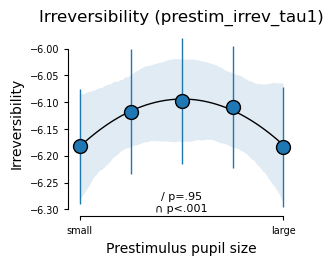

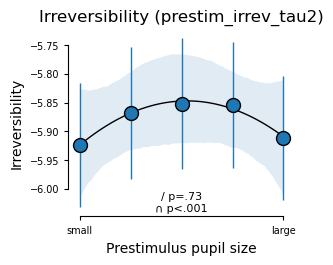

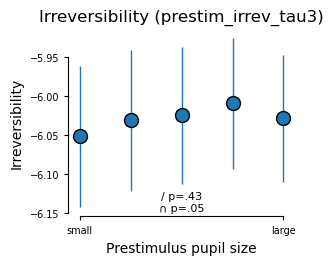

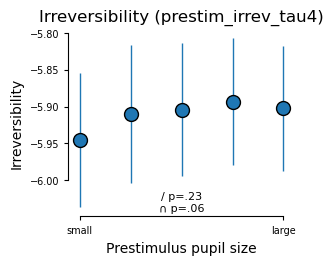

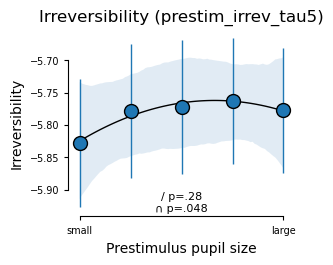

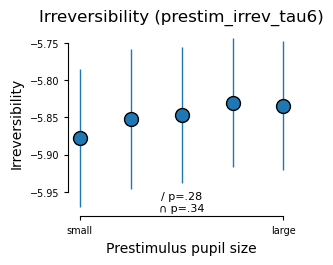

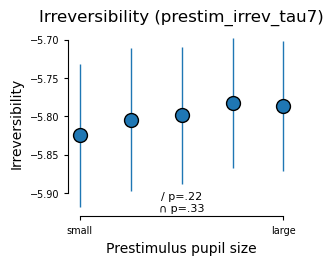

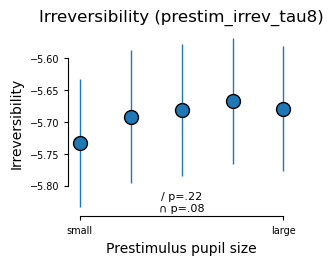

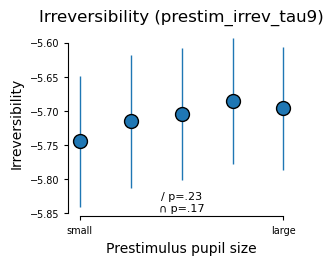

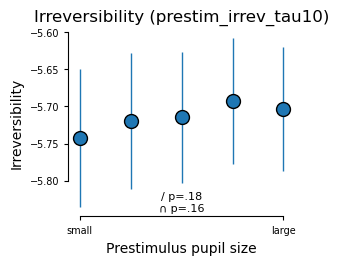

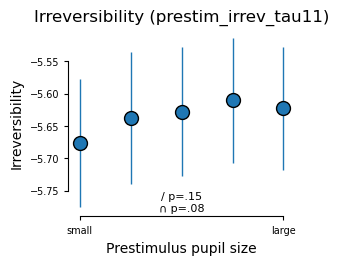

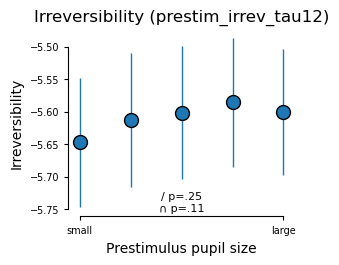

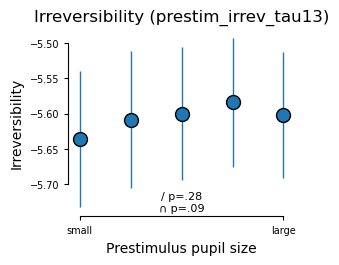

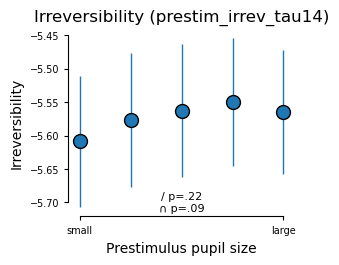

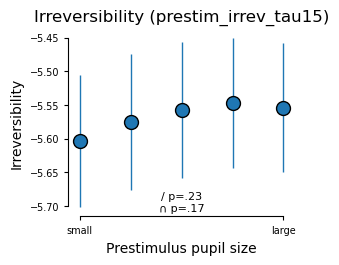

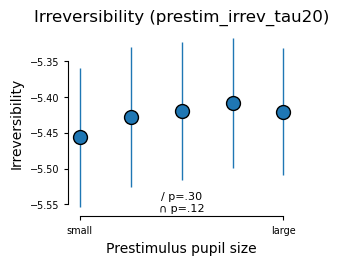

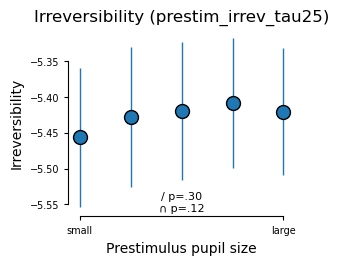

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

# List of tau values (columns) to iterate over
taus = list(range(1, 16)) + [20, 25]
cfg = {'n_bins': 5}  # Number of pupil bins

# Loop over each tau value
for tau in taus:
    # Create a working copy of the data and set the "irreversibility" column to the current tau
    behavior = df.copy()
    tau_col = f'prestim_irrev_tau{tau}'
    behavior['irreversibility'] = behavior[tau_col]

    # Sort the DataFrame (for binning)
    df_group = behavior.sort_values(by=['subject', 'session', 'block'])

    # Create pupil bins per subject, session, and block (using quantile-based bins)
    # Note: We use np.concatenate with np.ravel() to flatten the list of arrays from groupby.
    df_group['bl_pupil_bin'] = np.concatenate(np.ravel(
        df_group.groupby(['subject', 'session', 'block'])['bl_pupil']
        .agg(lambda x: list(pd.qcut(x, cfg['n_bins'], labels=range(cfg['n_bins']))))
    ))

    # Calculate SDT parameters per subject, drug, and pupil bin.
    correct_counts = True
    df_sdt = df_group.groupby(['subject', 'drug', 'bl_pupil_bin']).apply(lambda x: sdt(x, correct_counts))
    # For each grouping, take the mean "irreversibility" value.
    df_sdt['irreversibility'] = df_group.groupby(['subject', 'drug', 'bl_pupil_bin']).mean()['irreversibility']

    # Collapse across drugs by averaging (or change grouping as needed) to get subject-level data.
    df_subject = df_sdt.groupby(['subject', 'bl_pupil_bin']).mean()
    df_subject.reset_index(inplace=True)
    df_irrev = df_subject  # Rename for clarity in plotting

    # Run model fits on the pupil bins for each subject
    # Here, run_model_pupilbin is applied per subject with model order 1 (linear) and 2 (quadratic)
    betas_first = dict()
    t_stat1, p_val1 = sp.stats.ttest_1samp(
        df_irrev.groupby('subject').apply(run_model_pupilbin, 1, "irreversibility"), 0)
    betas_first['irreversibility'] = p_val1

    betas_second = dict()
    t_stat2, p_val2 = sp.stats.ttest_1samp(
        df_irrev.groupby('subject').apply(run_model_pupilbin, 2, "irreversibility"), 0)
    betas_second['irreversibility'] = p_val2

    # Plotting
    cm = 1 / 2.54  # Conversion factor from cm to inches for figure sizing
    fig, ax = plt.subplots(figsize=(8 * cm, 7 * cm))

    # Compute mean and SEM across subjects for each pupil bin
    ym = df_irrev.groupby('bl_pupil_bin').mean()['irreversibility']
    yerr = df_irrev.groupby('bl_pupil_bin').sem()['irreversibility']

    # Plot error bars (mean ± SEM)
    ax.errorbar(range(cfg['n_bins']), ym, yerr=yerr, capsize=0, ls='None', marker='o',
                alpha=1, zorder=1000, ms=10, mew=1, elinewidth=1, markeredgecolor='k')

    # Optionally add a linear fit if significant (model order 1)
    if betas_first['irreversibility'] < 0.05:
        sns.regplot(ax=ax, data=df_irrev, x="bl_pupil_bin", y="irreversibility",
                    scatter=False, color=sns.color_palette('Set1', 2)[-1],
                    line_kws={'linestyle': '-', 'lw': 1}, order=1, ci=68)
        # Adjust line color for visibility
        ax.get_lines()[-1].set_color('k')

    # Optionally add a quadratic fit if significant (model order 2)
    if betas_second['irreversibility'] < 0.05:
        sns.regplot(ax=ax, data=df_irrev, x="bl_pupil_bin", y="irreversibility",
                    scatter=False, color=sns.color_palette('Set1', 2)[-1],
                    line_kws={'linestyle': '-', 'lw': 1}, order=2, ci=68)
        ax.get_lines()[-1].set_color('k')

    # Annotate the plot with the p-values from the regression tests.
    # Here, p_val_string is assumed to be a function that nicely formats p-values.
    ax.text(0.5, 0.01,
            '/ {}\n∩ {}'.format(p_val_string(betas_first['irreversibility']),
                                 p_val_string(betas_second['irreversibility'])),
            ha='center', va='bottom', transform=ax.transAxes, size=8)

    sns.despine(ax=ax, offset=1, trim=True)

    # Set labels and titles
    ax.set_ylabel('Irreversibility')
    ax.set_xlabel('Prestimulus pupil size')
    ax.set_xticks([0, cfg['n_bins'] - 1])
    ax.set_xticklabels(['small', 'large'])
    ax.tick_params(axis='both', which='major', labelsize=7, length=3)

    # Add a title to show which tau is being plotted.
    ax.set_title(f'Irreversibility ({tau_col})')

    fig.tight_layout()
    plt.show()


## drug effects


----- Analysis for tau = 1 -----
Mean prestimulus irreversibility per subject and drug (first few rows):
drug          ATX       DNP       PLC
subject                              
1       -4.506807 -4.673099 -4.632786
2       -5.228655 -5.357260 -5.246968
3       -6.418230 -6.511945 -6.359869
4       -6.583033 -6.664408 -6.084355
5       -6.951834 -6.696885 -6.421097
Overall mean for each drug:
  PLC: -6.1472
  DNP: -6.1206
  ATX: -6.1465
Paired t-test PLC vs DNP (n=27): t = -0.421, p = 0.6772
Paired t-test PLC vs ATX (n=27): t = -0.009, p = 0.9927
Paired t-test DNP vs ATX (n=27): t = 0.496, p = 0.6243


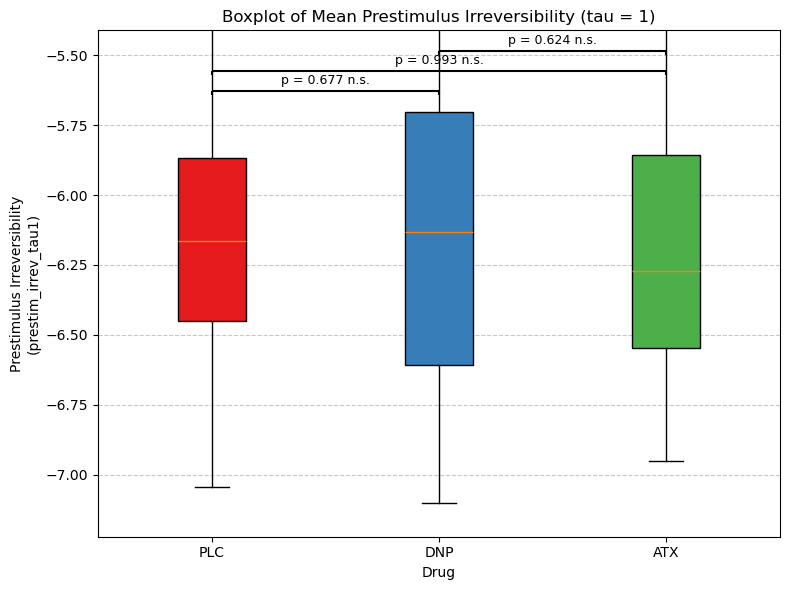


----- Analysis for tau = 2 -----
Mean prestimulus irreversibility per subject and drug (first few rows):
drug          ATX       DNP       PLC
subject                              
1       -4.490321 -4.641753 -4.677107
2       -5.152916 -5.258954 -5.253300
3       -5.703474 -5.983703 -5.860798
4       -6.158646 -6.225797 -5.586078
5       -6.583958 -6.326163 -6.009893
Overall mean for each drug:
  PLC: -5.9056
  DNP: -5.8645
  ATX: -5.8763
Paired t-test PLC vs DNP (n=27): t = -0.610, p = 0.5471
Paired t-test PLC vs ATX (n=27): t = -0.336, p = 0.7392
Paired t-test DNP vs ATX (n=27): t = 0.215, p = 0.8317


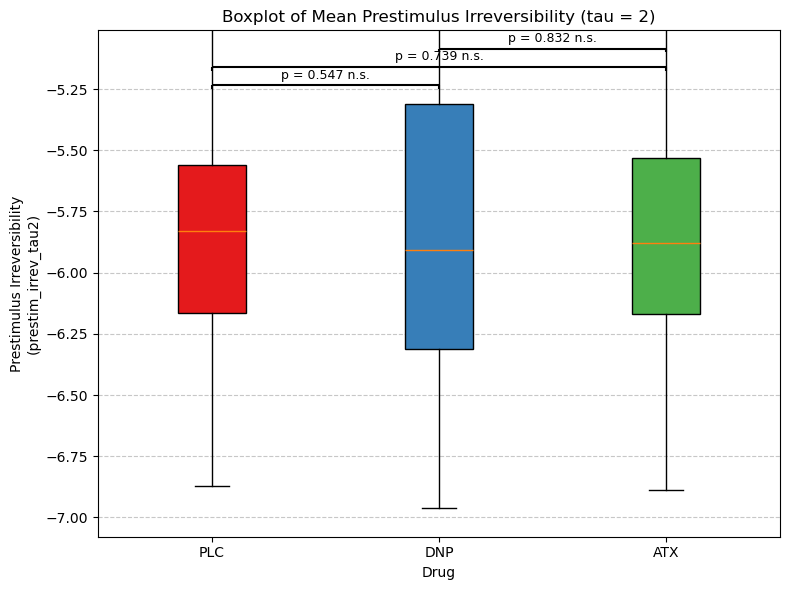


----- Analysis for tau = 3 -----
Mean prestimulus irreversibility per subject and drug (first few rows):
drug          ATX       DNP       PLC
subject                              
1       -5.552925 -5.490087 -5.784217
2       -5.827388 -5.705383 -5.811945
3       -5.388987 -5.785189 -5.727427
4       -5.953511 -6.008926 -5.437375
5       -6.450458 -6.191558 -5.887065
Overall mean for each drug:
  PLC: -6.0560
  DNP: -6.0111
  ATX: -6.0200
Paired t-test PLC vs DNP (n=27): t = -0.762, p = 0.4528
Paired t-test PLC vs ATX (n=27): t = -0.429, p = 0.6716
Paired t-test DNP vs ATX (n=27): t = 0.144, p = 0.8864


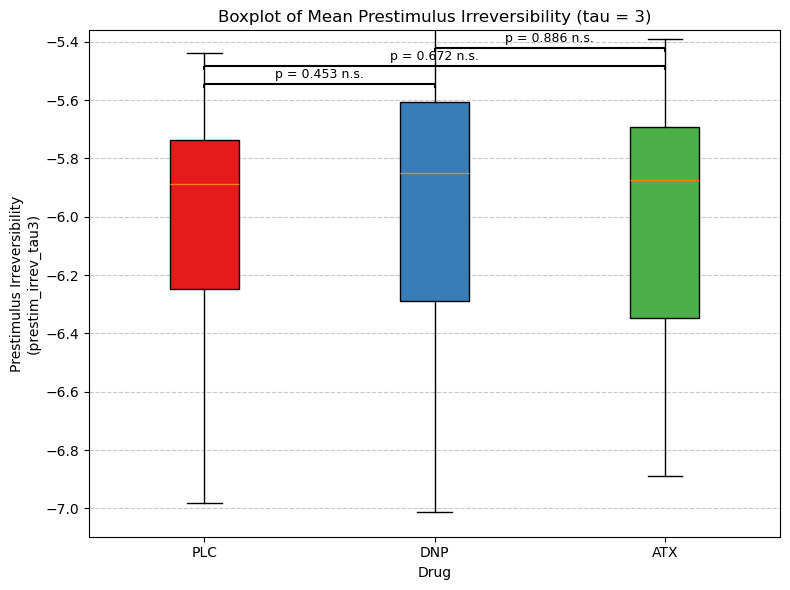


----- Analysis for tau = 4 -----
Mean prestimulus irreversibility per subject and drug (first few rows):
drug          ATX       DNP       PLC
subject                              
1       -5.108454 -5.113689 -5.271512
2       -5.784425 -5.579266 -5.617941
3       -5.186796 -5.617995 -5.597768
4       -5.771460 -5.840121 -5.307120
5       -6.354622 -6.072064 -5.739779
Overall mean for each drug:
  PLC: -5.9390
  DNP: -5.9036
  ATX: -5.8912
Paired t-test PLC vs DNP (n=27): t = -0.599, p = 0.5544
Paired t-test PLC vs ATX (n=27): t = -0.538, p = 0.5949
Paired t-test DNP vs ATX (n=27): t = -0.193, p = 0.8487


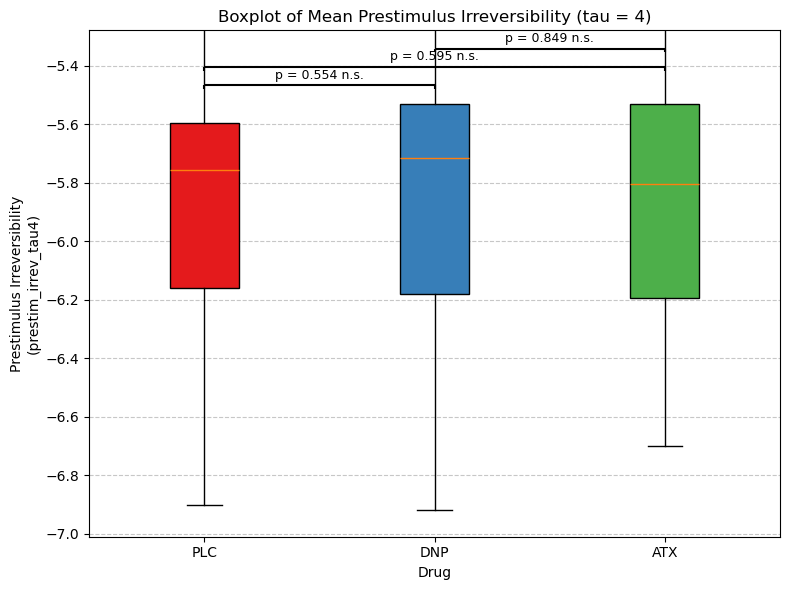


----- Analysis for tau = 5 -----
Mean prestimulus irreversibility per subject and drug (first few rows):
drug          ATX       DNP       PLC
subject                              
1       -4.552336 -4.748925 -4.800974
2       -5.438166 -5.423295 -5.485928
3       -5.051926 -5.480655 -5.490891
4       -5.625092 -5.701088 -5.190921
5       -6.272082 -5.982025 -5.640120
Overall mean for each drug:
  PLC: -5.8254
  DNP: -5.7745
  ATX: -5.7519
Paired t-test PLC vs DNP (n=27): t = -0.787, p = 0.4383
Paired t-test PLC vs ATX (n=27): t = -0.789, p = 0.4370
Paired t-test DNP vs ATX (n=27): t = -0.349, p = 0.7299


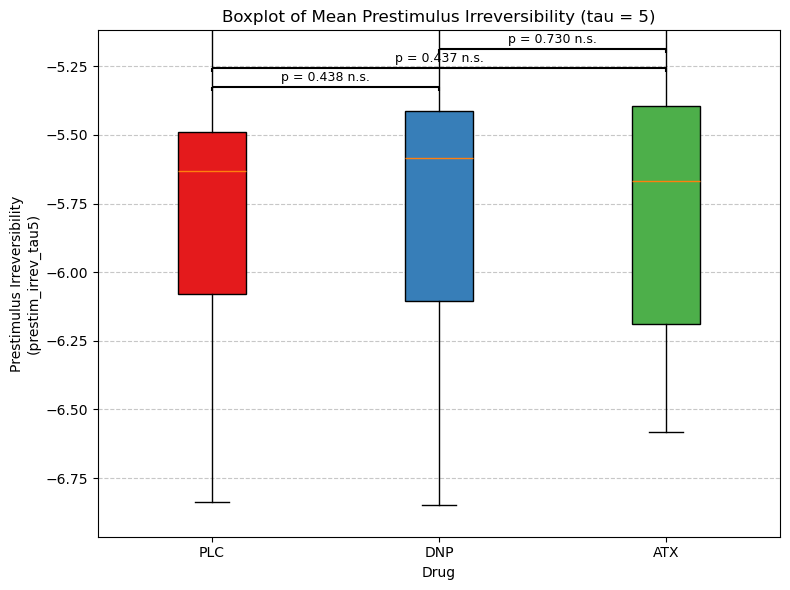


----- Analysis for tau = 6 -----
Mean prestimulus irreversibility per subject and drug (first few rows):
drug          ATX       DNP       PLC
subject                              
1       -5.048367 -5.225764 -5.378845
2       -5.613282 -5.527398 -5.687945
3       -4.966476 -5.381961 -5.424709
4       -5.532340 -5.637857 -5.088123
5       -6.237533 -5.954560 -5.595823
Overall mean for each drug:
  PLC: -5.8932
  DNP: -5.8367
  ATX: -5.8147
Paired t-test PLC vs DNP (n=27): t = -0.853, p = 0.4017
Paired t-test PLC vs ATX (n=27): t = -0.840, p = 0.4085
Paired t-test DNP vs ATX (n=27): t = -0.326, p = 0.7470


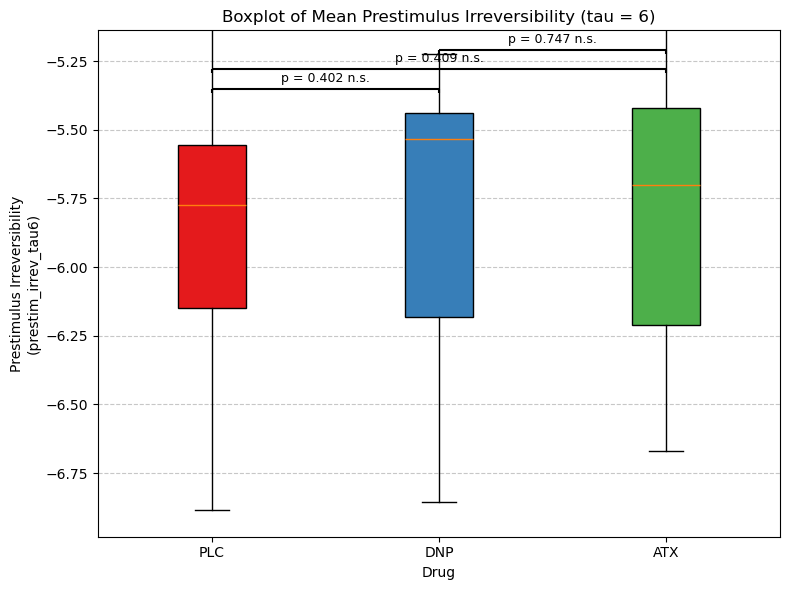


----- Analysis for tau = 7 -----
Mean prestimulus irreversibility per subject and drug (first few rows):
drug          ATX       DNP       PLC
subject                              
1       -5.114215 -5.118754 -5.349222
2       -5.721431 -5.461099 -5.609130
3       -4.906562 -5.310144 -5.358066
4       -5.472978 -5.600760 -5.013536
5       -6.179943 -5.881954 -5.500007
Overall mean for each drug:
  PLC: -5.8309
  DNP: -5.7905
  ATX: -5.7768
Paired t-test PLC vs DNP (n=27): t = -0.612, p = 0.5455
Paired t-test PLC vs ATX (n=27): t = -0.594, p = 0.5578
Paired t-test DNP vs ATX (n=27): t = -0.215, p = 0.8313


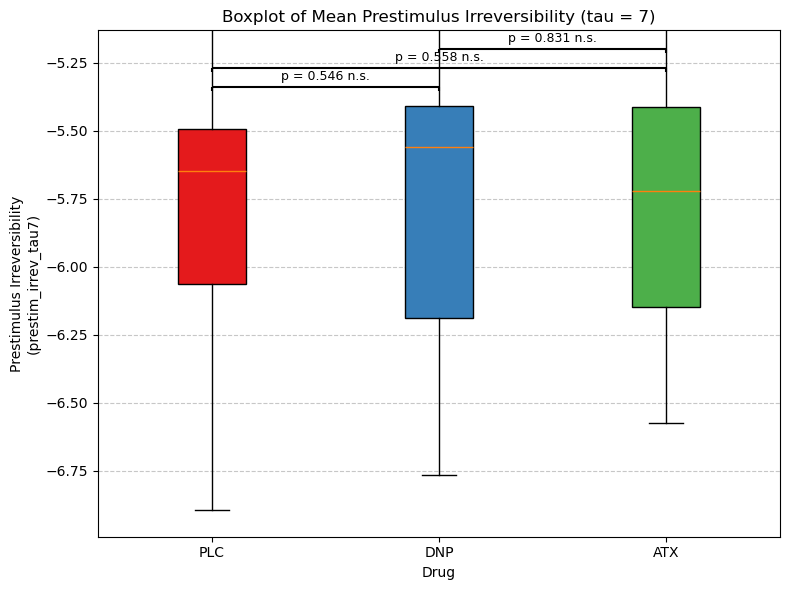


----- Analysis for tau = 8 -----
Mean prestimulus irreversibility per subject and drug (first few rows):
drug          ATX       DNP       PLC
subject                              
1       -4.495697 -4.700038 -4.779759
2       -5.504443 -5.441675 -5.501477
3       -4.869729 -5.256321 -5.328601
4       -5.426187 -5.520824 -4.966423
5       -6.134677 -5.819165 -5.462042
Overall mean for each drug:
  PLC: -5.7277
  DNP: -5.6827
  ATX: -5.6604
Paired t-test PLC vs DNP (n=27): t = -0.670, p = 0.5089
Paired t-test PLC vs ATX (n=27): t = -0.731, p = 0.4713
Paired t-test DNP vs ATX (n=27): t = -0.357, p = 0.7241


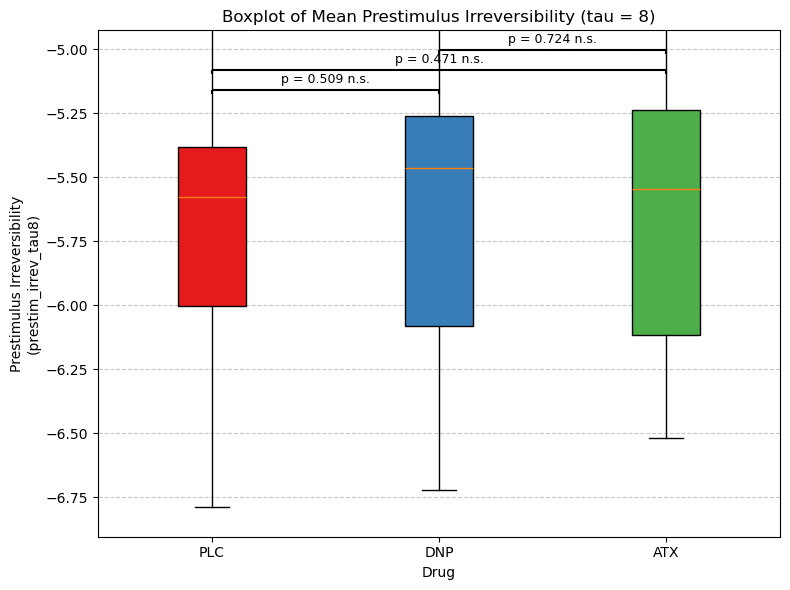


----- Analysis for tau = 9 -----
Mean prestimulus irreversibility per subject and drug (first few rows):
drug          ATX       DNP       PLC
subject                              
1       -4.853942 -5.015207 -5.164151
2       -5.445513 -5.419080 -5.509042
3       -4.851445 -5.223924 -5.300775
4       -5.396716 -5.470307 -4.947246
5       -6.110499 -5.800473 -5.442238
Overall mean for each drug:
  PLC: -5.7498
  DNP: -5.6954
  ATX: -5.6821
Paired t-test PLC vs DNP (n=27): t = -0.824, p = 0.4174
Paired t-test PLC vs ATX (n=27): t = -0.745, p = 0.4628
Paired t-test DNP vs ATX (n=27): t = -0.209, p = 0.8364


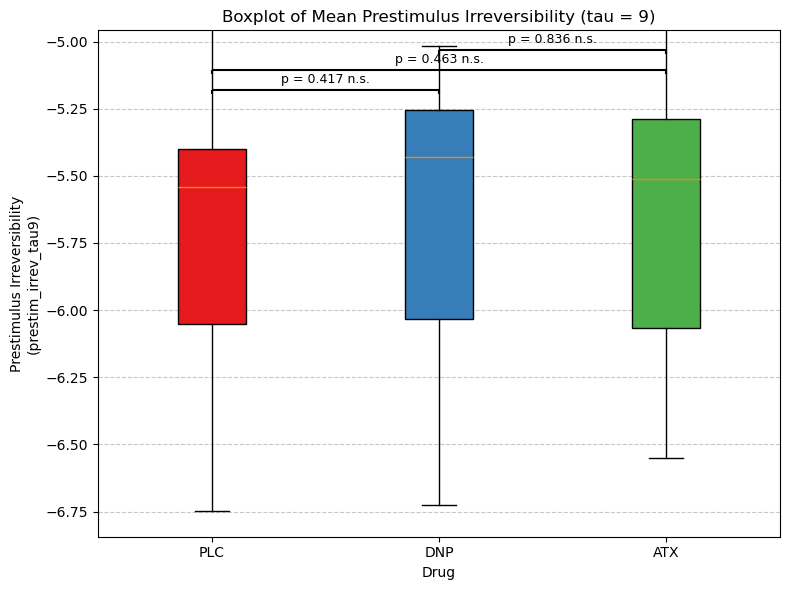


----- Analysis for tau = 10 -----
Mean prestimulus irreversibility per subject and drug (first few rows):
drug          ATX       DNP       PLC
subject                              
1       -5.317297 -5.204523 -5.505973
2       -5.472969 -5.328840 -5.434347
3       -4.838045 -5.200101 -5.276941
4       -5.378303 -5.462847 -4.933647
5       -6.075013 -5.741079 -5.403113
Overall mean for each drug:
  PLC: -5.7452
  DNP: -5.6951
  ATX: -5.7031
Paired t-test PLC vs DNP (n=27): t = -0.791, p = 0.4360
Paired t-test PLC vs ATX (n=27): t = -0.482, p = 0.6338
Paired t-test DNP vs ATX (n=27): t = 0.131, p = 0.8964


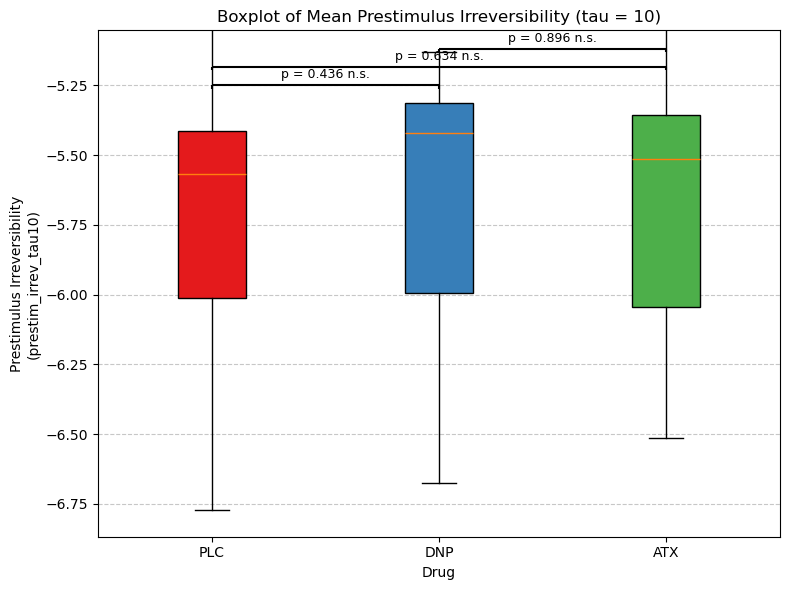


----- Analysis for tau = 11 -----
Mean prestimulus irreversibility per subject and drug (first few rows):
drug          ATX       DNP       PLC
subject                              
1       -4.623094 -4.694250 -4.825200
2       -5.403661 -5.326457 -5.363854
3       -4.833253 -5.191718 -5.267813
4       -5.364359 -5.490539 -4.919711
5       -6.055515 -5.741053 -5.390630
Overall mean for each drug:
  PLC: -5.6613
  DNP: -5.6232
  ATX: -5.6205
Paired t-test PLC vs DNP (n=27): t = -0.580, p = 0.5672
Paired t-test PLC vs ATX (n=27): t = -0.473, p = 0.6400
Paired t-test DNP vs ATX (n=27): t = -0.047, p = 0.9627


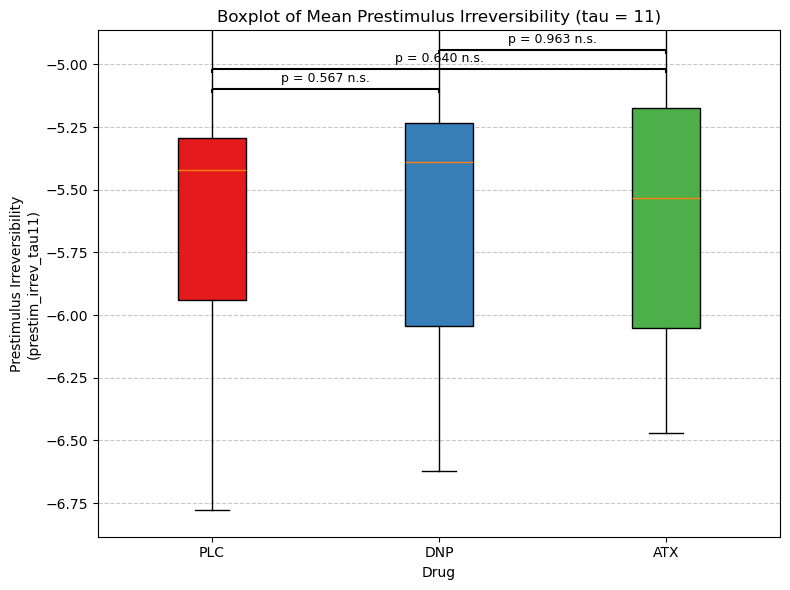


----- Analysis for tau = 12 -----
Mean prestimulus irreversibility per subject and drug (first few rows):
drug          ATX       DNP       PLC
subject                              
1       -4.489453 -4.683634 -4.784068
2       -5.321448 -5.280741 -5.314069
3       -4.833000 -5.191721 -5.263301
4       -5.352405 -5.471837 -4.907686
5       -6.046693 -5.741003 -5.389927
Overall mean for each drug:
  PLC: -5.6405
  DNP: -5.5959
  ATX: -5.5931
Paired t-test PLC vs DNP (n=27): t = -0.681, p = 0.5018
Paired t-test PLC vs ATX (n=27): t = -0.546, p = 0.5900
Paired t-test DNP vs ATX (n=27): t = -0.048, p = 0.9621


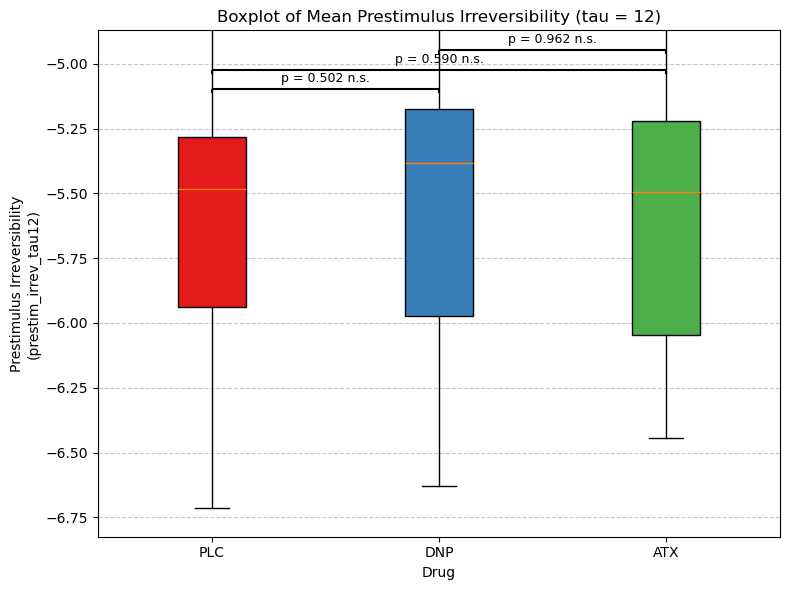


----- Analysis for tau = 13 -----
Mean prestimulus irreversibility per subject and drug (first few rows):
drug          ATX       DNP       PLC
subject                              
1       -4.798118 -4.903963 -5.107053
2       -5.250150 -5.223729 -5.275256
3       -4.824723 -5.192274 -5.267069
4       -5.337620 -5.409337 -4.898138
5       -6.036907 -5.728977 -5.389597
Overall mean for each drug:
  PLC: -5.6391
  DNP: -5.5871
  ATX: -5.5923
Paired t-test PLC vs DNP (n=27): t = -0.829, p = 0.4146
Paired t-test PLC vs ATX (n=27): t = -0.546, p = 0.5896
Paired t-test DNP vs ATX (n=27): t = 0.089, p = 0.9299


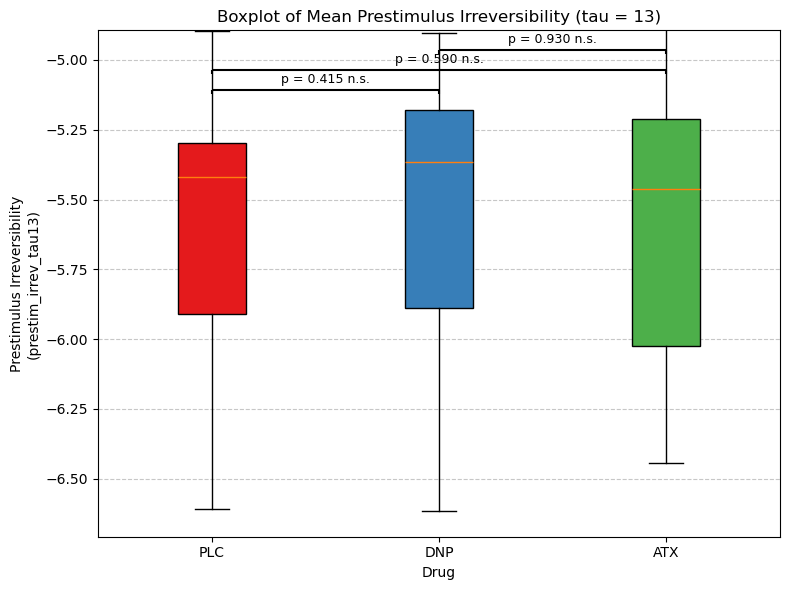


----- Analysis for tau = 14 -----
Mean prestimulus irreversibility per subject and drug (first few rows):
drug          ATX       DNP       PLC
subject                              
1       -4.569562 -4.683035 -4.806567
2       -5.211762 -5.243580 -5.267193
3       -4.812548 -5.188227 -5.260959
4       -5.322270 -5.374505 -4.890576
5       -6.037400 -5.726669 -5.404311
Overall mean for each drug:
  PLC: -5.6053
  DNP: -5.5578
  ATX: -5.5548
Paired t-test PLC vs DNP (n=27): t = -0.757, p = 0.4557
Paired t-test PLC vs ATX (n=27): t = -0.586, p = 0.5632
Paired t-test DNP vs ATX (n=27): t = -0.051, p = 0.9601


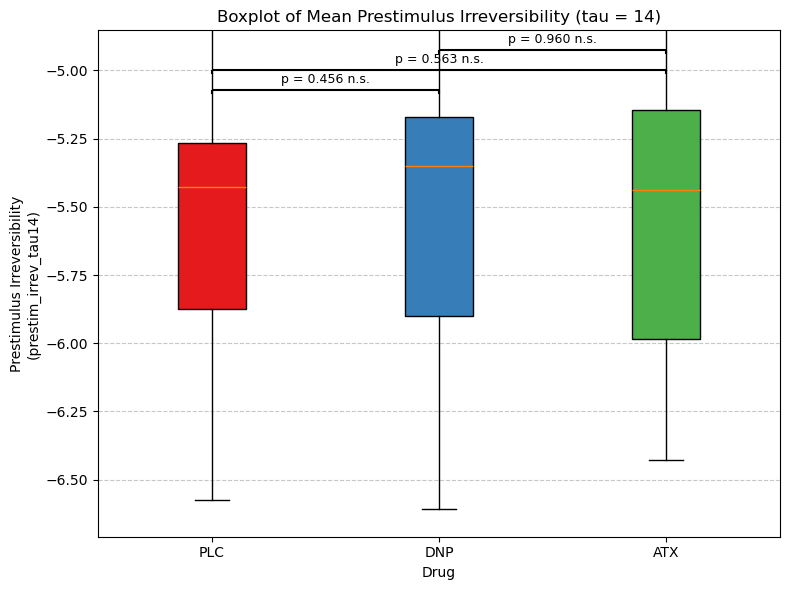


----- Analysis for tau = 15 -----
Mean prestimulus irreversibility per subject and drug (first few rows):
drug          ATX       DNP       PLC
subject                              
1       -4.497600 -4.661679 -4.771129
2       -5.196155 -5.212877 -5.216509
3       -4.790731 -5.170142 -5.242460
4       -5.303300 -5.384116 -4.877303
5       -6.016816 -5.720689 -5.397119
Overall mean for each drug:
  PLC: -5.6016
  DNP: -5.5536
  ATX: -5.5467
Paired t-test PLC vs DNP (n=27): t = -0.735, p = 0.4690
Paired t-test PLC vs ATX (n=27): t = -0.631, p = 0.5338
Paired t-test DNP vs ATX (n=27): t = -0.115, p = 0.9095


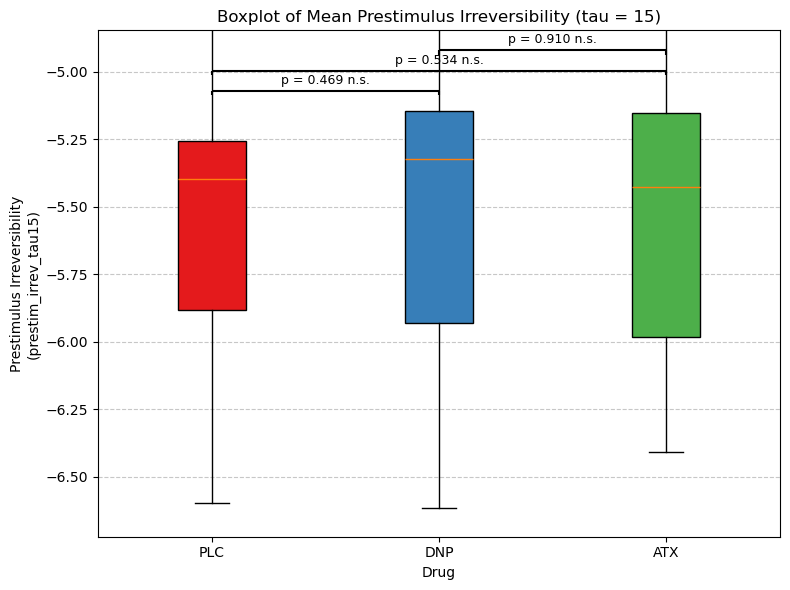


----- Analysis for tau = 20 -----
Mean prestimulus irreversibility per subject and drug (first few rows):
drug          ATX       DNP       PLC
subject                              
1       -4.594539 -4.671214 -4.828223
2       -5.121811 -5.065557 -5.108950
3       -4.651272 -5.054312 -5.058090
4       -5.171354 -5.277431 -4.739639
5       -5.887796 -5.575748 -5.261556
Overall mean for each drug:
  PLC: -5.4613
  DNP: -5.4116
  ATX: -5.4079
Paired t-test PLC vs DNP (n=27): t = -0.766, p = 0.4507
Paired t-test PLC vs ATX (n=27): t = -0.607, p = 0.5489
Paired t-test DNP vs ATX (n=27): t = -0.060, p = 0.9529


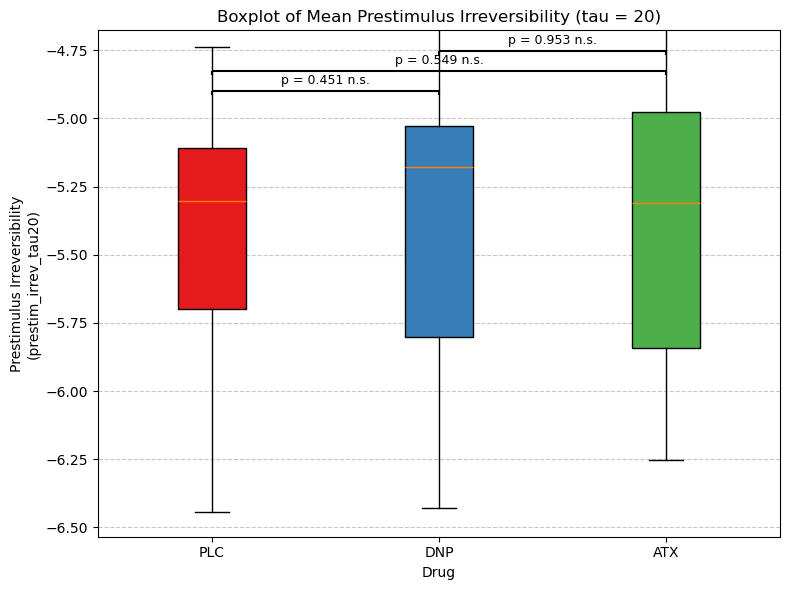


----- Analysis for tau = 25 -----
Mean prestimulus irreversibility per subject and drug (first few rows):
drug          ATX       DNP       PLC
subject                              
1       -4.273941 -4.432748 -4.530191
2       -4.913135 -4.895448 -4.939006
3       -4.541715 -4.971798 -4.936618
4       -5.062175 -5.183035 -4.646099
5       -5.761071 -5.479904 -5.166375
Overall mean for each drug:
  PLC: -5.3133
  DNP: -5.2652
  ATX: -5.2626
Paired t-test PLC vs DNP (n=27): t = -0.745, p = 0.4631
Paired t-test PLC vs ATX (n=27): t = -0.597, p = 0.5559
Paired t-test DNP vs ATX (n=27): t = -0.044, p = 0.9654


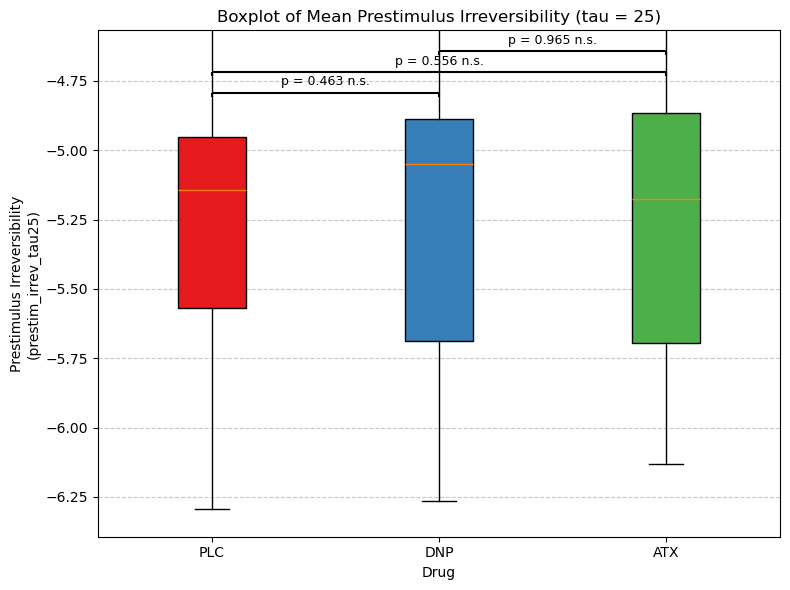

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_rel
from statsmodels.stats.multitest import multipletests

# List of tau values (1 through 15, plus 20 and 25)
taus = list(range(1, 16)) + [20, 25]
# List of drug conditions (ensure these match the levels in your df)
drugs = ['PLC', 'DNP', 'ATX']
# Define the pairwise comparisons in a fixed order
comparisons = [('PLC', 'DNP'), ('PLC', 'ATX'), ('DNP', 'ATX')]

# Dictionary to store results (raw p-values) for each tau
results = {}

for tau in taus:
    # Define the current tau column name
    tau_col = f'prestim_irrev_tau{tau}'
    
    # Group the data by subject and drug, computing the mean for each subject.
    grouped = df.groupby(['subject', 'drug'])[tau_col].mean().unstack()
    
    print(f"\n----- Analysis for tau = {tau} -----")
    print("Mean prestimulus irreversibility per subject and drug (first few rows):")
    print(grouped.head())
    
    # Print overall means (across subjects) for each drug.
    print("Overall mean for each drug:")
    for drug in drugs:
        if drug in grouped.columns:
            overall_mean = grouped[drug].mean()
            print(f"  {drug}: {overall_mean:.4f}")
        else:
            print(f"  {drug}: No data")
    
    # Run paired-sample t-tests for each drug comparison.
    p_values = []    # raw p-values
    comp_labels = [] # list of (drug1, drug2)
    
    for d1, d2 in comparisons:
        # Select subjects with data in both conditions.
        valid_data = grouped[[d1, d2]].dropna()
        n = len(valid_data)
        if n == 0:
            print(f"Not enough data for comparison between {d1} and {d2} at tau = {tau}.")
            p_values.append(np.nan)
            comp_labels.append((d1, d2))
            continue
        
        t_stat, p_val = ttest_rel(valid_data[d1], valid_data[d2])
        print(f"Paired t-test {d1} vs {d2} (n={n}): t = {t_stat:.3f}, p = {p_val:.4f}")
        p_values.append(p_val)
        comp_labels.append((d1, d2))
    
    # (No correction is used for the bars/significance annotations.)
    results[tau] = {comp_labels[i]: p_values[i] for i in range(len(comp_labels))}
    
    # ---------------------------
    # BOXPLOT VISUALIZATION
    # ---------------------------
    plt.figure(figsize=(8, 6))
    
    # Build a list of Series (one per drug) with subject-level means.
    data_list = [grouped[drug].dropna() for drug in drugs if drug in grouped.columns]
    
    # Create the boxplot. Boxes will be positioned at 1, 2, 3.
    bp = plt.boxplot(data_list, positions=range(1, len(data_list)+1),
                     patch_artist=True, showfliers=False)
    
    # Set colors for each box using a Seaborn palette.
    colors = sns.color_palette("Set1", len(data_list))
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    
    # Set the x-axis labels to the drug names.
    plt.xticks(range(1, len(data_list)+1), drugs)
    plt.xlabel('Drug')
    plt.ylabel(f'Prestimulus Irreversibility\n({tau_col})')
    plt.title(f'Boxplot of Mean Prestimulus Irreversibility (tau = {tau})')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # ---------------------------
    # SIGNIFICANCE BARS AT FIXED HEIGHTS RELATIVE TO THE 75TH PERCENTILE
    # ---------------------------
    # Instead of using the maximum, compute the 75th percentile for each drug group.
    quantiles75 = [np.percentile(s, 75) for s in data_list]
    base_y = np.max(quantiles75)  # Use the highest 75th percentile as the base.
    
    # For a scaling factor, compute the interquartile range (IQR) from all groups.
    iqr_vals = [np.percentile(s, 75) - np.percentile(s, 25) for s in data_list]
    avg_iqr = np.mean(iqr_vals) if iqr_vals else 1
    
    # Define fixed offsets (in data units) for the significance bars.
    # They will be placed at base_y plus a fixed multiple of the average IQR.
    fixed_offsets = [0.1 * avg_iqr, 0.2 * avg_iqr, 0.3 * avg_iqr]
    
    # Draw significance bars for each valid comparison (in the fixed order)
    for idx, (d1, d2) in enumerate(comparisons):
        # Get the raw p-value for this comparison.
        raw_p = p_values[idx] if idx < len(p_values) else np.nan
        
        # x positions for the boxes (boxes are at positions 1, 2, 3)
        x1 = drugs.index(d1) + 1
        x2 = drugs.index(d2) + 1
        
        # y position for the bar: always base_y plus a fixed offset.
        y_bar = base_y + fixed_offsets[idx]
        
        # Determine significance marker based on raw p-value.
        if np.isnan(raw_p):
            marker = "n/a"
            p_text = "n/a"
        else:
            p_text = f"{raw_p:.3f}"
            if raw_p < 0.001:
                marker = '***'
            elif raw_p < 0.01:
                marker = '**'
            elif raw_p < 0.05:
                marker = '*'
            else:
                marker = 'n.s.'
        
        # Draw the horizontal significance bar.
        plt.hlines(y_bar, x1, x2, color='black')
        # Draw vertical ticks at the ends.
        tick_height = 0.02 * avg_iqr
        plt.vlines(x1, y_bar - tick_height, y_bar, color='black')
        plt.vlines(x2, y_bar - tick_height, y_bar, color='black')
        # Place the annotation text in the middle of the bar.
        plt.text((x1 + x2) / 2, y_bar + tick_height, f"p = {p_text} {marker}",
                 ha='center', va='bottom', fontsize=9, color='black')
    
    # Adjust the y-axis limit so that all bars are visible.
    plt.ylim(top=base_y + fixed_offsets[-1] + 0.1 * avg_iqr)
    
    plt.tight_layout()
    plt.show()


In [15]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_rel
from statsmodels.stats.multitest import multipletests

# List of tau values (1 through 15, plus 20 and 25)
taus = list(range(1, 16)) + [20, 25]
# List of drug conditions
drugs = ['PLC', 'DNP', 'ATX']
# Define the pairwise comparisons (order does not matter for t-test)
comparisons = [('PLC', 'DNP'), ('PLC', 'ATX'), ('DNP', 'ATX')]

# Dictionary to store results for each tau
results = {}

for tau in taus:
    # Define the current tau column name
    tau_col = f'prestim_irrev_tau{tau}'
    
    # Group the data by subject and drug, and calculate the mean irrev value per subject.
    # The result will be a DataFrame with subjects as the index and drugs as columns.
    grouped = df.groupby(['subject', 'drug'])[tau_col].mean().unstack()
    
    print(f"\n----- Analysis for tau = {tau} -----")
    print("Mean prestimulus irrev per subject and drug (first few rows):")
    print(grouped.head())
    
    # For storing raw p-values (before correction) for the comparisons at this tau.
    p_values = []
    comp_labels = []
    
    # Loop through each pair of drug conditions
    for d1, d2 in comparisons:
        # Select only the subjects who have data for both drugs
        valid_data = grouped[[d1, d2]].dropna()
        n = len(valid_data)
        if n == 0:
            print(f"Not enough data for comparison between {d1} and {d2} at tau = {tau}.")
            p_values.append(np.nan)
            comp_labels.append((d1, d2))
            continue
        
        # Perform a paired-sample t-test between drug d1 and d2
        t_stat, p_val = ttest_rel(valid_data[d1], valid_data[d2])
        print(f"Paired t-test {d1} vs {d2} (n={n}): t = {t_stat:.3f}, p = {p_val:.4f}")
        p_values.append(p_val)
        comp_labels.append((d1, d2))
    
    # Correct the p-values for multiple comparisons (three comparisons per tau) using Bonferroni correction.
    # Only correct non-NaN values.
    valid_indices = [i for i, p in enumerate(p_values) if not np.isnan(p)]
    if valid_indices:
        valid_p_values = [p_values[i] for i in valid_indices]
        reject, corrected_pvals, _, _ = multipletests(valid_p_values, alpha=0.05, method='bonferroni')
        
        # Report the corrected p-values for the comparisons that were performed.
        for idx, corr_p in zip(valid_indices, corrected_pvals):
            d1, d2 = comp_labels[idx]
            print(f"Tau {tau}, corrected paired t-test {d1} vs {d2}: corrected p = {corr_p:.4f}")
    
    # Save the raw p-values for this tau (if needed later)
    results[tau] = {comp_labels[i]: p_values[i] for i in range(len(comp_labels))}





----- Analysis for tau = 1 -----
Mean prestimulus irrev per subject and drug (first few rows):
drug          ATX       DNP       PLC
subject                              
1       -4.506807 -4.673099 -4.632786
2       -5.228655 -5.357260 -5.246968
3       -6.418230 -6.511945 -6.359869
4       -6.583033 -6.664408 -6.084355
5       -6.951834 -6.696885 -6.421097
Paired t-test PLC vs DNP (n=27): t = -0.421, p = 0.6772
Paired t-test PLC vs ATX (n=27): t = -0.009, p = 0.9927
Paired t-test DNP vs ATX (n=27): t = 0.496, p = 0.6243
Tau 1, corrected paired t-test PLC vs DNP: corrected p = 1.0000
Tau 1, corrected paired t-test PLC vs ATX: corrected p = 1.0000
Tau 1, corrected paired t-test DNP vs ATX: corrected p = 1.0000

----- Analysis for tau = 2 -----
Mean prestimulus irrev per subject and drug (first few rows):
drug          ATX       DNP       PLC
subject                              
1       -4.490321 -4.641753 -4.677107
2       -5.152916 -5.258954 -5.253300
3       -5.703474 -5.983703 -5.

# IRREV X Drug differences

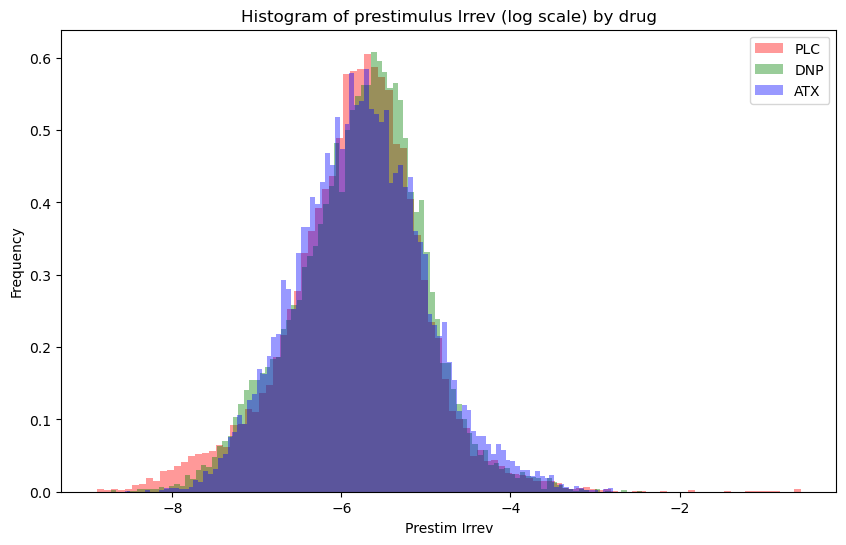

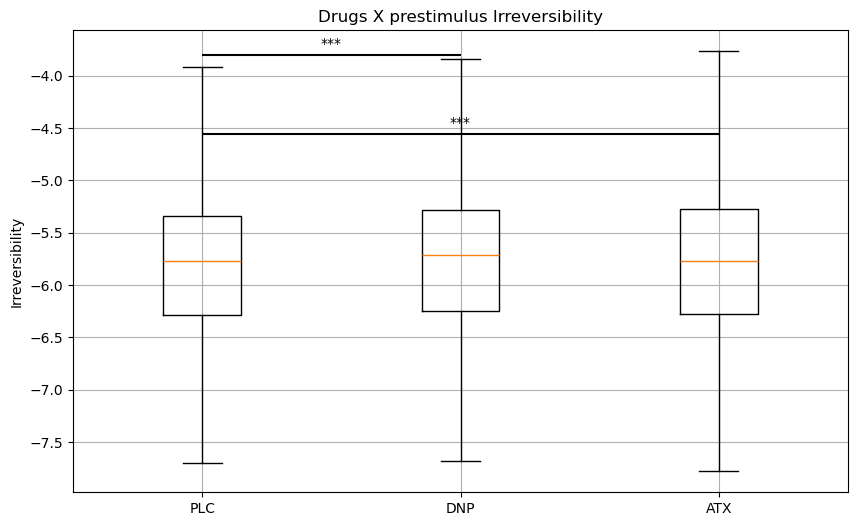

The mean of PLC -5.827662234537867
The mean of DNP -5.773582617991106
The mean of ATX -5.761498369320878
The std dev of PLC 0.8064159725469076
The std dev of DNP 0.7555541690931477
The std dev of ATX 0.7630261717443516


In [9]:
behavior = df

df_plc = behavior[behavior['drug'] == 'PLC']
df_dnp = behavior[behavior['drug'] == 'DNP']
df_atx = behavior[behavior['drug'] == 'ATX']

# Setting up the figure and axes
plt.figure(figsize=(10, 6))

plt.hist(df_plc['log_prestim'], bins=100, alpha=0.4, label='PLC', color='red', density = True)
plt.hist(df_dnp['log_prestim'], bins=100, alpha=0.4, label='DNP', color='green', density = True)
plt.hist(df_atx['log_prestim'], bins=100, alpha=0.4, label='ATX', color='blue', density = True)

# Adding labels and title
plt.xlabel('Prestim Irrev')
plt.ylabel('Frequency')
plt.title('Histogram of prestimulus Irrev (log scale) by drug')
plt.legend()

# Show the plot
plt.show()


import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from statsmodels.stats.multitest import multipletests

# Assuming 'behavior' and 'prestimulus_rawdata_irrev_array' are defined as in your environment.
behavior = df

irrev_sub_plc = []
drugs = ['PLC', 'DNP', 'ATX']

for drug in drugs:
    irrev_sub_plc.append(behavior[behavior['drug'] == drug]['log_prestim'])

# Creating the boxplot with improved clarity
plt.figure(figsize=(10, 6))
box = plt.boxplot(irrev_sub_plc, positions=np.arange(len(drugs)), showfliers=False)
plt.xticks(np.arange(len(drugs)), drugs)
plt.ylabel('Irreversibility')
plt.title('Drugs X prestimulus Irreversibility')
plt.grid(True)


# Mann-Whitney U tests across drugs with corrections

p_values = []
comparisons = []

for i in range(len(irrev_sub_plc)):
    for j in range(i + 1, len(irrev_sub_plc)):
        stat, p = stats.mannwhitneyu(irrev_sub_plc[i], irrev_sub_plc[j], alternative='two-sided')
        p_values.append(p)
        comparisons.append((drugs[i], drugs[j]))

corrected_p_values = multipletests(p_values, alpha=0.05, method='bonferroni')[1]

# Annotating significant differences
max_y = max([item.get_data()[1].max() for item in box['caps']])  # Find the maximum y-value of the whiskers
y_offset = max_y * 0.1  # Slightly above the highest whisker
for i, (comp, corrected_p_val) in enumerate(zip(comparisons, corrected_p_values)):
    x1, x2 = drugs.index(comp[0]), drugs.index(comp[1])
    # Decide number of asterisks based on significance level
    if corrected_p_val < 0.001:
        num_asterisks = '***'
    elif corrected_p_val < 0.01:
        num_asterisks = '**'
    elif corrected_p_val < 0.05:
        num_asterisks = '*'
    else:
        num_asterisks = ''

    if num_asterisks:  # Only draw if there's a significant result
        plt.hlines((max_y+max_y*0.01) + y_offset * i * 2, x1, x2, color="black")
        plt.text((x1 + x2) / 2, max_y + y_offset * (i * 2), num_asterisks, ha='center', va='bottom', color='black')

plt.show()

print("The mean of PLC "+str(np.mean(irrev_sub_plc[0])))
print("The mean of DNP "+str(np.mean(irrev_sub_plc[1])))
print("The mean of ATX "+str(np.mean(irrev_sub_plc[2])))

print("The std dev of PLC "+str(np.std(irrev_sub_plc[0])))
print("The std dev of DNP "+str(np.std(irrev_sub_plc[1])))
print("The std dev of ATX "+str(np.std(irrev_sub_plc[2])))

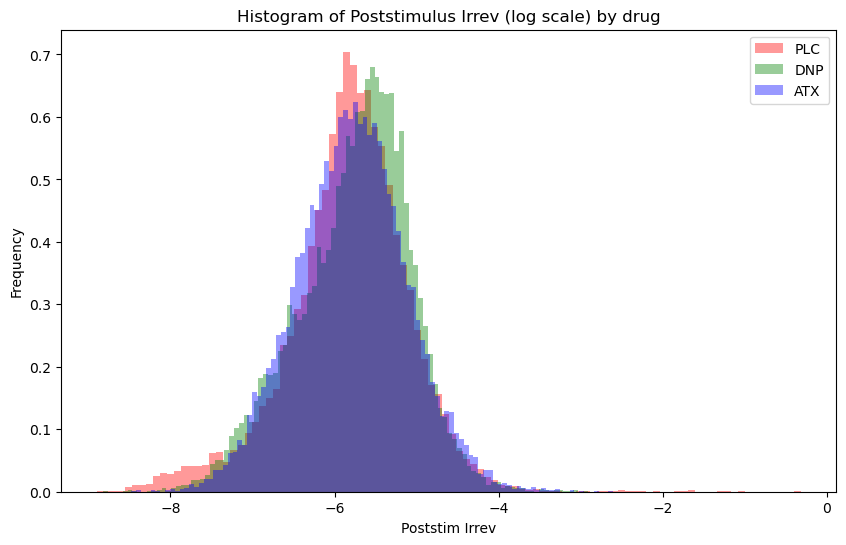

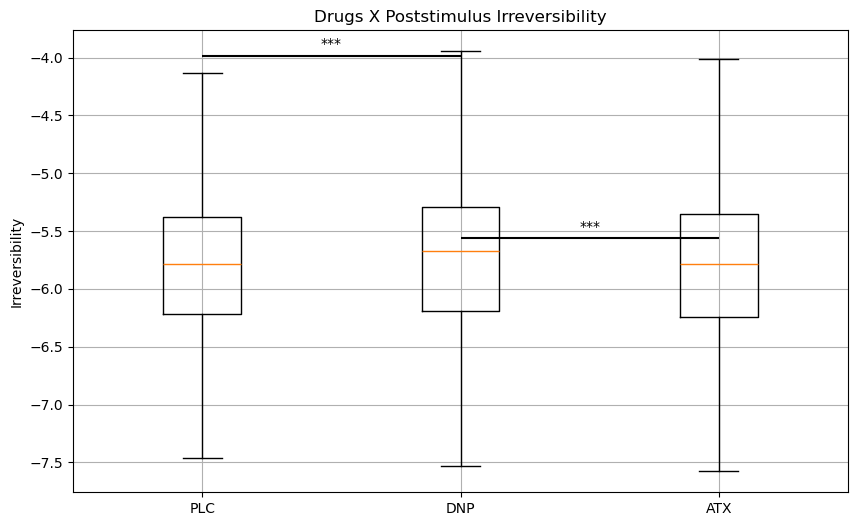

The std dev of PLC 0.7390750690951446
The std dev of DNP 0.6858461859292766
The std dev of ATX 0.6773611961105442


In [19]:
behavior = df

df_plc = behavior[behavior['drug'] == 'PLC']
df_dnp = behavior[behavior['drug'] == 'DNP']
df_atx = behavior[behavior['drug'] == 'ATX']

# Setting up the figure and axes
plt.figure(figsize=(10, 6))

plt.hist(df_plc['poststim_irrev_tau7'], bins=100, alpha=0.4, label='PLC', color='red', density = True)
plt.hist(df_dnp['poststim_irrev_tau7'], bins=100, alpha=0.4, label='DNP', color='green', density = True)
plt.hist(df_atx['poststim_irrev_tau7'], bins=100, alpha=0.4, label='ATX', color='blue', density = True)

# Adding labels and title
plt.xlabel('Poststim Irrev')
plt.ylabel('Frequency')
plt.title('Histogram of Poststimulus Irrev (log scale) by drug')
plt.legend()

# Show the plot
plt.show()


import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from statsmodels.stats.multitest import multipletests

# Assuming 'behavior' and 'prestimulus_rawdata_irrev_array' are defined as in your environment.
behavior = df

irrev_sub_plc = []
drugs = ['PLC', 'DNP', 'ATX']

for drug in drugs:
    irrev_sub_plc.append(behavior[behavior['drug'] == drug]['poststim_irrev_tau7'])

# Creating the boxplot with improved clarity
plt.figure(figsize=(10, 6))
box = plt.boxplot(irrev_sub_plc, positions=np.arange(len(drugs)), showfliers=False)
plt.xticks(np.arange(len(drugs)), drugs)
plt.ylabel('Irreversibility')
plt.title('Drugs X Poststimulus Irreversibility')
plt.grid(True)


# Mann-Whitney U tests across drugs with corrections

p_values = []
comparisons = []

for i in range(len(irrev_sub_plc)):
    for j in range(i + 1, len(irrev_sub_plc)):
        stat, p = stats.mannwhitneyu(irrev_sub_plc[i], irrev_sub_plc[j], alternative='two-sided')
        p_values.append(p)
        comparisons.append((drugs[i], drugs[j]))

corrected_p_values = multipletests(p_values, alpha=0.05, method='bonferroni')[1]

# Annotating significant differences
max_y = max([item.get_data()[1].max() for item in box['caps']])  # Find the maximum y-value of the whiskers
y_offset = max_y * 0.1  # Slightly above the highest whisker
for i, (comp, corrected_p_val) in enumerate(zip(comparisons, corrected_p_values)):
    x1, x2 = drugs.index(comp[0]), drugs.index(comp[1])
    # Decide number of asterisks based on significance level
    if corrected_p_val < 0.001:
        num_asterisks = '***'
    elif corrected_p_val < 0.01:
        num_asterisks = '**'
    elif corrected_p_val < 0.05:
        num_asterisks = '*'
    else:
        num_asterisks = ''

    if num_asterisks:  # Only draw if there's a significant result
        plt.hlines((max_y+max_y*0.01) + y_offset * i * 2, x1, x2, color="black")
        plt.text((x1 + x2) / 2, max_y + y_offset * (i * 2), num_asterisks, ha='center', va='bottom', color='black')

plt.show()

print("The std dev of PLC "+str(np.std(irrev_sub_plc[0])))
print("The std dev of DNP "+str(np.std(irrev_sub_plc[1])))
print("The std dev of ATX "+str(np.std(irrev_sub_plc[2])))